# **Loan Default Prediction** 
by Heiner Lehr  
February 2024

**NOTE** As per advice from the mentor, the executive summary, problem and solution summary, and the recommendations can be found at the end of the file. 

---

# **THE NOTEBOOK**

# **Problem Definition**

### **The Context:**

In the US in 2023, about 1% of mortagages are considered sub-prime (down from 2% in 2022) according to the Office of the Comptroller's OCC Mortgage Metrics Report (https://www.occ.gov/publications-and-resources/publications/mortgage-metrics-reports/index-mortgage-metrics-reports.html). The total residential mortgage debt was about 12 trillion USD. This means that "bad loans" represent about 120 billion USD. According to Global Credit Data, a private organisation that owns the key Loss Given Default (LGD) metric of a wide range of banks, in North America the recovery rate in 2023 was 84% (https://globalcreditdata.org/wp-content/uploads/2023/06/GCD-CRE-RR-Report-2023.pdf), i.e. 84% of the value of a loan could be recovered after a default. Therefore, the total cost of the industry for defaulting loans is in the range of 20 billion USD per year. In addition to the direct loss of profit, banks are also affected by loan defaulting rates because their loss given default rate LGD (= 1-recovery rate) is a key measure how many reserves a bank must have on their balance sheet. Defaulting loans therefore represent a very significant cost to banks. In addition, a bank with a lower defaulting rate will have better profits from home loans and therefore potentially be able to lend money at a lower interest rate, increasing their market share of the home loan market. 

It is therefore of triple interest to reduce the number of defaulting loans - while not diminishing the number of conceded loans. This calls for a more precise approval process and elimination of human bias and erroneous judgment. It is important to note that the approval process is conditioned by the Equal Credit Opportunity Act which makes it unlawful to base such an approval process on factors such as race, color, religion, national origin, sex etc (see e.g. https://www.law.cornell.edu/uscode/text/15/1691).

### **The objective:**

The objective of this project is to use the Home Equity Dataset (HMEQ) to build a model that is able to predict a potentially defaulting loan application with precision. More weight will be given to incorrect predictions that a loan will be repaid than to incorrect prediction that a loan will indeed default, i.e. we will value loss reduction over revenue increase. Predictions need to be interpretable to (i) prove compliance to the Equal Credit Opportunity Act and (ii) be able to justify a rejection.

### **The key questions:**

The key questions for this study are:
- What are the main factors that contribute to loan defaulting?
- Are we able to predict with good precision whether a particular loan application should be rejected?

### **The problem formulation**:

In order to meet the objective we need to build a classification model that is able to predict with a  false negative rate < 0.15 (or recall exceeding 0.85) whether a particular loan application will default. For the dataset in question this represents a modest improvement over the naïve error rate of 20% and therefore should be considered a minimum performance requirement for the model. The characteristics of loan defaulting should be analysed and "personae" for loan defaulting built. This information is useful for compliance and justification if a loan application is rejected, but also to avoid marketing efforts to higher risk groups of persons. False predictions of the model need to be analysed carefully, so that factors leading to an incorrect decision can be identified.

# **Data Description:**
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

### Import the necessary libraries and data

In [2]:
# This section is to update the Colab environment for the code. In a real project, we would either use a requirements.txt file generated by 
# pip freeze or (much better) a docker

# Prepare the file reading and path in dependence of where the notebook is running
import os
from pathlib import Path
# To ignore warnings in the code
import warnings
warnings.filterwarnings('ignore')

# This needs to be adjusted to run the script in Colab or locally
COLABPATH = "/content/drive/MyDrive/Applied Data Science/Capstone"
LOCALPATH = "."
# Installation of the required packages on Colab
try:
  import google.colab
  from google.colab import drive
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
  path = Path(COLABPATH)
  # Make installs on Google Colab
  !pip install --quiet shap
  !pip install --quiet xgboost
  !pip install --quiet lightgbm
except ModuleNotFoundError:
    print("Running in local environment")
    path = Path(LOCALPATH)

# find the number of cores
import multiprocessing
cores = multiprocessing.cpu_count()
# Set the n_jobs parameter for the model GridSearchCV
n_jobs = cores

Running in local environment


In [3]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
# Typing
from typing import Callable, List, Optional, Tuple, Union
# EDA
from scipy.optimize import curve_fit
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy.stats.contingency import association
from sklearn.decomposition import PCA
# Preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
# Models
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn import tree, ensemble
from sklearn import linear_model
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# Dealing with imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
# Interpreting the model
import shap
shap.initjs()
# To display more columns than by default
pd.set_option('display.max_columns', 30)

### Data Overview

**Summary of tasks:**
- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values
- Checking for duplicated values
- Summary statistics

In [4]:
# Read the data set
df = pd.read_csv(path / 'hmeq.csv')
# Obtain basic information about the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [5]:
# Checking for the duplicates lines in the data set
duplicates = df.duplicated().sum()
print(f"The dataset has {duplicates} duplicated lines.")
# and remove them
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"The duplicated lines were removed from the dataset.")

The dataset has 0 duplicated lines.


In [6]:
# Show a sample of the data set
df.sample(10)

BAD   LOAN   MORTDUE     VALUE   REASON      JOB   YOJ  DEROG  DELINQ  \
492     0   7000   46225.0   59000.0  DebtCon    Other  16.0    0.0     4.0   
5903    0  62900  119903.0  201928.0  DebtCon  ProfExe   9.0    0.0     0.0   
5241    0  28400  183314.0  232345.0  DebtCon  ProfExe   1.0    0.0     0.0   
4436    0  23000   48003.0   64720.0  DebtCon   Office   4.0    0.0     0.0   
4984    0  26400  128413.0  207302.0  DebtCon  ProfExe   9.0    0.0     0.0   
1713    1  12000   74427.0   96270.0  DebtCon    Other  18.0    0.0     1.0   
234     0   5400   86922.0  119846.0  HomeImp  ProfExe   5.0    0.0     0.0   
2110    1  13300   67483.0   85454.0  DebtCon  ProfExe  16.0    0.0     2.0   
2249    0  13800   76537.0  108747.0  DebtCon    Other   5.0    0.0     0.0   
5576    0  36300   35072.0   74829.0  DebtCon  ProfExe   4.0    1.0     0.0   

           CLAGE  NINQ  CLNO    DEBTINC  
492   219.133333   0.0  37.0        NaN  
5903  297.307481   1.0  25.0  37.636502  
5241  300.904310   1.0  32.0  42.336227  
4436  160.606046   1.0  26.0  33.629923  
4984  228.015132   3.0  26.0  17.872195  
1713  169.733333   2.0  40.0        NaN  
234   185.076347   1.0  28.0  26.354889  
2110  335.989315   1.0  14.0  30.375863  
2249   73.075238   1.0  14.0  34.252606  
5576  195.559642   2.0  18.0  23.019855

The  features are of the following types:  

STRICTLY NUMERICAL  
- LOAN
- MORTDUE
- VALUE
- YOJ
- CLAGE
- DEBTINC

STRICTLY ORDINAL
- DEROG
- DELINQ
- NINQ
- CLNO

STRICLTY NOMINAL
- REASON
- JOB

The data set encoding can be improved:
- LOAN is int, but is a real number and therefore should be converted to float
- DEROG, DELINQ, NINQ, CLNO are ordinal categorical variables, but are encoded as float
- CLNO has a wide range of values (1-316) and so *could* be treated as if it were a continuous variable. However, we will continue with it as a ordinal feature
- YOJ could be ordinal, but some values with fractions are used, so we will consider it a numerical feature

In [7]:
# Convert the LOAN column to the correct data type
df['LOAN'] = df['LOAN'].astype(float)

In [8]:
# Help functions
def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    """Count the missing values in a data frame and return a table with the results

    Args:
        df (pd.DataFrame): A dataframe

    Returns:
        pd.DataFrame: A dataframe with the missing values and the percentage of missing values for each column
    """
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing values', 1 : '% of total'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of total', ascending=False).round(1)
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(df)

# Print some summary information
print (f"The dataset has {str(df.shape[1])} columns of which {str(missing_values.shape[0])} have missing values.")      
missing_values

The dataset has 13 columns of which 11 have missing values.


Missing values  % of total
DEBTINC            1267        21.3
DEROG               708        11.9
DELINQ              580         9.7
MORTDUE             518         8.7
YOJ                 515         8.6
NINQ                510         8.6
CLAGE               308         5.2
JOB                 279         4.7
REASON              252         4.2
CLNO                222         3.7
VALUE               112         1.9

In [9]:
# Definiting the target feature
target_feature = 'BAD'

### Summary statistics

In [10]:
class_weights = pd.DataFrame(df[target_feature].value_counts())
# Due to some differences in pandas versions, the column name may be different
if not 'count' in class_weights.columns:
    class_weights.rename(columns={target_feature:'count'},inplace=True)
# Calculate the percentage of each class
class_weights['percentage'] = class_weights['count'] / class_weights['count'].sum()
class_weights

count  percentage
BAD                   
0     4771    0.800503
1     1189    0.199497

As stated in the introduction, 20% of records correspond to defaulting loans.

In [11]:
# Sanity check on the value counts of the categorical features
nominal_features = df.select_dtypes(include=['object']).columns
nominal_features = nominal_features.to_list()

for col in nominal_features:
    print(df[col].value_counts())
    print("\n")

REASON
DebtCon    3928
HomeImp    1780
Name: count, dtype: int64


JOB
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64




There are no misspellings in the nominal features, so no correction is required.

In [12]:
# Summary statistics for ordinal features
ordinal_features = ['DEROG', 'DELINQ', 'NINQ','CLNO']
sum_stats = df[ordinal_features].describe()
sum_stats = sum_stats.loc[['count', 'min', '25%','50%','75%', 'max'], :].applymap(lambda x: f"{x:.0f}")
sum_stats.T

count min 25% 50% 75% max
DEROG   5252   0   0   0   0  10
DELINQ  5380   0   0   0   0  15
NINQ    5450   0   0   1   2  17
CLNO    5738   0  15  20  26  71

In [13]:
# Now add the ordinal features to the list of categorical features
cat_features = nominal_features + ordinal_features

In [14]:
# Sanity check for numerical features
num_features = df.select_dtypes(include=['int64', 'float64']).columns
num_features = num_features.to_list()
num_features = list(set(num_features) - set(cat_features))
num_features.remove(target_feature)

df[num_features].describe().T

count           mean           std          min           25%  \
YOJ      5445.0       8.922268      7.573982     0.000000      3.000000   
LOAN     5960.0   18607.969799  11207.480417  1100.000000  11100.000000   
DEBTINC  4693.0      33.779915      8.601746     0.524499     29.140031   
CLAGE    5652.0     179.766275     85.810092     0.000000    115.116702   
MORTDUE  5442.0   73760.817200  44457.609458  2063.000000  46276.000000   
VALUE    5848.0  101776.048741  57385.775334  8000.000000  66075.500000   

                  50%            75%            max  
YOJ          7.000000      13.000000      41.000000  
LOAN     16300.000000   23300.000000   89900.000000  
DEBTINC     34.818262      39.003141     203.312149  
CLAGE      173.466667     231.562278    1168.233561  
MORTDUE  65019.000000   91488.000000  399550.000000  
VALUE    89235.500000  119824.250000  855909.000000

**Observations**

- The nominal categorical variables do not seem to have issues with inconsistent spelling etc.
- The ordinal features are heavily right skewed with a lot of outliers
- The data set is unbalanced, but not as much as one would expect. The number of defaulting loans is remarkable. Overall in the US Mortgages 30–89 days delinquent rates varied between 1-4% in the timeframe of 2008-2022 (https://www.consumerfinance.gov/data-research/mortgage-performance-trends/mortgages-30-89-days-delinquent/#mp-line-chart-container).
- YOJ could be classified as ordinal, but there are entries with fractions of years, so we are treating it as a numerical variable

# **Exploratory Data Analysis (EDA) and Visualization**

**SUMMARY OF EDA TASKS**

- Univariate analysis
- Bivariate analysis
- Multivariate analysis

### **Univariate Analysis**


In [15]:
# Helper functions
def univariate_plot(df:pd.DataFrame(), fun:Callable=sns.histplot, columns:list=None, figsize:tuple=(20, 15), 
                    rotate=False, hue=None, stat:[str,None]='count', xlog:bool=False, ylog:bool=False,
                    max_xticks:int=20):
    """Function to plot univariate plots for a given dataframe

    Args:
        df (pd.DataFrame): Dataframe with the data to plot
        fun (Callable, optional): Plot type. Defaults to sns.histplot.
        columns (list, optional): Columns to plot. Defaults to None. If None will plot all numerical columns
        figsize (tuple, optional): _description_Size of the figure. Defaults to (20, 15).
        rotate (bool, optional): Rotates tickmarks. Defaults to False.
        hue (str, optional): Name of the column to use for hue. Defaults to None.
        stat (str, optional): the statistic to compute. Defaults to 'count'.
        xlog (bool, optional): Logarithmic scale for x axis. Defaults to False.
        ylog (bool, optional): Logarithmic scale for y axis. Defaults to False.
        max_xticks (int, optional): Maximum number of ticks in the x axis. Defaults to 20.
    """
    # We should really check whether fun is a valid sns function, but maybe that's too much for now
    if not columns:
        columns = df.select_dtypes(include='number').columns
    # First let's find the numerical columns
    nfig = len(columns)
    # In order to represent them better, let's plot them in 3 columns
    cols=min(3,nfig)
    # Now we need to determine how many rows we need
    rows, rest = divmod(nfig, cols)
    # Incomplete rows are still rows...
    rows += 1 if rest>0 else 0

    # And now we can plot
    f, axes = plt.subplots(rows,cols, figsize=figsize)
    if sns.__version__ >= '0.13.0' and stat is not None:
        params = {'stat':stat}
    else:
        params = {}
        print("Stat parameter is not available in this version of seaborn. It will be ignored.")

    for ax,feature in zip(axes.flat,columns):
        if rotate:
            plot = fun(df, y=feature , ax=ax, hue=hue, **params)
        else:
            plot = fun(df, x=feature , ax=ax, hue=hue, **params)

        # Adjust ticks if necessary
        ticks = ax.xaxis.get_ticklocs()
        if len(ticks) > max_xticks:
            factor = int((len(ticks) / max_xticks)+0.5)
            ticklabels = [i.get_text() for i in ax.xaxis.get_ticklabels()]
            ax.xaxis.set_ticks(ticks[::factor])
            ax.xaxis.set_ticklabels(ticklabels[::factor])
        # Rotate the labels if necessary
        rotation=90 if rotate else 0
        plot.set_xticklabels(plot.get_xticklabels(), rotation=rotation)
        # Set logarithmic scale if necessary
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log')

    f.tight_layout()

# Function to plot a boxplot and a histogram along the same scale
def histogram_boxplot(data: pd.DataFrame, feature:str, figsize:tuple=(12, 7), hue:str=None, kde:bool=False, bins:list=None, stat='count'):
    """Plots a combination of a boxplot and a histogram

    Args:
        data (pd.DataFrame): Dataframe to plot
        feature (str): Column to plot
        figsize (tuple, optional): Size of the figure. Defaults to (12, 7).
        hue (str, optional): Column to use for hue. Defaults to None.
        kde (bool, optional): Plots the KDE in the histogram if True. Defaults to False.
        bins (list, optional): List of bins. Defaults to None.
    """

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,      # Number of rows of the subplot grid = 2
        sharex = True,  # x-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize)     # Creating the 2 subplots
    sns.boxplot(data = data, x = feature, ax = ax_box2, showmeans = True, color = 'orange')     # Boxplot will be created and a star will indicate the mean value of the column
    if bins:
        sns.histplot(data = data, x = feature, kde = kde, hue=hue, stat=stat, ax = ax_hist2, bins = bins) 
    else:
        sns.histplot(data = data, x = feature, kde = kde, hue=hue, stat=stat,  ax = ax_hist2) # For histogram
    ax_hist2.axvline(data[feature].mean(), color = "red", linestyle = "--")   # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color = "black", linestyle = "-")  # Add median to the histogram

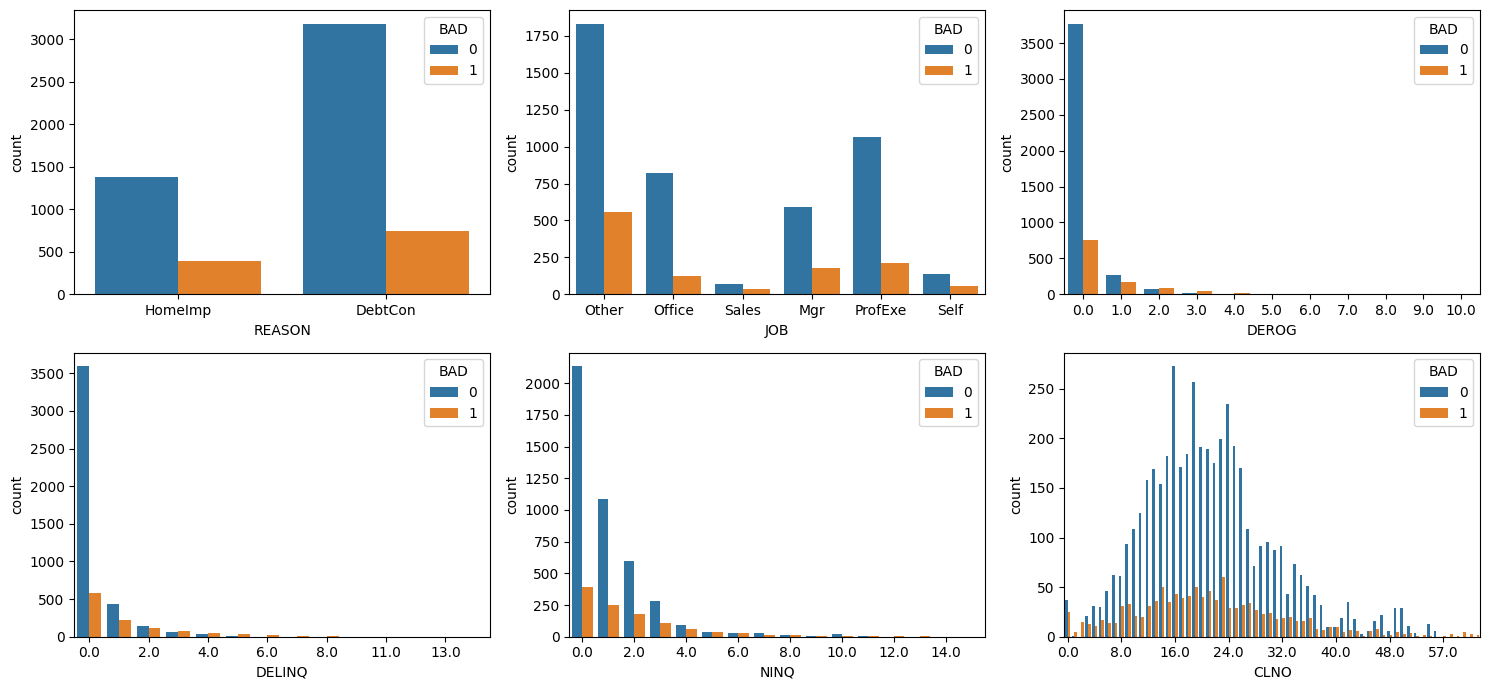

In [16]:
# Now let's plot the rest of the categorical features
univariate_plot(df=df, fun=sns.countplot, columns=cat_features, rotate=False, hue=target_feature, figsize=(15, 7), stat='count', max_xticks=8)

**Observations**
- Most loans are used for debt consolidation; however, the defaulting percentage seems relatively similar for both reasons
- Most applicants have "other" as job description; it is not obvious from the visualisation whether one of the other job category is linked to higher default rates
- Most applicants have no derogatory reports or delinquent credits 
- NINQ (number of inquiries) seems to be exponentially distributed
- CLNO (number of credit lines) seems to be normally distributed with long tails

In [17]:
# Determine the modes for later consideration in imputation
expected_values = {}
for col in nominal_features:
    expected_values[col] = df[col].mode()[0]

expected_values

{'REASON': 'DebtCon', 'JOB': 'Other'}

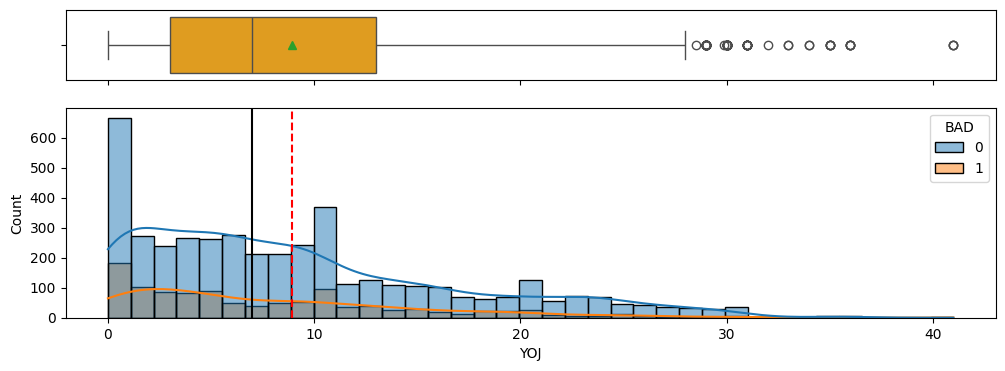

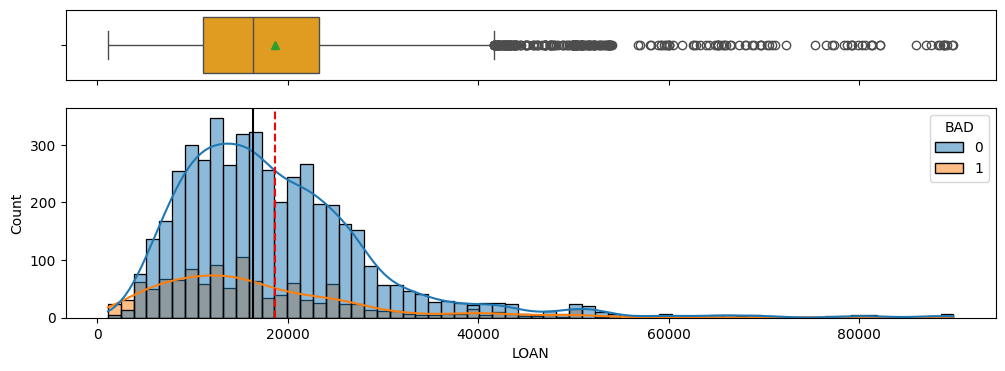

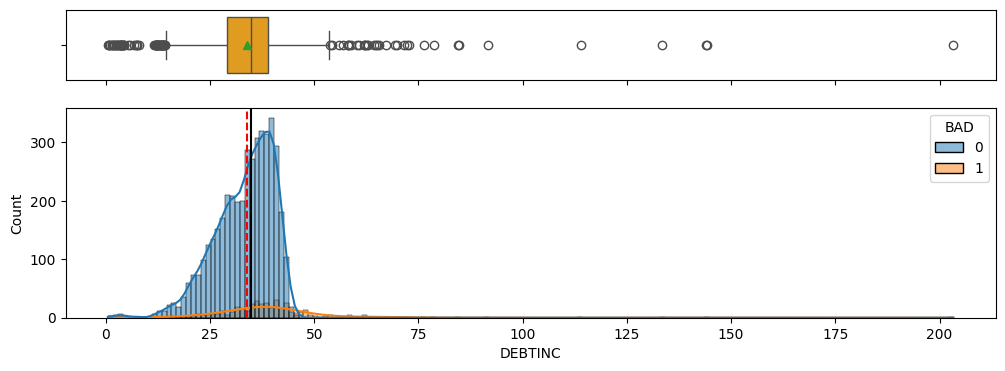

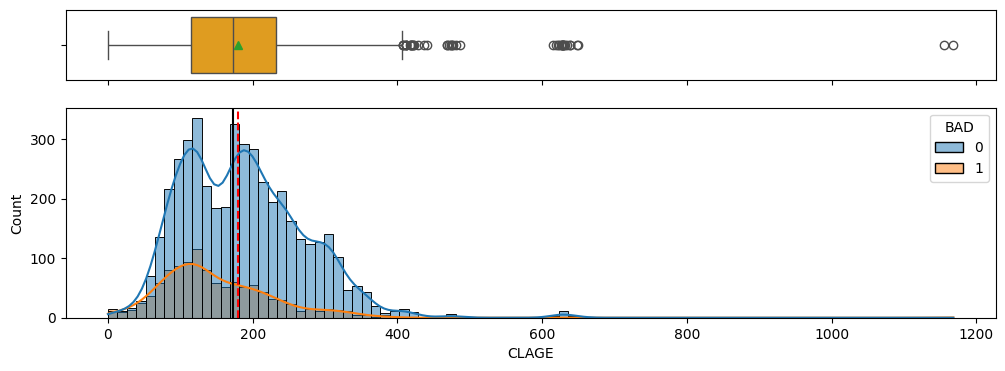

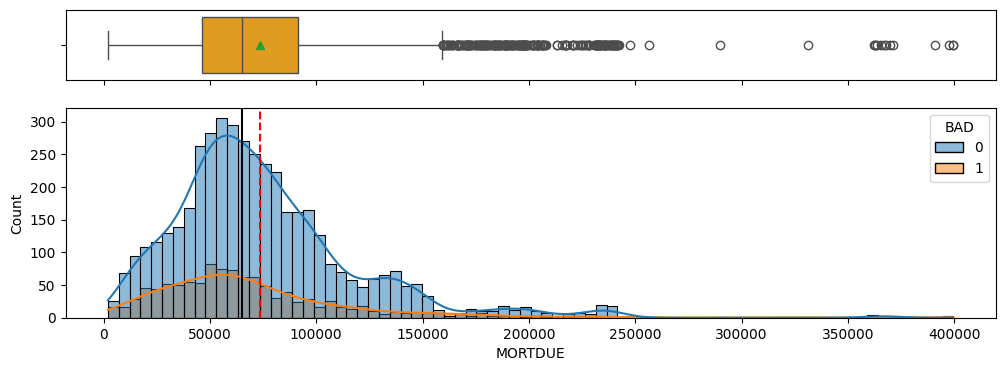

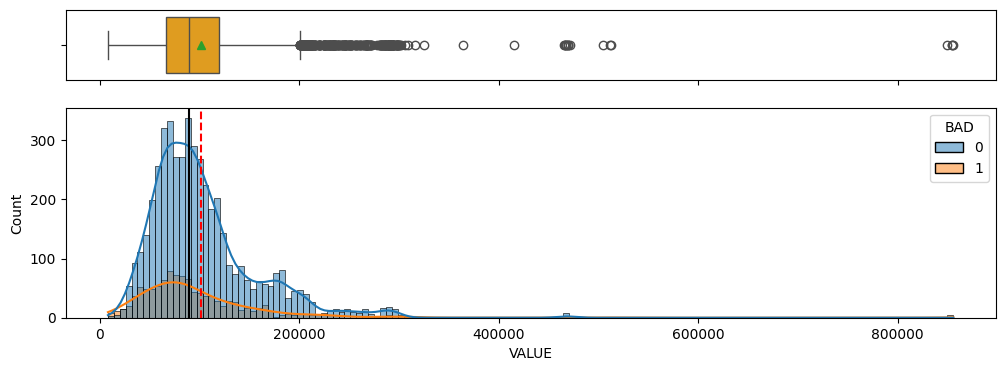

In [18]:
# Plotting numerical features
for col in num_features:
    histogram_boxplot(df, col, figsize=(12, 4), hue=target_feature, kde=True)

**Observations**

- All numerical features have outliers.
- Most are skewed, some of them heavily.
- DEROG (derogatory reports) and DELINC (delinquant action) seem to be distributed according to a power law
- CLAGE (the creditline age) is somewhat (double) Gaussian with a long tail
- DEBTINC (the debt/income ratio) might also be bi-normally distributed with a short left and a long right tail
- YOJ (years on current job) seems to be exponentially distributed
- LOAN (loan amount), MORTDUE (total mortgage due) and VALUE (value of property) seem to be normally distributed with long tails


For features that are more or less Gaussian distributed, we will attempt imputing missing values with the median (which is less affected by outliers) and map outliers to $\pm 1.5 IQR$

In [19]:
# We will keep the outlier strategy in this dictionary
outliers = {}
# Helper function
def obtain_outlier_boundaries(df:pd.DataFrame, col:str, non_negative:bool=True) -> (float, float):
    """Determines the "whiskers values" of $\pm 1.5 IQR for a given numerical column of a dataframe

    Args:
        df (pd.Dataframe, optional): The datafdrame. 
        col (str): The column to analyze
        non_negative (bool, optional): If True, the lower and upper bound will be >=0. Defaults to True.

    Returns:
        lower_bound,upper_bound (tuple): The lower whisker and the upper whisker value
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    if non_negative:
        lower_bound = max(0, q1 - 1.5 * iqr)
        upper_bound = max(0, q3 + 1.5 * iqr)
    else:
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q1 + 1.5 * iqr
    return (lower_bound, upper_bound)


In [20]:
# For those features that are nearly normally distributed, we can try to use the median to impute the missing values
# In the presence of outliers, the median is a better measure of central tendency
expected_values['CLNO']    = df['CLNO'].median()
expected_values['CLAGE']   = df['CLAGE'].median()
expected_values['LOAN']    = df['LOAN'].median()
expected_values['VALUE']   = df['VALUE'].median()
expected_values['MORTDUE'] = df['MORTDUE'].median()
# Encode the outlier strategy
outlier_strategy = {}
outlier_strategy['CLNO']    = {'type':'boundary','boundaries':obtain_outlier_boundaries(df, 'CLNO')}
outlier_strategy['CLAGE']   = {'type':'boundary','boundaries':obtain_outlier_boundaries(df, 'CLAGE')}
outlier_strategy['LOAN']    = {'type':'boundary','boundaries':obtain_outlier_boundaries(df, 'LOAN')}
outlier_strategy['VALUE']   = {'type':'boundary','boundaries':obtain_outlier_boundaries(df, 'VALUE')}
outlier_strategy['MORTDUE'] = {'type':'boundary','boundaries':obtain_outlier_boundaries(df, 'MORTDUE')}

**Checking whether NINQ and YOJ are exponentially distributed and if so calculate the expected value**

In [21]:
def exp_func(x, a, b):
    # Expoential function for use in curve_fit
    return a * np.exp(-b * x)

def fit_fn(series:pd.Series, bins:int, fun:Callable) -> Tuple[np.ndarray, pd.DataFrame]:
    # Helper function to fit an exponential function to a histogram
    y, x = np.histogram(series,bins=bins) 
    x = x[:-1].copy()
    popt, pcov = curve_fit(fun, x, y)
    y_fitted = exp_func(x, *popt)
    df = pd.DataFrame({'x':x, 'y':y, 'y_fitted':y_fitted})
    return popt,df

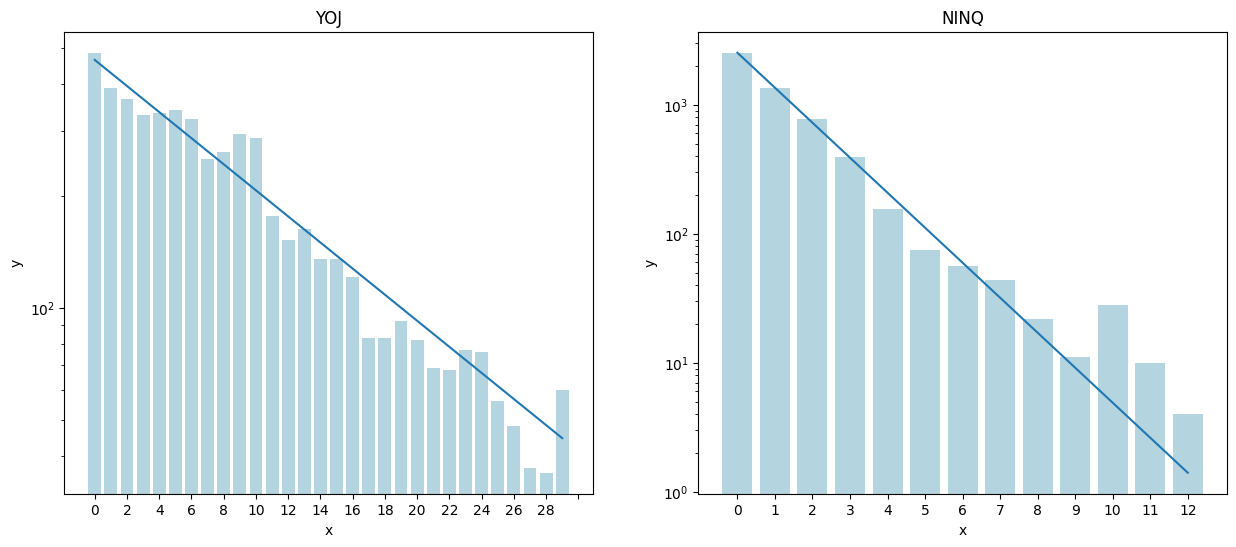

In [22]:
# Let's try to fit an exponential function to the YOJ and NINQ features
yoj_params,df_yoj = fit_fn(series=df['YOJ'], bins=np.arange(0,31,1), fun=exp_func)# cut off the bad tail
ninq_params,df_ninq = fit_fn(series=df['NINQ'], bins=np.arange(0,14,1), fun=exp_func)# cut off the bad tail
# and plot the results
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.barplot(data=df_yoj, x='x', y='y', color='lightblue', ax=axs[0])
sns.lineplot(data=df_yoj, x='x', y='y_fitted',ax=axs[0])
axs[0].set_xticks(np.arange(0,31,2))
axs[0].set_yscale('log')
axs[0].set_title('YOJ')
sns.barplot(data=df_ninq, x='x', y='y', color='lightblue', ax=axs[1])
sns.lineplot(data=df_ninq, x='x', y='y_fitted',ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('NINQ');


As suspected, YOJ and NINQ are largely exponentially distributed. The expected value of an exponentially distributed value is $\frac{1}{\lambda}$ where $\lambda$ is the rate parameter.

**NOTE**  
NINQ is a discrete variable and should in principle not tbe fitted to a continuous distribution as above. However, we are just trying to determine reasonable expected values for imputation (and the attempts to fit to discrete distributions were not quite successful)

In [23]:
# We will keep expected values for imputation
expected_values['YOJ'] = round(1/yoj_params[1],0)
expected_values['NINQ'] = round(1/ninq_params[1],0)

print(f"The expected value for YOJ is {expected_values['YOJ']:.0f} and for NINQ is {expected_values['NINQ']:.0f}")

# Setting the outlier strategy for YOJ and NINQ
outlier_strategy['YOJ'] = {'type':'boundary','boundaries':obtain_outlier_boundaries(df, 'YOJ')}
outlier_strategy['NINQ'] = {'type':'boundary','boundaries':obtain_outlier_boundaries(df, 'NINQ')}


The expected value for YOJ is 12 and for NINQ is 2


**Checking the distribution of DELINQ and DEROG**

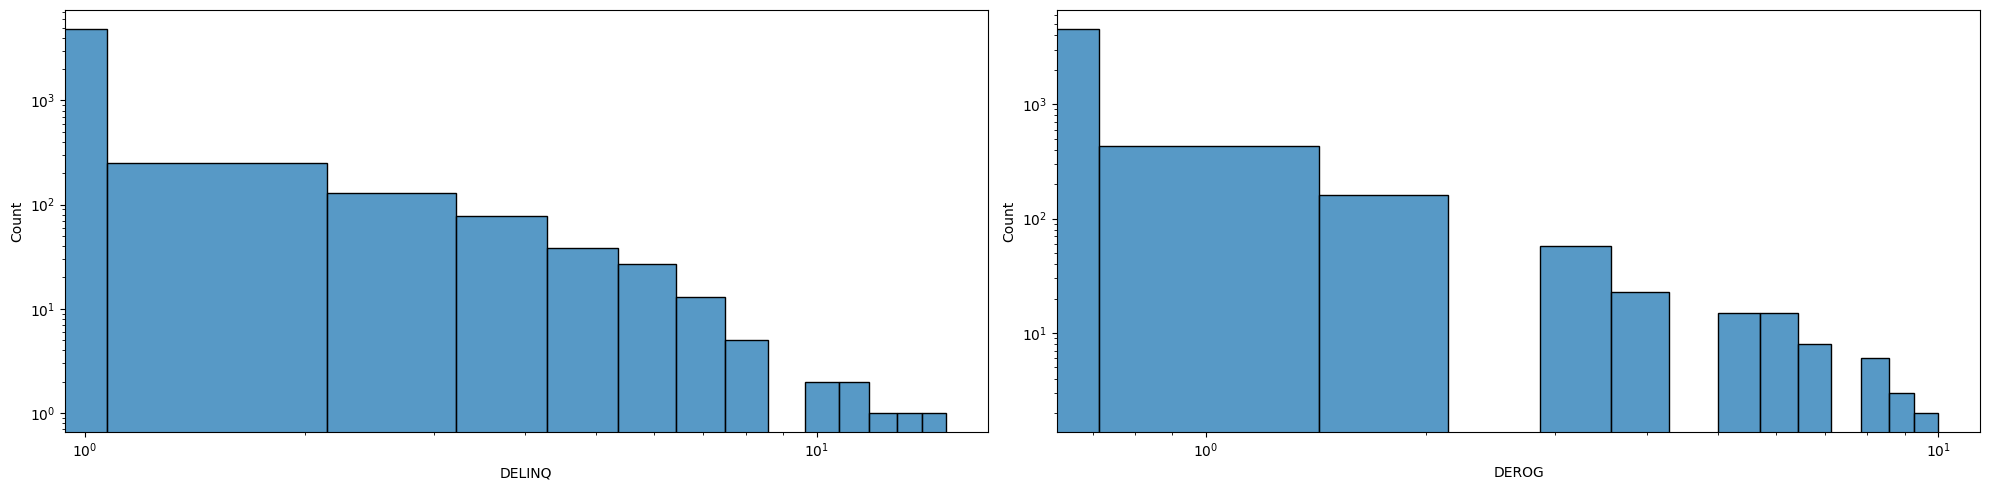

In [24]:
univariate_plot(df=df, fun=sns.histplot, columns=['DELINQ', 'DEROG'], figsize=(20, 5), rotate=False, stat='count', xlog=True, ylog=True)

It is not clear that these features really are distributed according to a power law. A necessary, but not sufficient condition is a straight line in the log-log plot which is not given here. Perhaps a different strategy to obtain an expected value is needed.

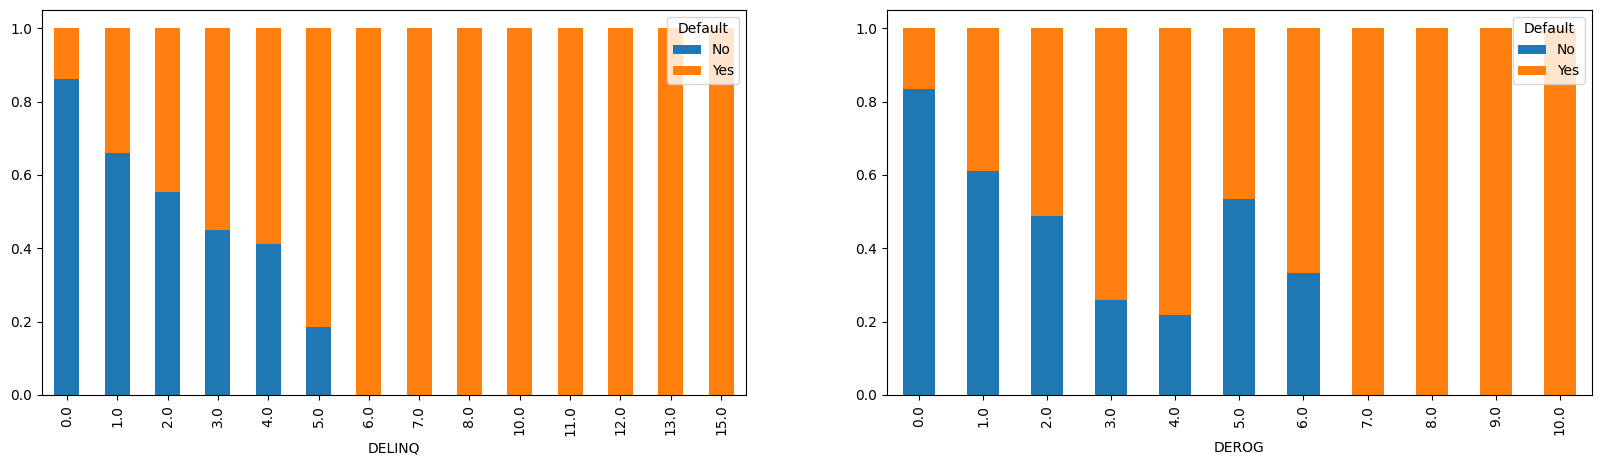

In [25]:
# Proportion of DELINQ = 0 for BAD = 0, 1
fig, axs = plt.subplots(1, 2, figsize=(20,5))
df.groupby('DELINQ')['BAD'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=axs[0])
axs[0].legend(title='Default', loc='upper right', labels=['No', 'Yes'])
df.groupby('DEROG')['BAD'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=axs[1])
axs[1].legend(title='Default', loc='upper right', labels=['No', 'Yes']);


**Observations**

Clearly the number of delinquent credit lines and to a lesser extent the derogatory reports are correlated with loan defaulting. Two strategies could be used for imputation of missing values:
- Convert the feature into a nominal categorical feature with cutoff at the feature values where most of cases are defaulting loans (for DELINQ between 2 and 3); impute missing values by looking at BAD.
- Keep the ordinal feature, eliminate outliers by mapping them to the point where the class BAD is "sure" (for DELINQ 6 and for DEROG 7) and impute missing values as (integer) weighted mean per target feature class

We will continue with the 2nd strategy in order to keep the feature as much as possible in its original form - we suspect that it will be important for classification.

In [26]:
def get_weighted_avg(df:pd.DataFrame, target_feature:str, target_values:list, groupby:str, round_to:int=0) -> pd.DataFrame:
  """Calculates the weighted average for a given groupby feature and a target feature class

  Args:
      df (pd.DataFrame): The dataframe
      target_feature (str): target feature
      target_values (list): Values of the target feature
      groupby (str): the grouping features
      round_to (int, optional): Rounding. Defaults to 0.

  Returns:
      pd.DataFrame: Dataframe with the weighted averages
  """
  vcs = pd.DataFrame(df.groupby(groupby)[target_feature].value_counts())
  if not 'count' in vcs.columns:
    vcs.rename(columns={target_feature:'count'},inplace=True)
  vcs = vcs.reset_index()
  vcs['WM'] = vcs[groupby]*vcs['count']
  weighted_avgs ={}
  for val in target_values:
      weighted_avgs[val] = round(vcs[vcs[target_feature]==val]['WM'].sum()/vcs[vcs[target_feature]==val]['count'].sum(),round_to)
  return weighted_avgs

expected_values['DELINQ'] = get_weighted_avg(df, target_feature, [0, 1], 'DELINQ')
expected_values['DEROG']  = get_weighted_avg(df, target_feature, [0, 1], 'DEROG')

# and now the outlier strategy
outlier_strategy['DELINQ'] = {'type':'boundary','boundaries':(0,6)}
outlier_strategy['DEROG'] = {'type':'boundary','boundaries':(0,7)}

Now let's analyse the debt-to-income ratio per class

The median DEBTINC for BAD=0 is 34.54 and for BAD=1 is 38.08


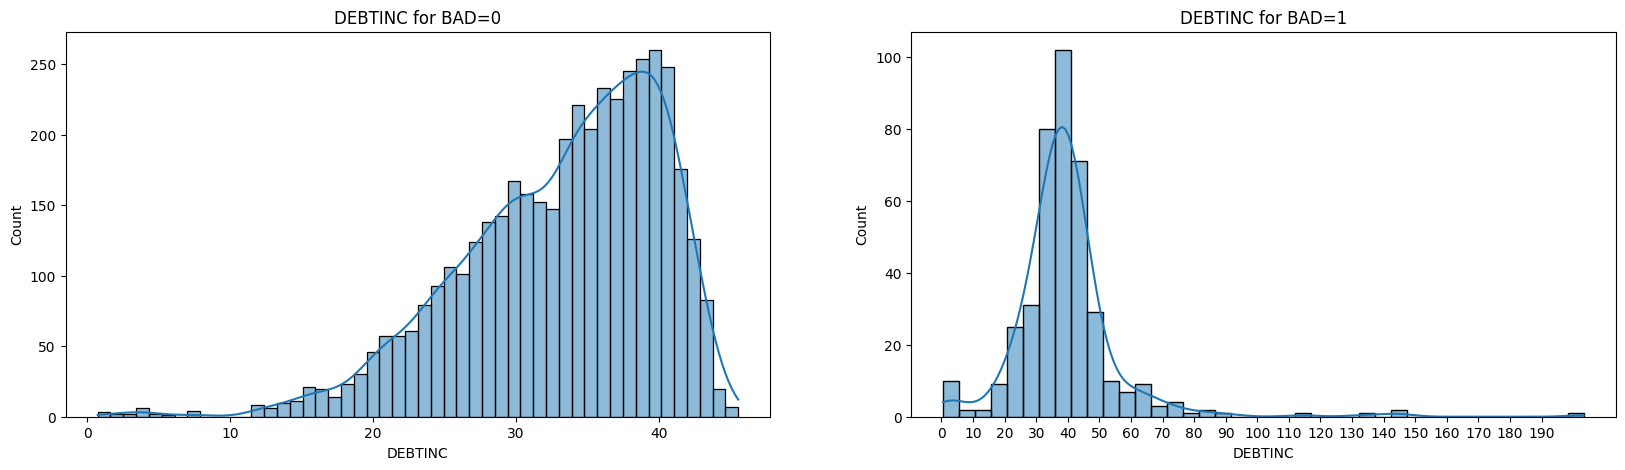

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(data=df[df.BAD==0],x='DEBTINC',bins=50, kde=True, stat='count', ax=axs[0])
axs[0].set_title('DEBTINC for BAD=0')
sns.histplot(data=df[df.BAD==1],x='DEBTINC',bins=40, kde=True, stat='count', ax=axs[1])
axs[1].set_xticks(np.arange(0,200,10))
axs[1].set_title('DEBTINC for BAD=1');

median_debtinc_bad = df[df.BAD==0]['DEBTINC'].median()
median_debtinc_rep = df[df.BAD==1]['DEBTINC'].median()
print(f"The median DEBTINC for BAD=0 is {median_debtinc_bad:.2f} and for BAD=1 is {median_debtinc_rep:.2f}")

As can be seen the distribution for repaid loans and for defaulting loans is very different. For repaying loans, one might see a bi-gaussian distribution with means around 30% and 40%. For defaulting loans we seem to have Gaussian with a debt/income ratio of about 40%. Given that the median is 35%, it is probably the best strategy for imputation to use that value. For outliers, it would seem that mapping them to $\pm 1.5 IQR$ is the correct strategy.

In [28]:
expected_values['DEBTINC'] = df['DEBTINC'].median()
outlier_strategy['DEBTINC'] = {'type':'boundary','boundaries':obtain_outlier_boundaries(df, 'DEBTINC')}

In [29]:
# Let's control the outlier strategy
outlier_strategy

{'CLNO': {'type': 'boundary', 'boundaries': (0, 42.5)},
 'CLAGE': {'type': 'boundary', 'boundaries': (0, 406.23064200499994)},
 'LOAN': {'type': 'boundary', 'boundaries': (0, 41600.0)},
 'VALUE': {'type': 'boundary', 'boundaries': (0, 200447.375)},
 'MORTDUE': {'type': 'boundary', 'boundaries': (0, 159306.0)},
 'YOJ': {'type': 'boundary', 'boundaries': (0, 28.0)},
 'NINQ': {'type': 'boundary', 'boundaries': (0, 5.0)},
 'DELINQ': {'type': 'boundary', 'boundaries': (0, 6)},
 'DEROG': {'type': 'boundary', 'boundaries': (0, 7)},
 'DEBTINC': {'type': 'boundary',
  'boundaries': (14.345367488000003, 53.79780451199999)}}

### **Bivariate Analysis**

In [30]:
# Helper functions
# Function to plot stacked bar plots
def stacked_barplot(ax:plt.Axes, data: pd.DataFrame, predictor:str, target:str, print_tab:bool=False, sorted:bool=True, max_xticks:int=10):
    """Plots a stacked bar plot for a given predictor and target

    Args:
        ax (plt.Axes): Axes object to plot in
        data (pd.DataFrame): Dataframe
        predictor (str): Predictor column
        target (str): Target column
        print_tab (bool, optional): If true prints the crosstab on stdout. Defaults to False.

    Returns:
        plt.Axes: a stacked bar plot
    """
    if print_tab:
        tab1 = pd.crosstab(data[predictor], data[target], margins = True)
        if sorted:
            tab1= tab1.sort_values(by = sorter, ascending = False)
        print(tab1)
        print("-" * 120)

    tab = pd.crosstab(data[predictor], data[target], normalize = "index")
    if sorted:
        sorter = data[target].value_counts().index[-1]
        tab = tab.sort_values(by = sorter, ascending = False)
    tab.plot(kind = "bar", stacked = True, ax=ax)
    # Adjust number of ticks if necessary
    ticks = ax.xaxis.get_ticklocs()
    if len(ticks) > max_xticks:
        factor = int((len(ticks) / max_xticks)+0.5)
        ticklabels = [i.get_text() for i in ax.xaxis.get_ticklabels()]
        ax.xaxis.set_ticks(ticks[::factor])
        ax.xaxis.set_ticklabels(ticklabels[::factor])
    return ax

def plot_cat_vars(df:pd.DataFrame(), columns:list=None, target='status', figsize:tuple=(20, 15), sorted:bool=True, rotate:bool=False):
    """Plots categorical variables as stacked bar plots in grid with 3 columns

    Args:
        df (pd.DataFrame): Dataframe
        columns (list, optional): Columns to plot. Defaults to None.
        target (str, optional): Target column. Defaults to 'status'.
        figsize (tuple, optional): Figure size. Defaults to (20, 15).
        rotate (bool, optional): If true rotates the x tickmarks. Defaults to False.
    """
    # We should really check whether fun is a valid sns function, but maybe that's too much for now
    if not columns:
        columns = df.select_dtypes(include='object').columns
    # First let's find the numerical columns
    nfig = len(columns)
    # In order to represent them better, let's plot them in 3 columns
    ncols = 3
    cols=min(3,nfig)
    # Now we need to determine how many rows we need
    rows, rest = divmod(nfig, cols)
    # Incomplete rows are still rows...
    rows += 1 if rest>0 else 0

    # And now we can plot
    f, axes = plt.subplots(rows,cols, figsize=figsize)
    for ax,feature in zip(axes.flat,columns):
        plot = stacked_barplot(ax, df, feature , target, sorted=sorted)
        xticks = plot.get_xticklabels()
        # while len(xticks) > 12:
        #     xticks = xticks[::2]
        rotation = 90 if rotate else 0
        plot.set_xticklabels(xticks, rotation=rotation)
    if rows>1:
        for i in range(rest+1):
            axes[rows-1,ncols-1-i].set_visible(False)
    f.tight_layout()

#### Categorical features and their relation to the target feature

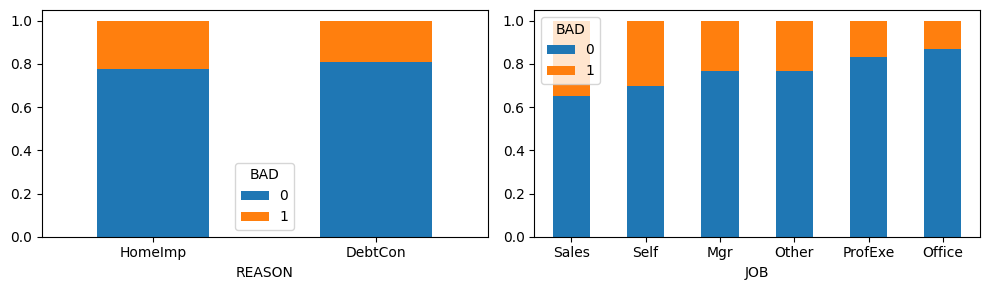

In [31]:
# Now let's plot all categorical features against the target feature 'status'
plot_cat_vars(df, nominal_features, 'BAD', figsize=(10, 3))

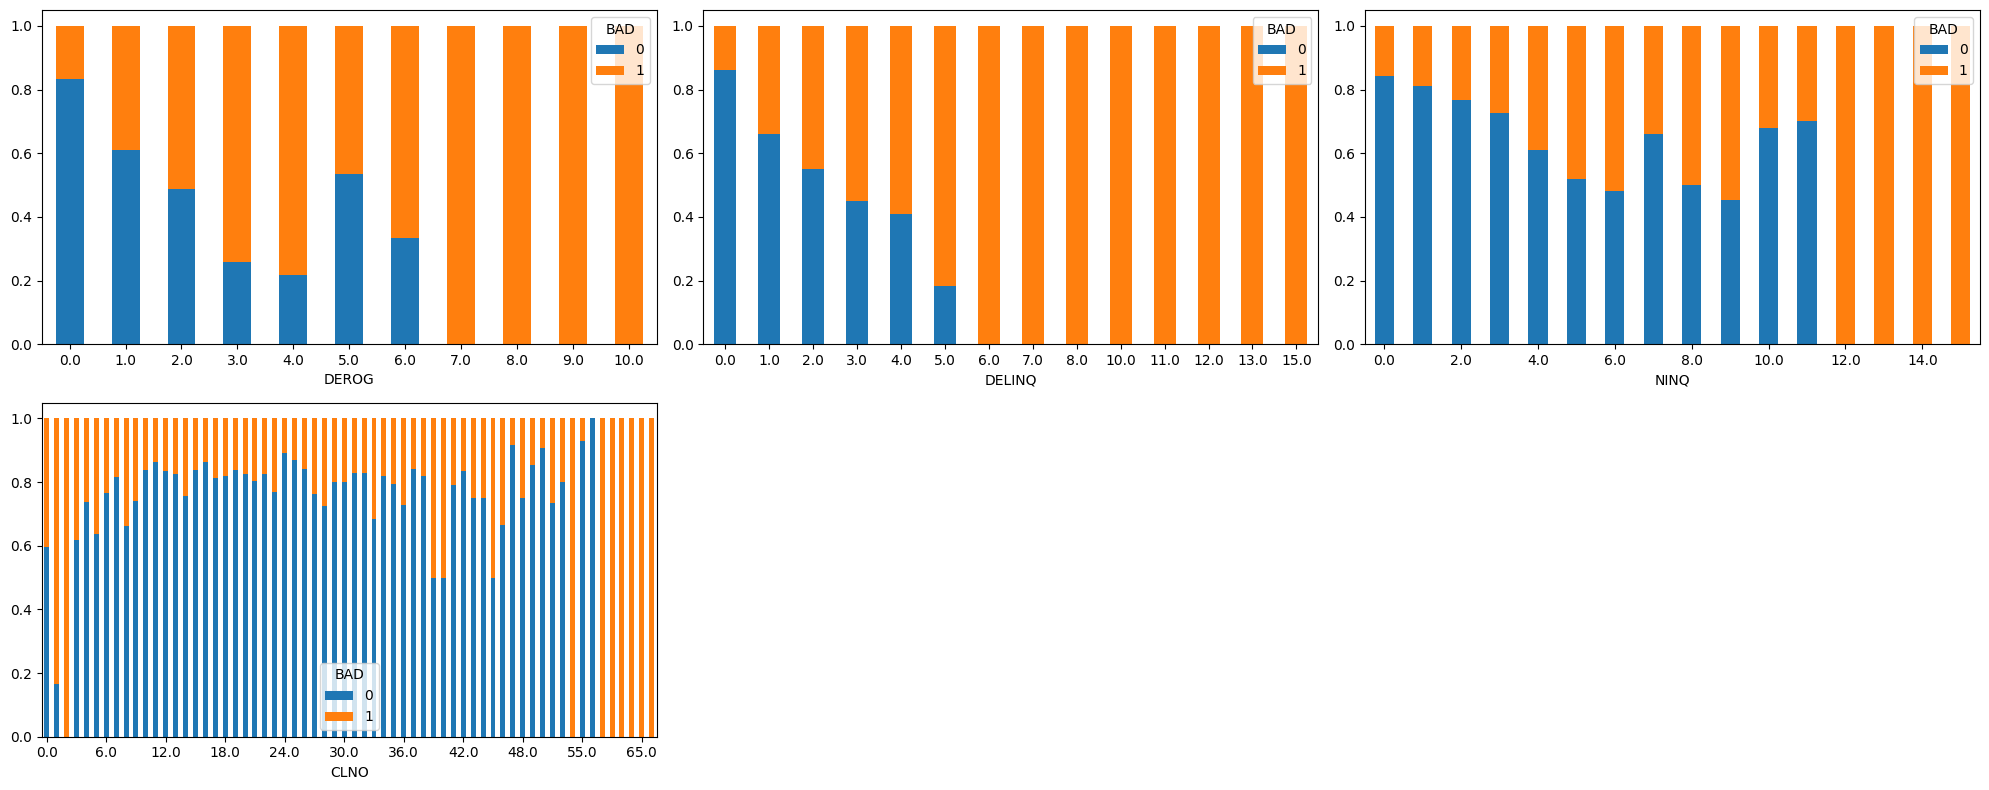

In [32]:
# Now let's plot all categorical features against the target feature 'status'
plot_cat_vars(df, ordinal_features, 'BAD', figsize=(20,8), sorted=False)

**Observations**
- The proportion of BAD loans is slightly higher for home improvement loans.
- Sales persons have the highest proportion of BAD loans, followed by professionals and managers 
- DEROG and DELINQ were discussed above
- NINQ has a cutoff of >11 inquieries. From that point onwards, all loans are BAD. Perhaps a better outlier definition in (0,12) instead of (0,5)
- Very high values or very low values of credit lines are consistent with defaulting loans

In [33]:
outlier_strategy['NINQ'] = {'type':'boundary','boundaries':(0,12)}

#### Numerical features and their relation to the target feature

Stat parameter is not available in this version of seaborn. It will be ignored.


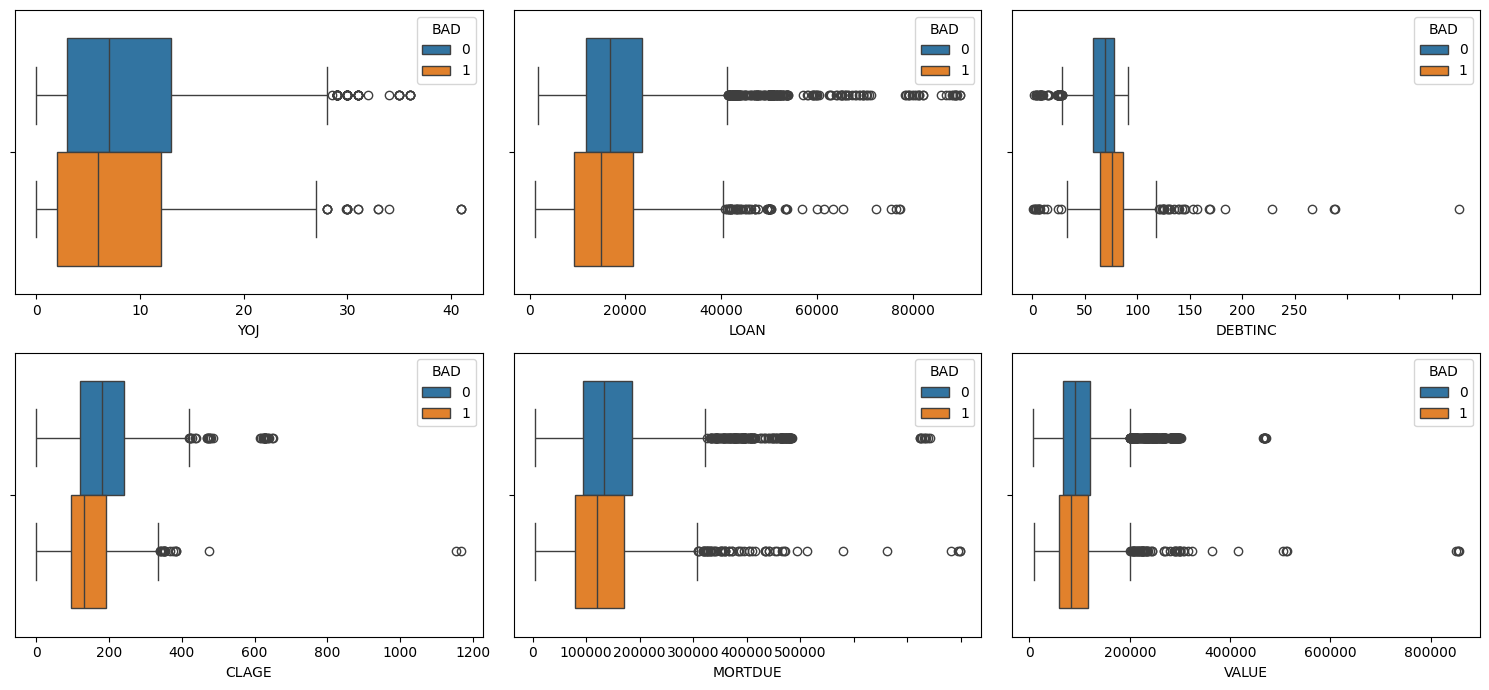

In [34]:
# Now let's plot the rest of the categorical features
univariate_plot(df=df, fun=sns.boxplot, columns=num_features, rotate=False, hue=target_feature, figsize=(15, 7), stat=None)

**Observations:**  
Loan defaulters have on median
- smaller, younger loans
- less mortgage due
- a lower debt income ratio
- lower value property
- less years on their current job  
We will investigate the statistical significance of these statements further below.

#### Correlation between categorical features

Nominal features

In [35]:
cm = pd.crosstab(df['REASON'], df['JOB'])
phi = association(cm, method='cramer')
print(f"The phi coefficient for REASON and JOB is {phi:.2f}")

The phi coefficient for REASON and JOB is 0.15


A low value of the Cramer's V test indicates little or no association between the features. Such variables can be assumed to be independent.

Ordinal features

To calculate the correlation between ordinal features the spearman correlation is used.

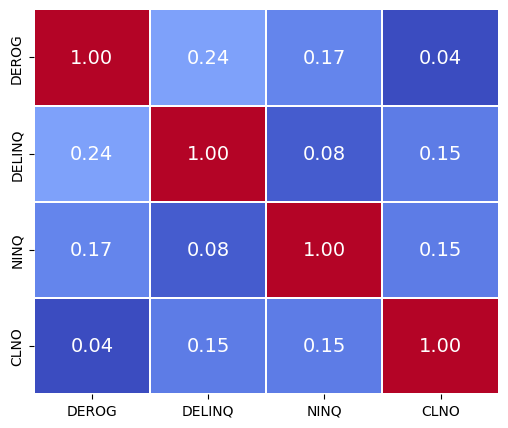

In [36]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[ordinal_features].corr(method='spearman'), annot=True, cmap='coolwarm', cbar=False, fmt='.2f', linewidths=0.2, annot_kws={'size': 14});

None of the ordinal features are closely correlated.

#### Correlation between numerical features

The task is to check whether some of the numerical features are strongly correlated. If there is strong correlation between features they would need to be reduced.

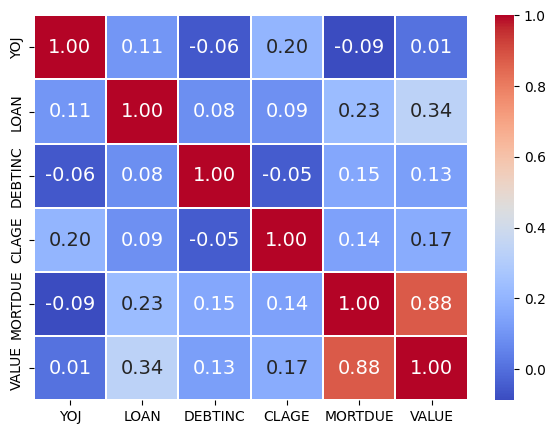

In [37]:
# Plotting the correlation matrix
plt.figure(figsize=(7, 5))
sns.heatmap(df[num_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.2, annot_kws={'size': 14});

From the Pearson correlation matrix, we learn:
 - There is a strong correlation between the mortage due and the value of the property. Having both features will affect the quality of the regression. If we wanted to use the regression coefficients to understand the importance of features, we should remove one of the columns. However, decision trees are not affected by multicolinearity and therefore there is no need to remove the feature.
 - There are no strong correlations between the other numerical variables
 - The strongest correlations are between (none of them exceed 0.23)
    - LOAN and VALUE (indicating that there are properties which are largely financed by loans)
    - LOAN and MORTDUE (so higher willingness to indebt oneself is correlated with high loan amount)
    - CLAGE and YOJ (so keeping the same job is correlated with the age of the credit line - possibly indicating that people stay in their jobs to pay back the loans) 

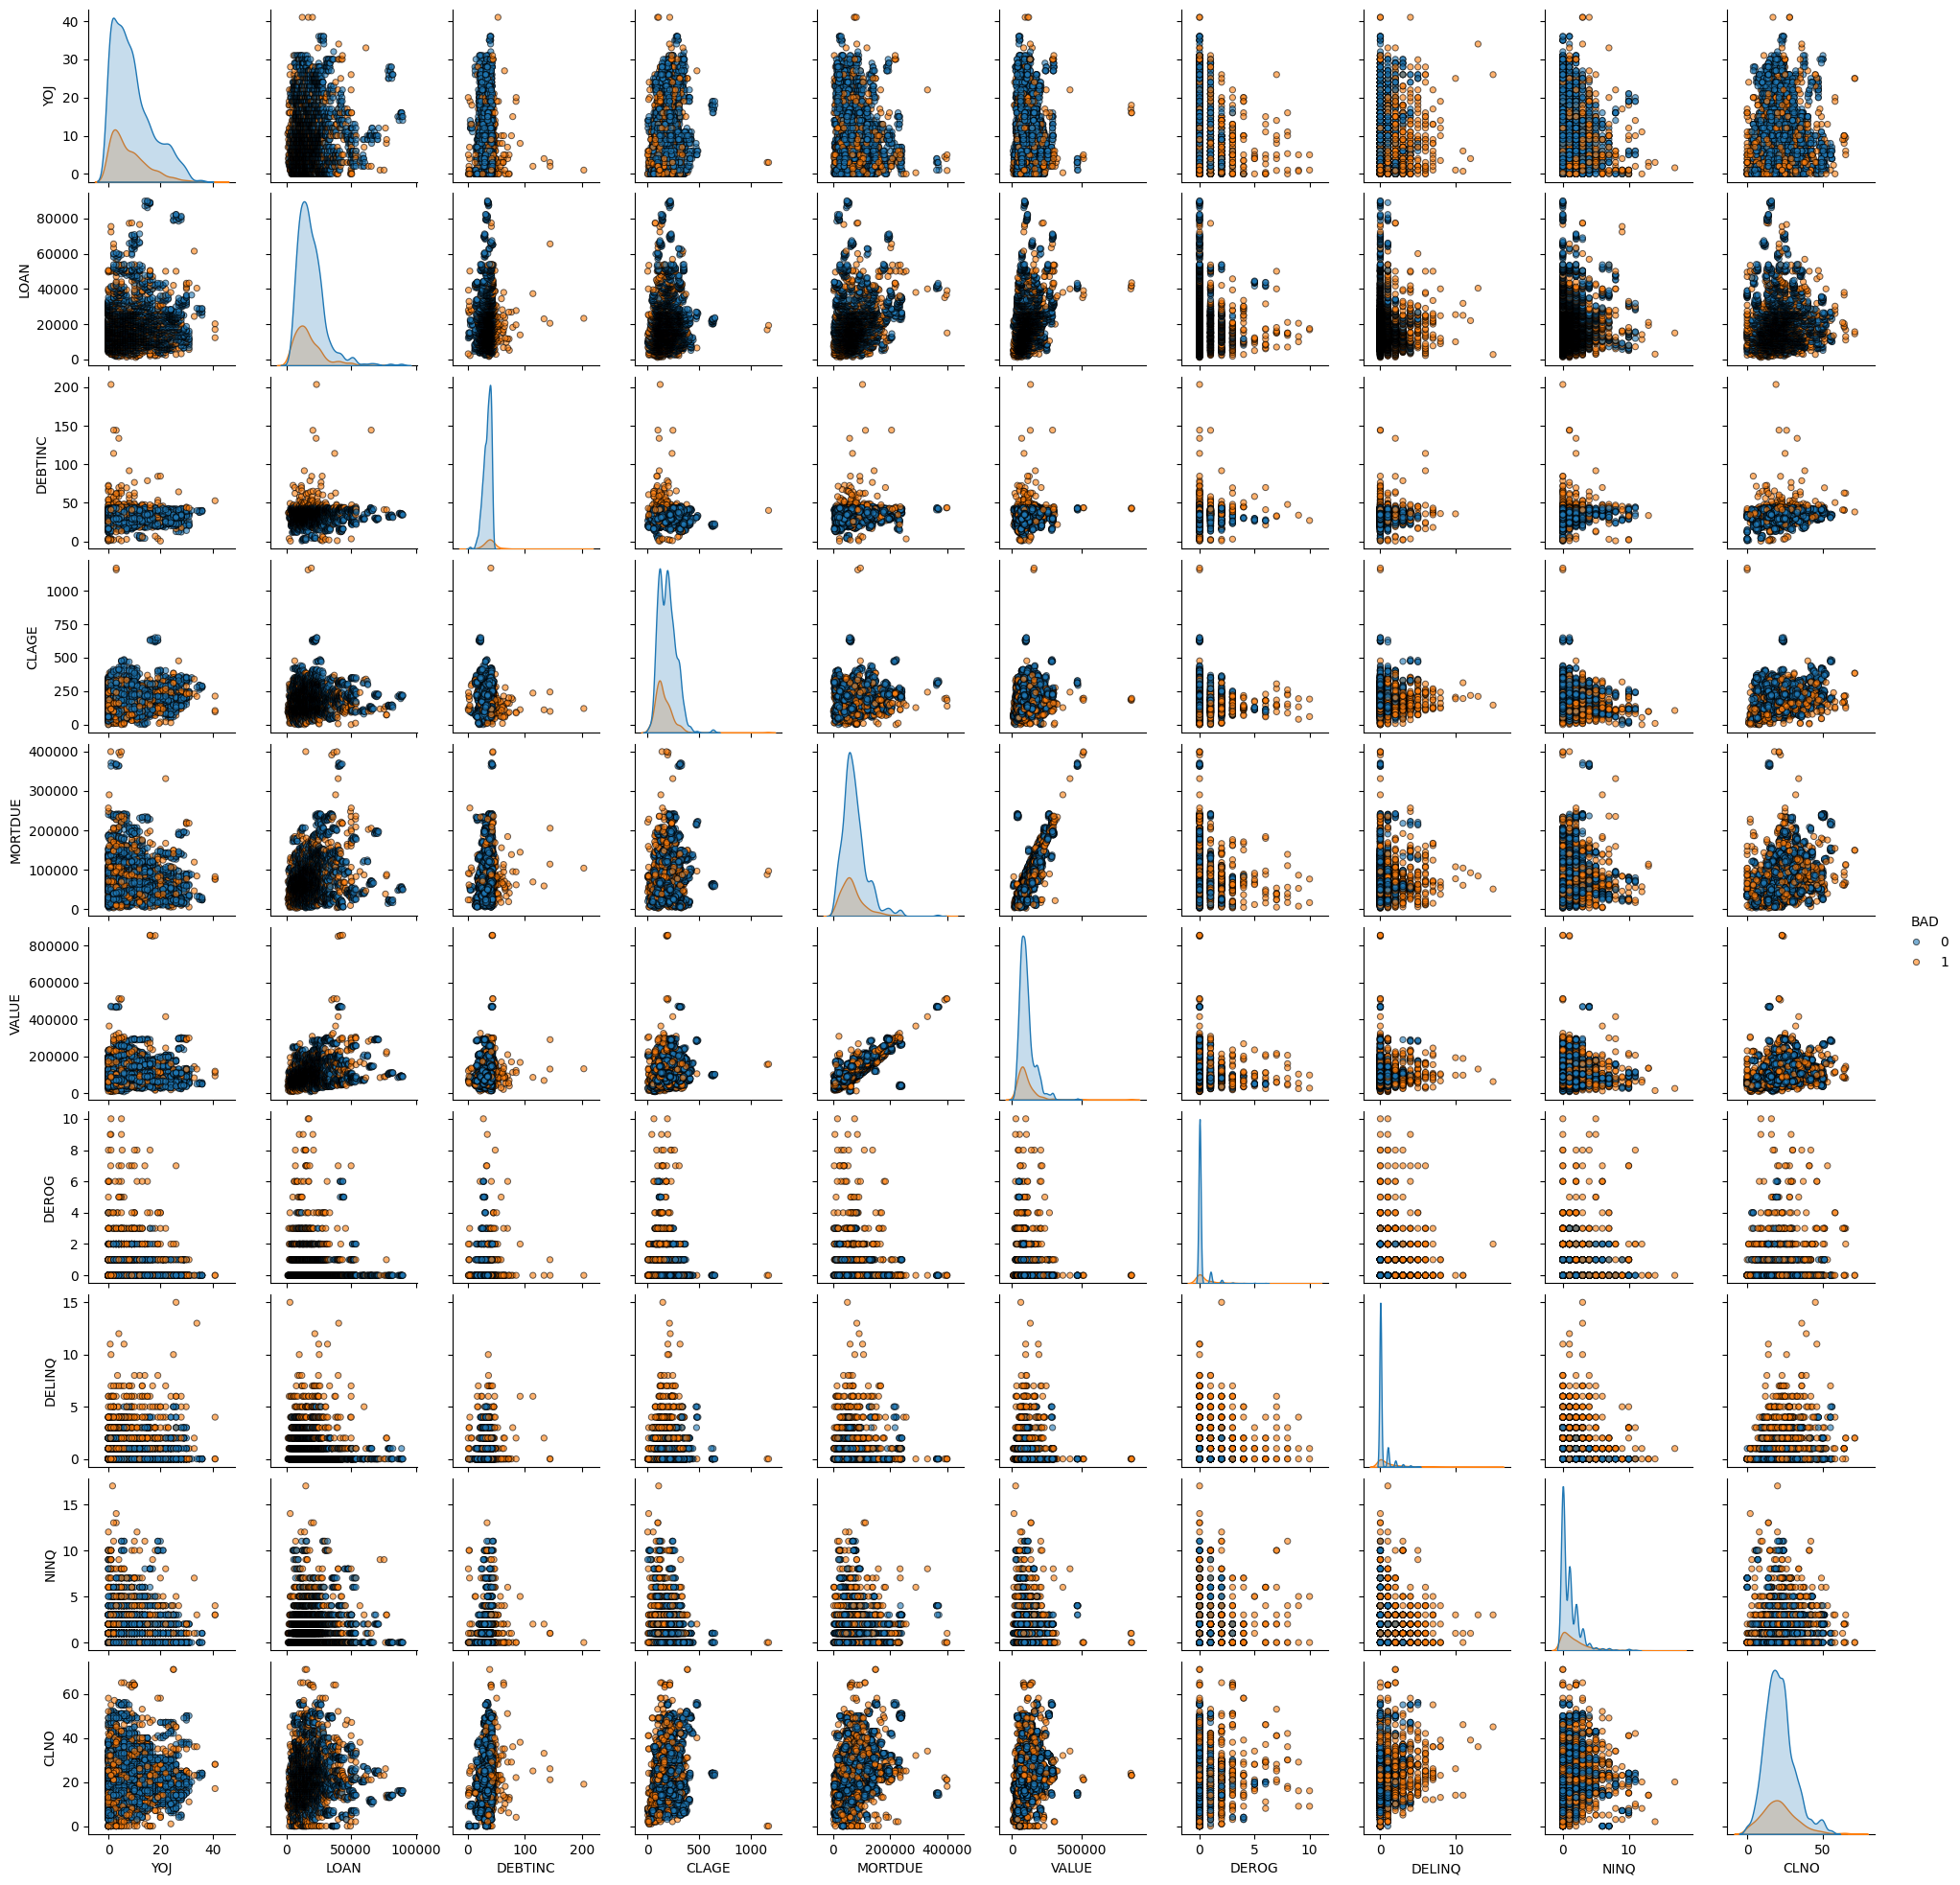

In [38]:
sns.pairplot(data=df, vars=num_features+ordinal_features, hue=target_feature, diag_kind='kde', dropna=True, markers = '.',
             plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'}, height=2);

**Observations**

- Loan amount and total mortgage are the only features that are obviously correlated
- We can confirm the other correlations from the Pearson correlation, but clearly the weak correlations we observed before are difficult to identify visually
- Given that these correlations are not particularly strong, there is no need to reduce the number of features at this stage.

#### Checking the statistical relevance of features for the target feature

The task is to detect whether some features do not contribute to the variance of the target features.

##### Categorical features   
We will use a chi2 test for categorical features (nominal and ordinal)

In [39]:
# Check the correlation of the categorical features with the target using a chi-squared test
def find_significant_features_chi2(df:pd.DataFrame, target_feature:str='BAD', min_freq:int=5) -> List[str]:
    """Find significant features using a chi-squared test

    Args:
        df (pd.DataFrame): Dataframe with the data

    Returns:
        List: List of significant features
    """
    significant_features = []
    for col in df.columns:
        if col != target_feature:
            contingency_table = pd.crosstab(df[col], df[target_feature])
            # Check that the frequency is not too low
            if contingency_table.min().min() < min_freq:
                print(f"***WARNING*** The contingency table for {col} has cells with frequency less than {min_freq}")
            _, p, _, _ = chi2_contingency(contingency_table)
            if p < 0.05:
                significant_features.append(col)
    return significant_features

In [40]:
# Let's check the significant features with the chi2 test
significant_cat_features = find_significant_features_chi2(df[cat_features+['BAD']], target_feature)
print(f"According to the chi2 test, the significant categorical features are: {significant_cat_features}")

non_significant_cat_features = list(set(cat_features) - set(significant_cat_features))
print(f"According to the chi2 test, the non-significant categorical features are: {non_significant_cat_features}")

***WARNING*** The contingency table for DEROG has cells with frequency less than 5
***WARNING*** The contingency table for DELINQ has cells with frequency less than 5
***WARNING*** The contingency table for NINQ has cells with frequency less than 5
***WARNING*** The contingency table for CLNO has cells with frequency less than 5
According to the chi2 test, the significant categorical features are: ['REASON', 'JOB', 'DEROG', 'DELINQ', 'NINQ', 'CLNO']
According to the chi2 test, the non-significant categorical features are: []


**Observations:**
- All categorical features seem statistically relevant for the target feature
- As we have seen above in the univariate analysis, for the four ordinal features DEROG, DELINQ, NINQ and CLNO, there is a limit beyond which there are no loans repaid. Therefore the validity of the chi2 test is not given. However, the mere presence of such a limit already seems to indicate a significant relation with loan defaulting.

##### Numerical features   
As we have seen above none of the features are really normally distributed, so conducting a t-test is not appropriate. Therefore we will conduct a Mann-Whitney U test.

In [41]:
def find_significant_features_mwu(df:pd.DataFrame, target_feature:str='BAD') -> List[str]:
    """Find significant numerical features using the Mann-Whitney U test
    """
    significant_features = []
    for col in df.columns:
        if col != target_feature:
            _, p = mannwhitneyu(df[df[target_feature]==0][col], df[df[target_feature]==1][col])
            if p < 0.05:
                significant_features.append(col)
    return significant_features

In [42]:
# Apply Mann-Whitney U test for the numerical features
significant_num_features = find_significant_features_mwu(df[num_features+['BAD']], target_feature)
print(f"According to the Mann Whitney U test, the significant numerical features are: {significant_num_features}")

non_significant_num_features = list(set(num_features) - set(significant_num_features) - set([target_feature]))
print(f"According to the Mann Whitney U test, the non-significant numerical features are: {non_significant_num_features}")

According to the Mann Whitney U test, the significant numerical features are: ['LOAN']
According to the Mann Whitney U test, the non-significant numerical features are: ['YOJ', 'DEBTINC', 'CLAGE', 'MORTDUE', 'VALUE']


**Observations:**

- Only LOAN was identified as statistically significant for loan defaulting. 
- However, as all statistical tests, there are certain assumptions and limitations.

In [43]:
significant_features = significant_cat_features + significant_num_features

In [44]:
significant_features

['REASON', 'JOB', 'DEROG', 'DELINQ', 'NINQ', 'CLNO', 'LOAN']

### **Multivariate Analysis**

In [45]:
# Helper function for data set encoding.
def encode_data(df:pd.DataFrame, nominal_features:List[str], ordinal_features:List[str], num_features:List[str], drop_first:bool=True, encode_boolean: bool=True,
                encoders:Optional[dict]=None) -> pd.DataFrame:
    """Encode the data in the dataframe

    Args:
        df (pd.DataFrame): Dataframe with the data
        nominal_features (List[str]): List of nominal features
        drop_first (bool, optional): Drop the first column of the one-hot encoding. Defaults to True.
        ordinal_features (List[str]): List of ordinal features
        num_features (List[str]): List of numerical features
        encoders (Optional[dict], optional): Dictionary with the encoders. Defaults to None.

    Returns:
        pd.DataFrame: Dataframe with the encoded data
    """
    if not encoders:
        encoders = {}
    # For nominal we will use the OneHotEncoder
    if nominal_features:
        for col in nominal_features:
            if encoders.get(col): # If we have already encoded this column, skip to the next
                continue
            # We will not drop the first feature as for tree models it is not necessary
            enc = OneHotEncoder(drop=None)
            enc_cols = enc.fit_transform(df[col].values.reshape(-1,1)).toarray()
            df[enc.categories_[0][0:]] = enc_cols
            df.drop(columns=[col], inplace=True)
            # If the is done with missing values, we'll get a 'nan' column (which is not a string)
            if any([np.isnan(item) for item in enc.categories_[0] if not isinstance(item,str)]):
                df.drop(columns=[np.nan], inplace=True)
            # nan is not a string, so we can filter the categories by that
            real_cats = [item for item in enc.categories_[0] if isinstance(item,str)]
            # Drop first but making sure that nan is not counted
            if drop_first:
                df.drop(columns=real_cats[0], inplace=True)
            encoders[col] = enc

    # For ordinal we will use the OrdinalEncoder
    if ordinal_features:
        for col in ordinal_features:
            if encoders.get(col): # If we have already encoded this column, skip to the next
                continue    
            enc = OrdinalEncoder()
            df[col] = enc.fit_transform(df[col].values.reshape(-1,1))
            encoders[col] = enc

    # Finally the numerical features will be scaled using the MinMaxScaler
    if num_features:
        for col in num_features:
            if encoders.get(col): # If we have already encoded this column, skip to the next
                continue
            enc = MinMaxScaler()
            df[col] = enc.fit_transform(df[col].values.reshape(-1,1))

    if encode_boolean:
        # Now let's encode the boolean features with LabelEncoders.
        for col in df.select_dtypes(include=['bool']).columns:
            if encoders.get(col): # If we have already encoded this column, skip to the next
                continue
            enc = LabelEncoder()
            df[col] = enc.fit_transform(df[col].values.reshape(-1,1))
            encoders[col] = enc
    return df, encoders

#### First characterisation of defaulting loans using PCA  

We will try to find some characteristics of the loan defaulting class.

*NOTE*: PCA requires us to encode the features and scale them. Here a StandardScaler is used. 

In [46]:
# Create a clean data set by dropping the missing values; we will use this only for initial exploration
df_clean = df.dropna()
# Endcode the data for PCA
df_clean, encoders = encode_data(df_clean, nominal_features=nominal_features, ordinal_features=ordinal_features, num_features=None, 
                                 drop_first=False, encode_boolean=False, encoders=None)
# Separate the features from the target
X = df_clean.drop(columns=[target_feature])
y = df_clean[target_feature]

# Use the MinMaxScaler to scale all features
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X), columns = X.columns)
# Check the final result
X.sample(10)

LOAN   MORTDUE     VALUE       YOJ     DEROG    DELINQ     CLAGE  \
122  -1.172948 -0.407256 -0.598050 -0.804471 -0.253434  0.894985 -0.660549   
3102  1.273299  0.624822  0.818650  0.775431 -0.253434 -0.345530  0.564111   
2936  0.850264  1.653062  1.551708 -1.199446 -0.253434 -0.345530 -0.092901   
1321 -0.400449 -0.763886 -1.033814 -0.672812 -0.253434 -0.345530  1.072114   
2736  0.647943  2.506226  2.453442 -0.014520 -0.253434 -0.345530 -1.011139   
2287  0.224908 -0.683733 -0.582407 -0.936129 -0.253434  0.894985  0.595099   
1261 -0.437234 -1.225444 -1.197264 -0.014520 -0.253434 -0.345530 -0.725476   
2701  0.620353  0.947364  0.863058 -0.146178 -0.253434 -0.345530 -0.964222   
1296 -0.409645 -1.018962 -1.156913 -0.014520 -0.253434  0.894985 -1.130569   
1467 -0.317681 -0.257817 -0.260039 -1.199446 -0.253434 -0.345530 -0.025403   

          NINQ      CLNO   DEBTINC   DebtCon   HomeImp       Mgr    Office  \
122  -0.670282 -0.010150 -0.676597 -1.543018  1.543018  2.544711 -0.455008   
3102 -0.670282  1.922613  1.024656  0.648081 -0.648081 -0.392972 -0.455008   
2936 -0.024014 -0.654405  0.931772 -1.543018  1.543018 -0.392972 -0.455008   
1321 -0.024014  1.385735  0.549976  0.648081 -0.648081 -0.392972 -0.455008   
2736  0.622254  0.311977  0.776990  0.648081 -0.648081 -0.392972 -0.455008   
2287 -0.670282 -1.191284 -0.085289  0.648081 -0.648081 -0.392972  2.197762   
1261 -0.670282 -1.298659 -1.637278  0.648081 -0.648081  2.544711 -0.455008   
2701  1.268522  0.419353 -0.193334  0.648081 -0.648081 -0.392972 -0.455008   
1296  0.622254 -1.083908 -0.595016 -1.543018  1.543018 -0.392972 -0.455008   
1467 -0.670282  0.204601 -1.307054  0.648081 -0.648081 -0.392972  2.197762   

         Other   ProfExe    Sales      Self  
122  -0.786679 -0.603909 -0.12652 -0.174131  
3102  1.271166 -0.603909 -0.12652 -0.174131  
2936 -0.786679 -0.603909 -0.12652  5.742804  
1321 -0.786679  1.655879 -0.12652 -0.174131  
2736  1.271166 -0.603909 -0.12652 -0.174131  
2287 -0.786679 -0.603909 -0.12652 -0.174131  
1261 -0.786679 -0.603909 -0.12652 -0.174131  
2701 -0.786679  1.655879 -0.12652 -0.174131  
1296  1.271166 -0.603909 -0.12652 -0.174131  
1467 -0.786679 -0.603909 -0.12652 -0.174131

In [47]:
def color_high(val):
    """Helper function to color values a dataframe

    Args:
        val : Cell value

    Returns:
        A color
    """
    if val < -0.25:                     # You can decide any value as per your understanding
        return 'background: pink'
    elif val > 0.25:
        return 'background: skyblue'
        
def execute_PCA(data: pd.DataFrame, explain_limit:float=0.7, max_components:int=-1, random_state:int=42):
    """Conducts a PCA analysis and returns the PCA dataframe and the components dataframe

    Args:
        X_wrong (pd.DataFrame): feature dataframe
        Y (pd.DataFrame): class dataframe
        explain_limit (float, optional): The minimum limits for explaining the variance; serves to determine how many components to include in the result. Defaults to 0.7.
        max_components (int, optional): Limits the returned components. Defaults to -1.
        mode (str, optional): Either one of "False positive", "False negative", "True positive", "True negative" or None. Defaults to "False positive".
        random_state (int, optional): The random state. Defaults to 42.

    Returns:
        tuple of dataframes with the PCA data and components
    """
    n=data.shape[1]
    pca = PCA(n_components = n, random_state = random_state)
    data_pca = pd.DataFrame(pca.fit_transform(data))

    # The percentage of variance explained by each principal component
    exp_var = pca.explained_variance_ratio_
    # Finding the least number of components that can explain more than 70% variance
    sum = 0
    for ix, i in enumerate(exp_var):
        sum = sum + i
        if(sum>explain_limit):
            break

    components = ix + 1
    if max_components > 0 and components > max_components:
        components = min(components, max_components)
        
    pc_comps = [f'PC{i}' for i in range(1, components+1)]

    components_pca = pd.DataFrame(np.round(pca.components_[:components,:],2), index = pc_comps, columns = data.columns)
    return data_pca, components_pca

In [48]:
# Conduct PCA on the defaulted loans
bad_loans = X.copy()
bad_loans[target_feature] = y
bad_loans.dropna(inplace=True)
bad_loans = bad_loans[bad_loans[target_feature]==1]
bad_loans.drop(columns=[target_feature], inplace=True)
data_pca, components_pca = execute_PCA(bad_loans, explain_limit=0.7)
if float(pd.__version__.split('.')[0]) < 2:
  result = components_pca.T.style.applymap(color_high)
else:
  result = components_pca.T.style.map(color_high)
result

- PC1 is professional with high value property, high outstanding mortgage, a number of credit lines and history of credits  
- PC2 is a sales person with major derogatory reports and a somewhat higher number of credit inquiries  
- PC3 is (probably) a manager with a lot of derogatory reports and a higher number of credit inquiries  
- PC4 is (probably) an office worker, manager or self-employed  
- PC5 is self-employed or a manager for years with old credits, los debt/income ratio using the credit for home improvements. Likely a contractor that suddenly runs out of business  
- PC6 is self-employed or other or a manager new on the job; probably the job didn't work out  
- PC7 is a long employed office worker or a manager with high, old loan. Possibly elder people suddently getting laid off.  

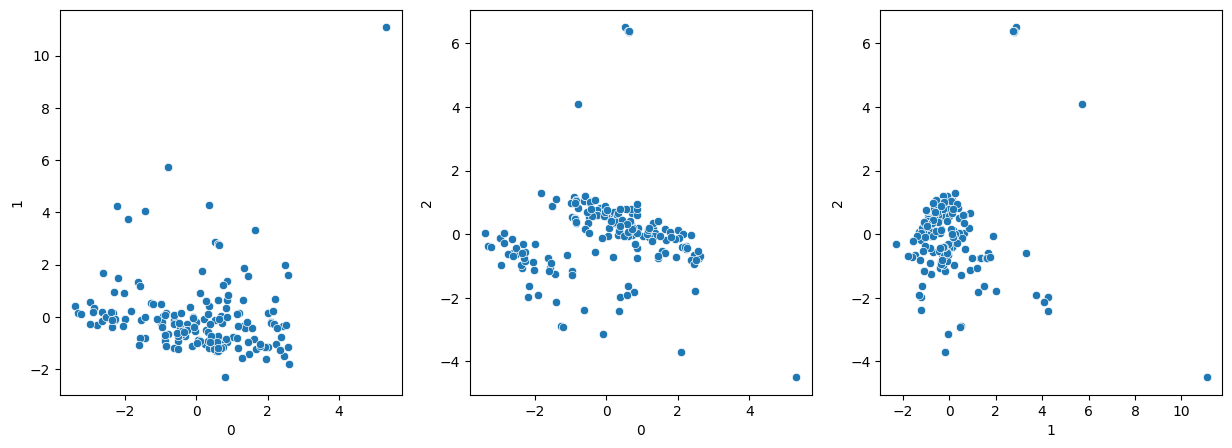

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
sns.scatterplot(x = data_pca[0], y = data_pca[1], ax=axs[0])
sns.scatterplot(x = data_pca[0], y = data_pca[2], ax=axs[1])
sns.scatterplot(x = data_pca[1], y = data_pca[2], ax=axs[2])
plt.show();

Except some outliers, the three first axes have a single cluster of values.

## Treating Outliers

Tree-based predictors are very tolerant to outliers, so it is not clear that outliers have to be treated in this task. However, we will treat them here in preparation for potentially other models.

The individual strategy has been decided above per column, so we only need to execute the strategy.

In [49]:
# Let's keep a copy of the original dataframe
df_original = df.copy()

Before outliers are removed, we will create a new feature indicaing whether a particular feature vector had an outlier on one of the columns. This might be relevant for classification.  

In [50]:
# Identify the numerical features with outliers and create a column to flag them
outliers = {}
for col in num_features+ordinal_features:
    # Calculate IQR
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    # Define the outlier boundaries
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers[col] = (lower_bound, upper_bound)
    # Create new boolean feature for outliers 
    df[f'{col}_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
    print(f"Feature {col} has {df[f'{col}_outlier'].sum()/df[f'{col}_outlier'].count():.0%} outliers. Column {col}_outlier has been created.")

Feature MORTDUE has 4% outliers. Column MORTDUE_outlier has been created.
Feature DEBTINC has 2% outliers. Column DEBTINC_outlier has been created.
Feature YOJ has 2% outliers. Column YOJ_outlier has been created.
Feature LOAN has 4% outliers. Column LOAN_outlier has been created.
Feature CLAGE has 1% outliers. Column CLAGE_outlier has been created.
Feature VALUE has 5% outliers. Column VALUE_outlier has been created.
Feature DEROG has 12% outliers. Column DEROG_outlier has been created.
Feature DELINQ has 20% outliers. Column DELINQ_outlier has been created.
Feature NINQ has 3% outliers. Column NINQ_outlier has been created.
Feature CLNO has 4% outliers. Column CLNO_outlier has been created.


In [51]:
# Excecute the strategy for the outliers
for col in df.columns:
    if outlier_strategy.get(col):
        match outlier_strategy[col]['type']:
            case 'boundary':
                # Use Pandas clip function to apply the boundaries
                df[col] = np.clip(df[col], outlier_strategy[col]['boundaries'][0], outlier_strategy[col]['boundaries'][1])
                print(f"Feature {col} has been clipped to the boundaries {outlier_strategy[col]['boundaries']}.")
            case _: # We could have other strategies, but in this workbook, no other strategy is used 
                raise NotImplementedError(f"Outlier strategy {outlier_strategy[col]['type']} not implemented.") 

Feature LOAN has been clipped to the boundaries (0, 41600.0).
Feature MORTDUE has been clipped to the boundaries (0, 159306.0).
Feature VALUE has been clipped to the boundaries (0, 200447.375).
Feature YOJ has been clipped to the boundaries (0, 28.0).
Feature DEROG has been clipped to the boundaries (0, 7).
Feature DELINQ has been clipped to the boundaries (0, 6).
Feature CLAGE has been clipped to the boundaries (0, 406.23064200499994).
Feature NINQ has been clipped to the boundaries (0, 12).
Feature CLNO has been clipped to the boundaries (0, 42.5).
Feature DEBTINC has been clipped to the boundaries (14.345367488000003, 53.79780451199999).


In [52]:
# Make a copy of the dataframe without the outliers
df_nooutliers = df.copy()

## Treating Missing Values

First we will see how many features are missing per row to decide what to do with records that have null values

In [53]:
df['missing_values'] = df.isnull().sum(axis=1)
mv = df['missing_values'].value_counts().reset_index()
mv

missing_values  count
0                0   3364
1                1   1589
2                2    449
3                3    219
4                5     83
5                6     66
6                4     64
7                9     49
8                8     39
9                7     25
10              10     11
11              11      2

There are records with a lot of missing data. These are not reliable and we should drop them instead of trying to impute values. Losing 5% of data seems accetable.

In [54]:
# Different for pandas 1.5 and 2.x
if float(pd.__version__.split('.')[0]) < 2:
  mv['remainder'] = 1-mv['missing_values'].cumsum()/df.shape[0]
  cutoff = mv[mv['remainder']<0.05]['index'].min()
else:
  mv['remainder'] = 1-mv['count'].cumsum()/df.shape[0]
  cutoff = mv[mv['remainder']<0.05]['missing_values'].min()

In [55]:
df = df[df['missing_values']<cutoff]
# Make a copy of the dataframe without the outliers
df_nooutliers = df.copy()
# print the shape of the dataframe
print(f"The shape of the dataframe after dropping rows with >={cutoff} null features is {df.shape}")

The shape of the dataframe after dropping rows with >=4 null features is (5621, 24)


Given that a record with no missing data is more reliable than one with synthentic data, we will later create a sample_weight to be used later in the models

The strategy to treat features with missing values was already decided above, so now we only need to execute the strategy

In [56]:
# Now execute the imputation strategy
for col in df.columns:
    if ev:=expected_values.get(col):
        # if this is a dictionary, then we impute two different values for repaid loans and defaulted loans
        if isinstance(ev, dict):
            for k, v in ev.items():
                df.loc[(df[target_feature]==k) & df[col].isna(),col] = v
        else:
            df[col] = df[col].fillna(ev)

# Missing values statistics
missing_values = missing_values_table(df)

# Confirm that there are no missing values
print (f"The dataset has {str(df.shape[1])} columns of which {str(missing_values.shape[0])} have missing values.")      

The dataset has 24 columns of which 0 have missing values.


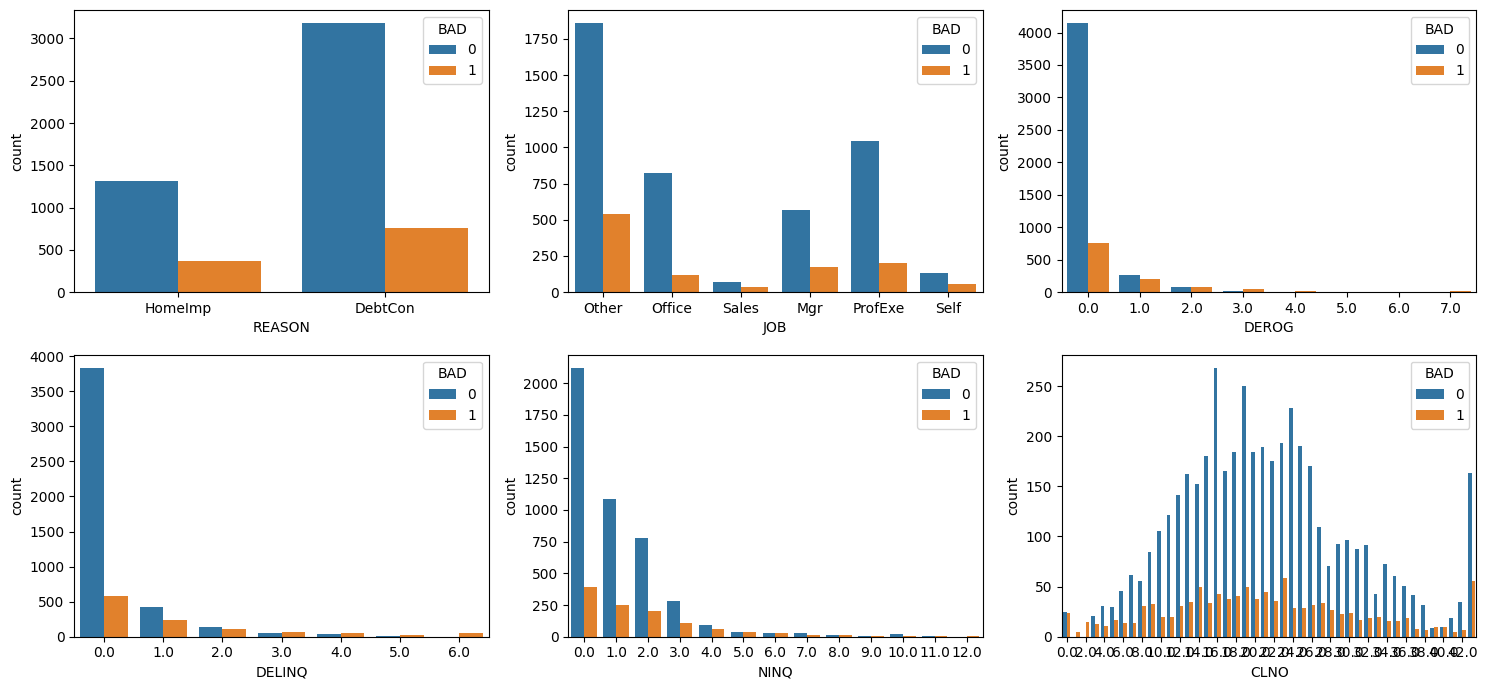

In [57]:
# Visualise the results
univariate_plot(df=df, fun=sns.countplot, columns=cat_features, rotate=False, hue=target_feature, figsize=(15, 7), stat='count')

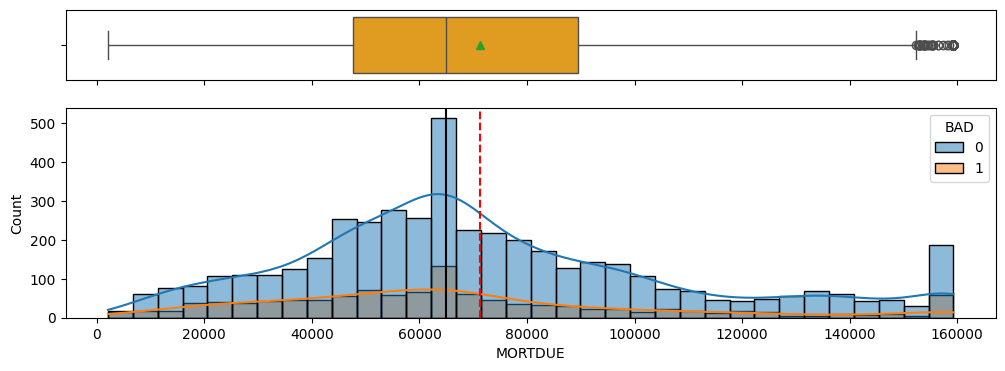

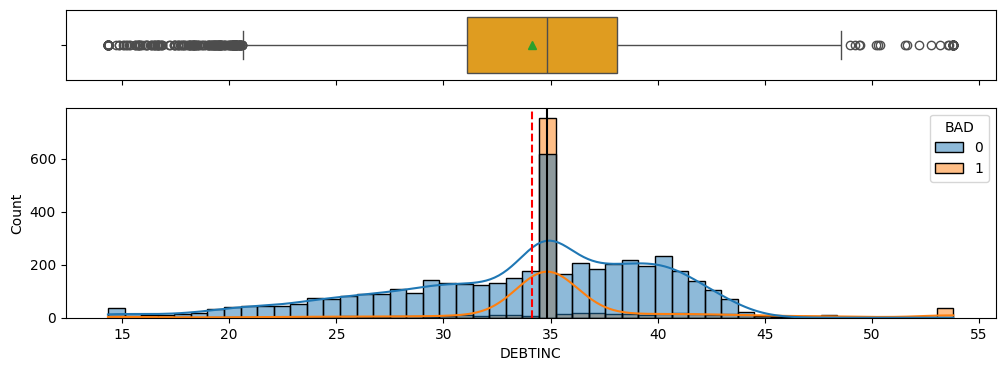

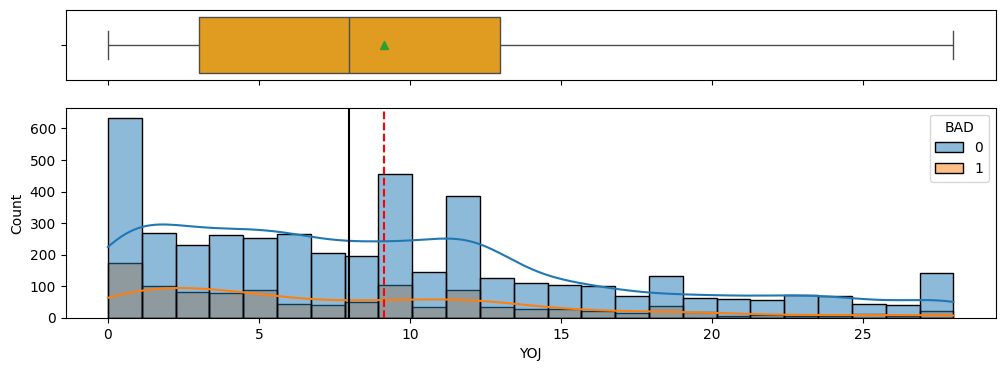

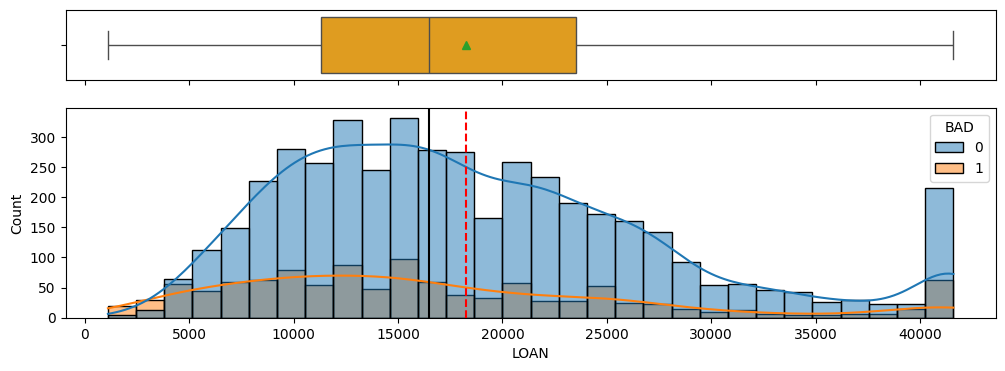

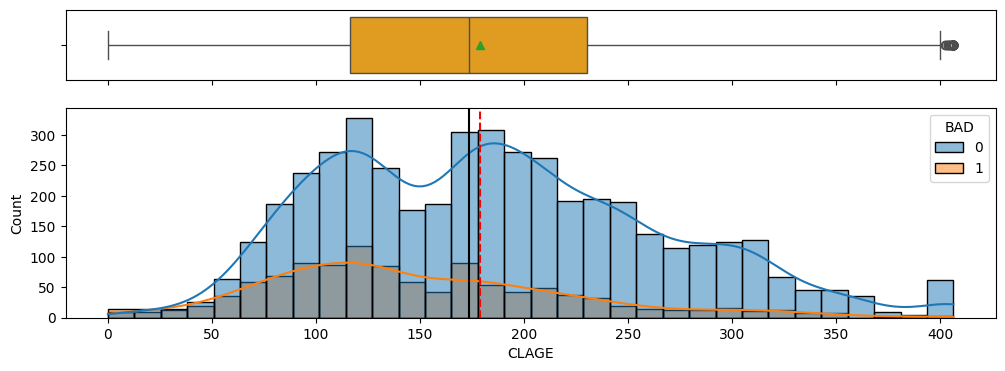

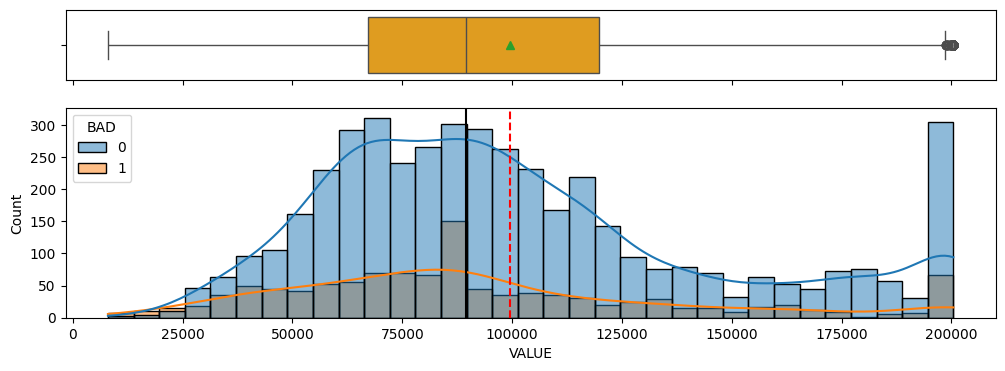

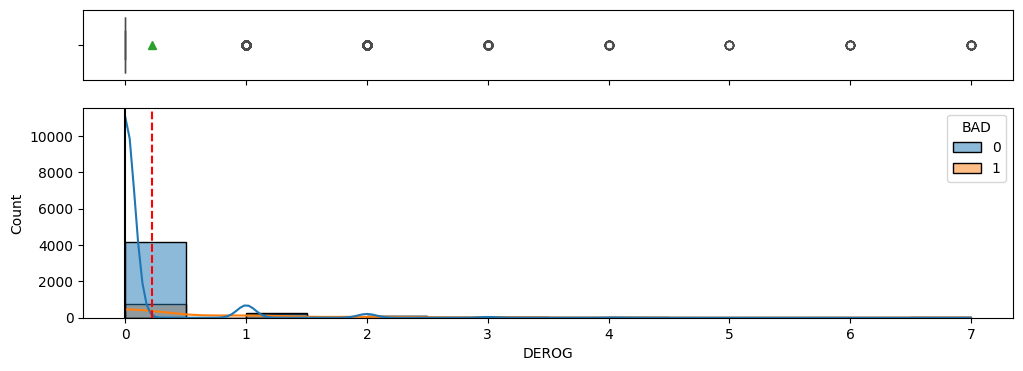

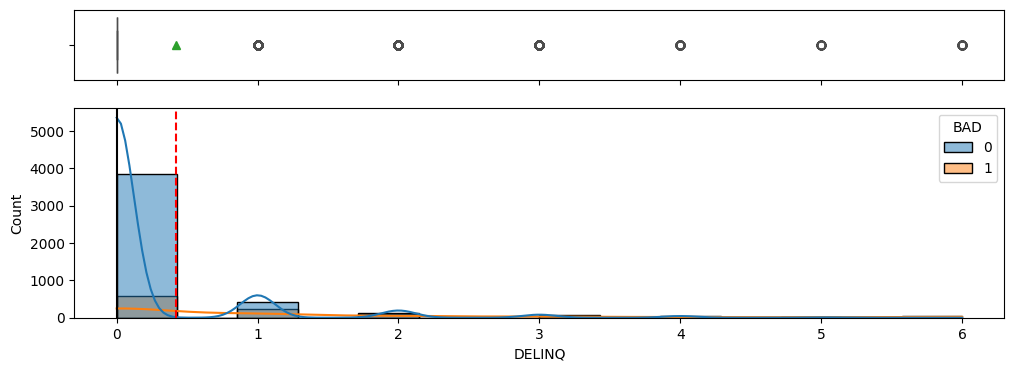

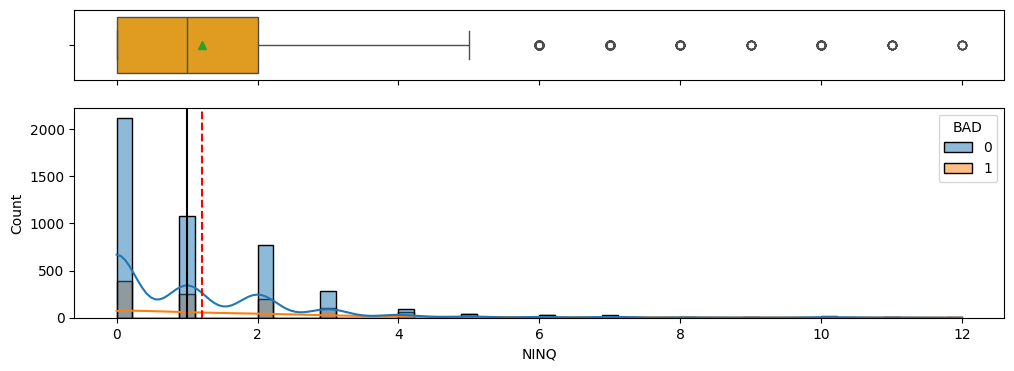

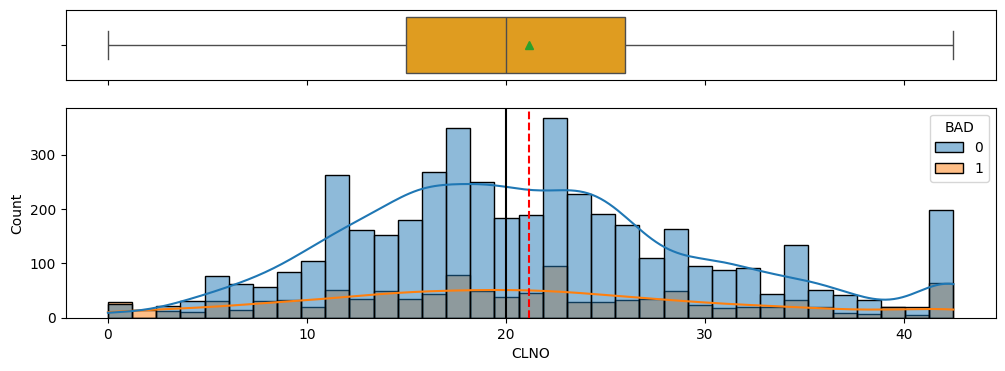

In [58]:
for col in num_features+ordinal_features:
    histogram_boxplot(df, col, figsize=(12, 4), hue=target_feature, kde=True)

**Observations**

Given the relatively large number of outliers for some of the features (e.g. DEBTINC), by using the current strategy, we are significantly altering the distribution of some of the features. It is probably a good idea to look for an alternative imputation strategy.

### Imputation using KNN

The above imputation uses arguments from the data exploration to impute missing values. A totally different approach is to use similarity between loans to "guess" the missing values. KNNImputer uses a k-nearest-neighbor algorithm to find loans that are similar to the one with missing values and impute them by majority voting. [A similar argument can be made for using matrix completion, but here we will stick to a simpler approach.]

In [59]:
# Imputation via KNN; n_neighbors is a hyperparameter; we have experimented with different values
imputer = KNNImputer(n_neighbors=10)
df_knn = df_nooutliers.copy()
# Encode the nominal features, so KNN doesn't complain
df_knn, encoders_knn = encode_data(df_knn, nominal_features=nominal_features, drop_first=False, ordinal_features=None, num_features=None, 
                                 encode_boolean=False, encoders=None)
# Execute the imputation
df_knn = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

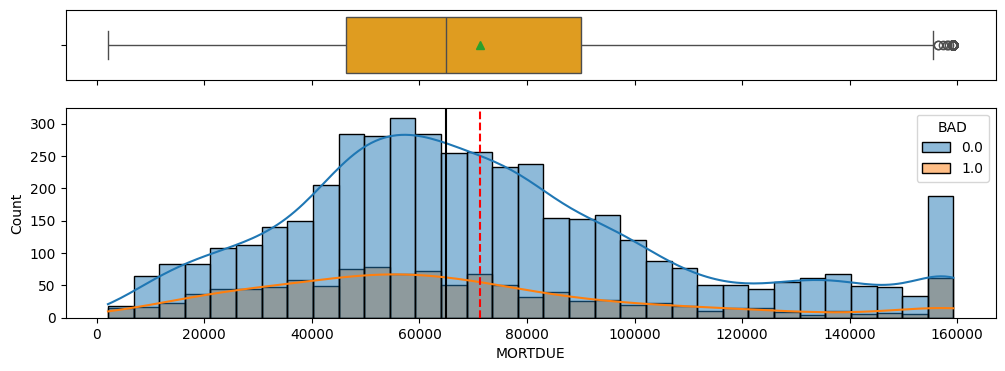

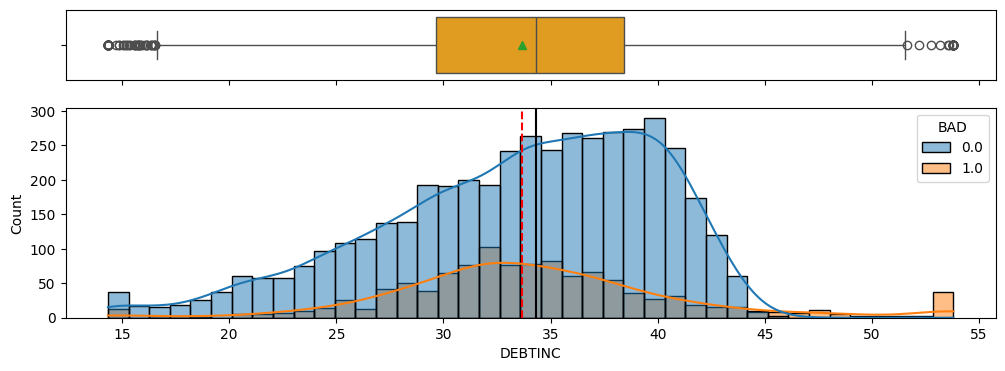

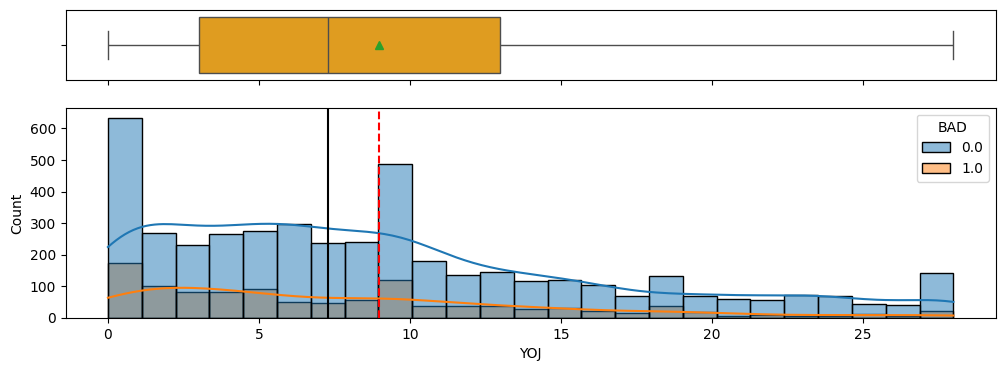

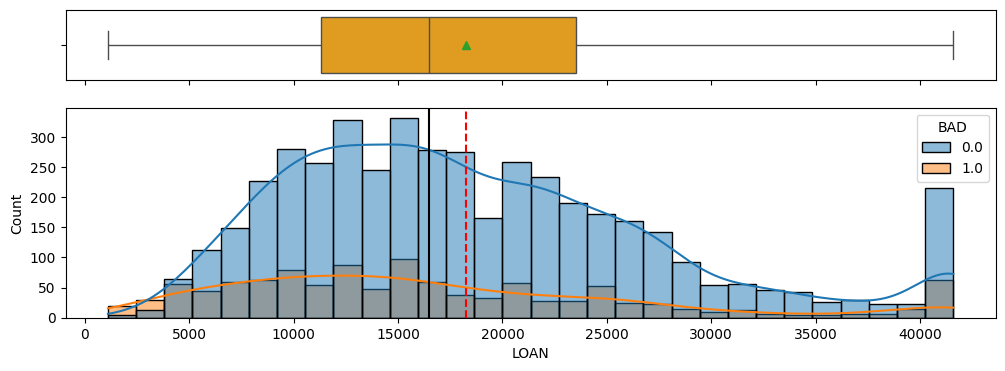

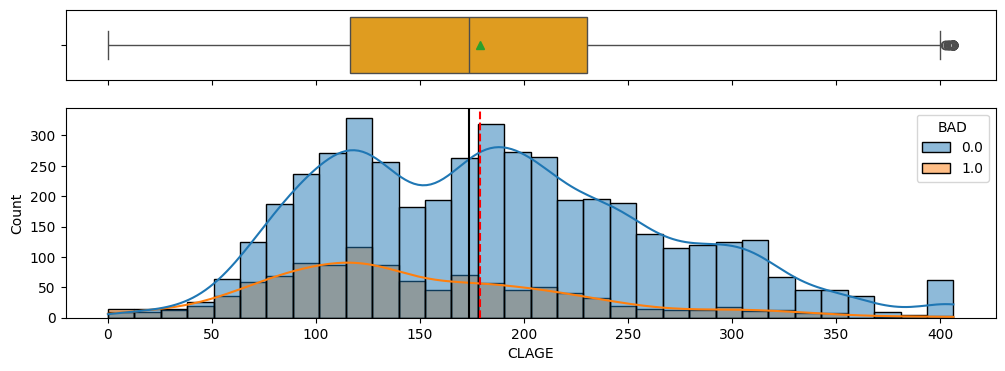

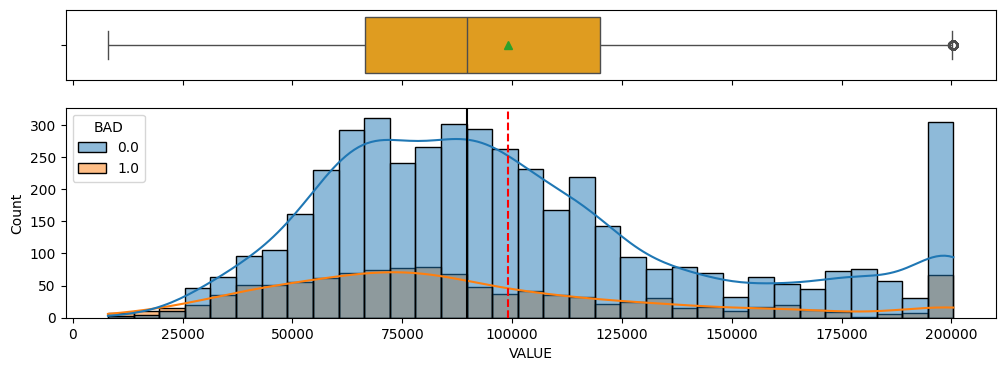

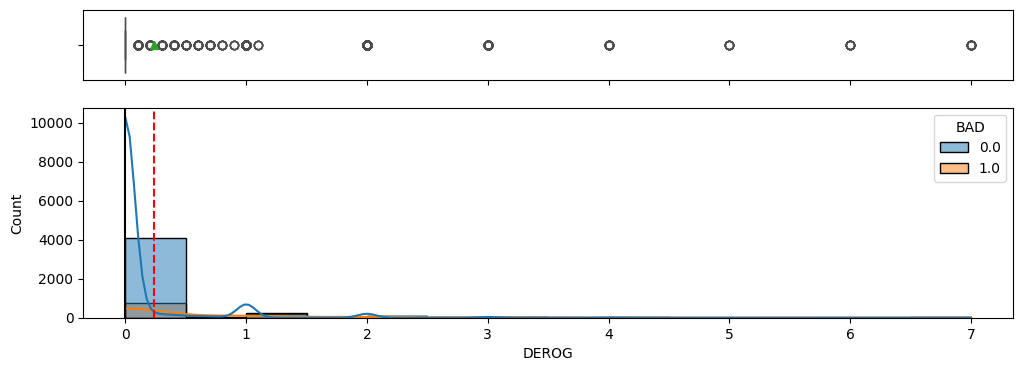

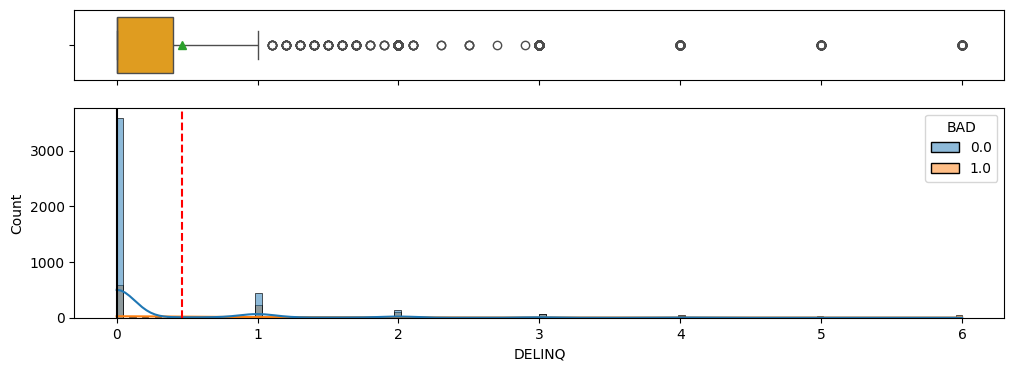

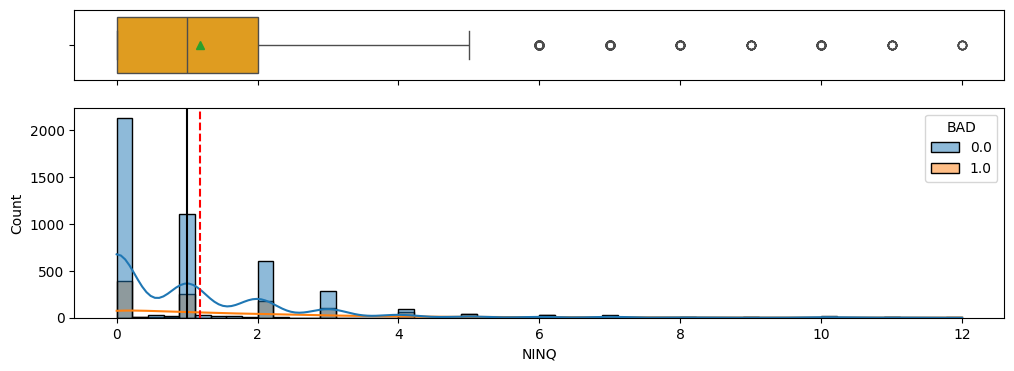

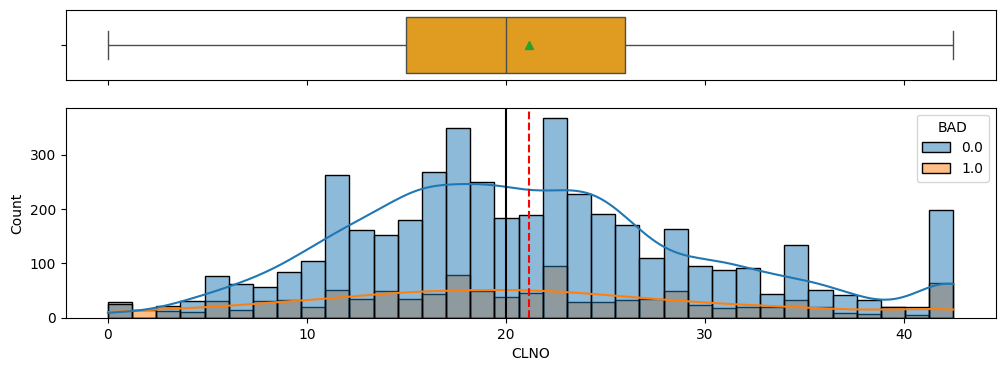

In [60]:
for col in num_features+ordinal_features:
    histogram_boxplot(df_knn, col, figsize=(12, 4), hue=target_feature, kde=True)

**Observations**

We can see that the k-nearest neighbor imputation has produced significantly "smoother" imputation results. We will continue with this data set.

In [61]:
# Use this data set for the rest of the analysis
df = df_knn.copy()
# Use the same encoders as for KNN; the rest of the features will be encoded later
encoders = encoders_knn

## **Important Insights from EDA**

**Leading Questions**:
1. What is the range of values for the loan amount variable "LOAN"?
   - The loan amount ranges between 1,100 and 89,900$
2. How does the distribution of years at present job "YOJ" vary across the dataset?
   - YOJ seems to be exponentially distributed (with negative coefficient, so decreasing) 
3. How many unique categories are there in the REASON variable?
   - There are only two categories for the use of the loan: home improvement and debt conversion
4. What is the most common category in the JOB variable?
   - "Other" is the most common category in the job variable
5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?
   - We could establish that statistically relevant more loans used for home improvements defaulted than those used for debt conversion
6. Do applicants who default have a significantly different loan amount compared to those who repay their loan?
   - As per Mann-Whitney U test, the loan amount is significantly correlated to loan defaulting 
7. Is there a correlation between the value of the property and the loan default rate?
   - As per Mann-Whitney U test, the VALUE feature is not statistically significant for the determination of defaults; the same test rejected all numerical features except LOAN. Some caution is at order regarding discarding such features.
8. Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?
   - As per Mann-Whitney U test, the amount of mortgage due is also not significant for the determination of defaults

**What are the the most important observations and insights from the data based on the EDA performed?**

1) This analysis is based on the Home Equity dataset (HMEQ) with about 6,000 records of (unclean) data with 12 features. There is a significant amount of missing data (up to 21% for deb-to-income ratio). We discarded about 5% of records because more than 3 features were missing for the same record. The remainder were imputed using a k-nearest neighbour imputer. Outliers were mapped to $\pm 1.5 IQR$; outliers were marked in separate features to allow models to take that into consideration.  
*Note:* Outlier removal is not strictly necessary for tree-based methods, it is for Logistic Regression, and we wanted to evaluate all models on the same dataset. The data set is imbalanced with an 80:20 split between repaying and loan defaulting records.
2) Features are generally skewed, some of them heavily. Only some features have a distribution similar to a (skewed) normal distribution (VALUE, LOAN, CLAGE, MORTDUE, CLNO). DEBTINC (and possibly VALUE and CLAGE) might be distributed according to a bi-modal normal distribution. YOJ and NINQ seem to be exponentially distributed.
3) In features like derogatory reports, delinquency rate and number of credit inquieries, there are threshold values beyond which we only have records corresponding to loan defaulters. For the line of credit lines, both very low and very high numbers have a loan default majority class, indicating two different clusters of clients
4) There is significant correlation between loan amount and mortgage due. We decided to keep both features, sacrificing the interpretability of the coefficients of the LogisticRegression (but not its power of prediction). Tree models are not affected by multicollinearity.
5) A statistical test was conducted on features; all categorical features were found to be relevant for the target feature. For the numerical features, only the loan amount was deemed statistically significant.
6) On a macro scale, loan defaulters have smaller, younger loans, less mortgage due, a lower debt to income ratio and fewer years on the job. This seems to point at a group of loans corresponding to less well-off persons with less job stability.
7) Using PCA, we were able to create 7 "personae" to describe defaulting loans in more granularity.

# **Model Building**

Tasks to complete:
- Data preparation
- Partition the data into train and test set
- Build the models
- Fit on the train data
- Tune the model
- Test the model on test set

In [62]:
# Fixing the random state
random_state = 42
# We will use 20% of the data for testing
test_size = 0.2


def init_random_state(random_state:int=42):
    """Simple method to set the random state for reproducibility

    Args:
        random_state (int, optional): An integer seed. Defaults to 42.
    """
    random.seed(1)
    np.random.seed(1)
    try:
        # If tensorflow is imported (as tf), also set tensorflow's random seed
        tf.random.set_seed(1)
    except:
        pass

### Encoding

In [63]:
# Although for the tree-based models we don't need to scale the data, we will do it for the sake of consistency with the other models (Logistic Regression etc.)
df, encoders = encode_data(df, nominal_features=nominal_features, drop_first=False, 
                           ordinal_features=ordinal_features, num_features=num_features,
                           encode_boolean=True, encoders=encoders)

# Check a sample of the dataframe
df.sample(10)

BAD      LOAN   MORTDUE     VALUE       YOJ  DEROG  DELINQ     CLAGE  \
131   0.0  0.096296  0.288827  0.278985  0.178571    3.0     0.0  0.160089   
1132  1.0  0.224691  0.175003  0.166238  0.107143    0.0     0.0  0.368940   
1992  1.0  0.306173  0.451130  0.462464  0.428571   10.0     0.0  0.357432   
5505  0.0  1.000000  0.488063  0.401128  0.364643    0.0     0.0  0.865151   
2530  0.0  0.355556  0.614228  0.559472  0.464286    0.0     0.0  0.437064   
1107  0.0  0.222222  0.389334  0.389260  0.000000    0.0     0.0  0.245713   
542   0.0  0.165432  0.259083  0.230827  0.285714    3.0     5.0  0.475300   
2573  0.0  0.360494  0.292732  0.299749  0.107143    0.0     0.0  0.369018   
2438  0.0  0.348148  0.540902  0.509079  0.750000    0.0     0.0  0.364194   
2321  1.0  0.343210  0.628892  0.101326  0.392857   10.0    10.0  0.153361   

      NINQ  CLNO   DEBTINC  MORTDUE_outlier  DEBTINC_outlier  YOJ_outlier  \
131   11.0  16.0  0.566608              0.0              0.0          0.0   
1132  20.0  26.0  0.731308              0.0              0.0          0.0   
1992   0.0  23.0  0.381843              0.0              0.0          0.0   
5505   0.0   6.0  0.183768              0.0              0.0          0.0   
2530   0.0  26.0  0.481723              0.0              0.0          0.0   
1107  10.0   7.0  0.608965              0.0              0.0          0.0   
542    7.0  18.0  0.307979              0.0              0.0          0.0   
2573  10.0  12.0  0.409125              0.0              0.0          0.0   
2438  27.0  24.0  0.345129              0.0              0.0          0.0   
2321  20.0   3.0  0.404735              0.0              0.0          0.0   

      LOAN_outlier  CLAGE_outlier  VALUE_outlier  DEROG_outlier  \
131            0.0            0.0            0.0            0.0   
1132           0.0            0.0            0.0            0.0   
1992           0.0            0.0            0.0            1.0   
5505           1.0            0.0            0.0            0.0   
2530           0.0            0.0            0.0            0.0   
1107           0.0            0.0            0.0            0.0   
542            0.0            0.0            0.0            0.0   
2573           0.0            0.0            0.0            0.0   
2438           0.0            0.0            0.0            0.0   
2321           0.0            0.0            0.0            1.0   

      DELINQ_outlier  NINQ_outlier  CLNO_outlier  missing_values  DebtCon  \
131              0.0           0.0           0.0             3.0      1.0   
1132             0.0           0.0           0.0             0.0      1.0   
1992             0.0           0.0           0.0             1.0      1.0   
5505             0.0           0.0           0.0             2.0      0.0   
2530             0.0           0.0           0.0             0.0      1.0   
1107             0.0           0.0           0.0             0.0      0.0   
542              0.0           0.0           0.0             3.0      0.0   
2573             0.0           0.0           0.0             0.0      1.0   
2438             0.0           0.0           0.0             0.0      0.0   
2321             1.0           0.0           0.0             2.0      0.0   

      HomeImp  Mgr  Office  Other  ProfExe  Sales  Self  
131       0.0  0.0     0.0    0.0      0.0    0.0   0.0  
1132      0.0  0.0     0.0    0.0      0.0    0.0   1.0  
1992      0.0  0.0     0.0    1.0      0.0    0.0   0.0  
5505      1.0  0.0     0.0    1.0      0.0    0.0   0.0  
2530      0.0  0.0     0.0    1.0      0.0    0.0   0.0  
1107      1.0  0.0     0.0    1.0      0.0    0.0   0.0  
542       1.0  0.0     1.0    0.0      0.0    0.0   0.0  
2573      0.0  0.0     0.0    0.0      1.0    0.0   0.0  
2438      1.0  0.0     0.0    1.0      0.0    0.0   0.0  
2321      1.0  0.0     0.0    1.0      0.0    0.0   0.0

Splitting into training and test datasets

In [64]:
# Create the feature array and target vector
X = df.drop(columns=[target_feature])
y = df[target_feature]

In [65]:
# Creating training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [66]:
# Let's calculate the occurances of each class in the training set
weights = y_train.value_counts(normalize=True)
# And determin the class_weights - this is a hyperparameter
class_weight = {0: weights[1], 1: weights[0]}

Now let's create the sample weights based on the "missing_values" column and remove that feature from the training and test set

In [67]:
sample_weight = len(cat_features+num_features)-X_train['missing_values']
sample_weight.value_counts()
# We will need a copy for under and oversampling
missing_values = X_train['missing_values'].copy()
# Now remove the feature from training and test set and the feature set (which we will use later for over and undersampling)
X_train.drop(columns=['missing_values'], inplace=True)
X_test.drop(columns=['missing_values'], inplace=True)
X.drop(columns=['missing_values'], inplace=True)

**NOTE**
Model training, optimisation, evaluation and optimal threshold selection are all contained in the following functions.

In [68]:
# Helper functions for model running and evaluation
def plot_confusion_matrix(ax, cm, labels:list=None, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = labels, yticklabels = labels, ax=ax, cmap=cmap, cbar=False)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(title)

def plot_classification_report(ax:plt.Axes, cr:dict, labels:list=None, title:str=None, cmap:plt.cm=plt.cm.Blues, rounding:int=4):
    """Plots the classification report as a table

    Args:
        ax (plt.Axes): The axes object to plot in
        cr (dict): Result of calling sklearn.metrics.classification_report with parameter output_dict=True
        labels (list, optional): Labels for the classes. Defaults to None.
        title (str, optional): Title of the report. Defaults to None.
        cmap (plt.cm, optional): Colormap to use. Defaults to plt.cm.Blues.
        rounding (int, optional): Number of decimal places to round to. Defaults to 4.
    """
    if not title:
        title = 'Classification report'

    # For easier handling convert the dictionary to a dataframe 
    df = pd.DataFrame(cr)
    # Extract accuracy which is not available by label (obviously)
    accuracy = df['accuracy'].iloc[0]
    # Drop the accuracy column to make the dataframe "well-formed"
    df.drop(columns=['accuracy'], inplace=True)
    # Rename the columns with the labels
    df.rename(columns={'0': labels[0], '1': labels[1]}, inplace=True)
    # Round the values to rounding decimal places
    df = df.round(rounding)
    # Now set up the table
    ax.axis('off')
    ax.set_title(title)
    table = ax.table(cellText=np.vstack([df.values, [f'{accuracy:.4f}','','', '']]),
                      colLabels=df.columns,
                      rowLabels=df.index.to_list()+['accuracy'],
                      rowColours=['lightgrey']*df.shape[0]+['lightgrey'],
                      colColours=['lightgrey']*df.shape[1],
                      bbox=[0.06, 0.3, 0.95, 0.7])
    table.auto_set_font_size(False)
    table.set_fontsize(9)

def combined_metrics_score(y_train:pd.Series, y_train_pred:pd.Series, y_test:pd.Series=None, y_test_pred:pd.Series=None, 
                           labels: list = None, normalize: bool = False, title: str = None):
    """Plots a confusion matrix and a classification report for the training and test sets

    Args:
        y_train (pd.Series): Training set of classes
        y_pred_train (pd.Series): Predicted classes for the training set
        y_test (pd.Series, optional): Test set of classes. Defaults to None.
        y_pred_test (pd.Series, optional): Predicted classes for the test set. Defaults to None.
        labels (list, optional): _description_Labels for the classes. Defaults to None.
        normalize (bool, optional): If true, the confusion matrix will be normalised. Defaults to False.
        title (str, optional): Title. Defaults to None.

    Raises:
        ValueError: if training set or predicted training set are None

    Returns:
        array, array: The classification reports for the training and test sets
    """
    if y_train is None or y_train_pred is None:
        raise ValueError('y_train and y_train_pred cannot be None')
    if y_test is None or y_test_pred is None:
        test_output = False
    else:
        test_output = True
    
    cols = 1
    cr_test = None
    # Compute classification report
    cr_train = classification_report(y_train, y_train_pred, output_dict=True)
    if test_output:
        cols = 2
        cr_test  = classification_report(y_test, y_test_pred, output_dict=True)
    
    # Compute confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = None
    if test_output:
        cm_test = confusion_matrix(y_test, y_test_pred)

    # Plot the results
    fig, axes = plt.subplots(cols, 2, figsize=(10, 7))
    plot_classification_report(axes[0][0], cr_train, labels=labels, title="Classification training")
    plot_confusion_matrix(axes[1][0], cm_train, labels=labels, normalize=normalize, title="Confusion matrix training", cmap=plt.cm.Blues)
    if test_output:
        plot_classification_report(axes[0][1], cr_test, labels=labels, title="Classification test")
        plot_confusion_matrix(axes[1][1], cm_test, labels=labels, normalize=normalize, title="Confusion matrix test", cmap=plt.cm.Reds)

    fig.tight_layout()
    plt.show();
    # Return the classification reports
    return cr_train, cr_test

def plot_tree(estimator, feature_names):
    """Plots a decision tree

    Args:
        estimator (DecisionTreeClassifier): The DecisionTreeClassifier estimator object
        feature_names (Iterable): Names of the features
    """

    plt.figure(figsize = (36, 36))

    out = tree.plot_tree(estimator, fontsize = 10, max_depth = 5, impurity = False, filled = True, 
                        feature_names = feature_names, class_names = True)
    # Color the arrows red and set a thicker line width
    for o in out:      
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('red')
            arrow.set_linewidth(3)

    # Display the plot       
    plt.show()

def fit_model(classifier: Callable, X_train: pd.DataFrame, y_train: pd.Series, class_weight: [dict,str]=None, 
              sample_weight: pd.Series=None, optimisation_params: dict=None, model_params: dict=None, 
              n_jobs:[int,None]=None, random_state:int=-1, verbose:int=0, plot:bool=False):
    """
    Fit a classifier and return the model and the predictions on the test set

    classifier: a classifier function
    X_train: training data set
    y_train: training labels
    X_test: test data set
    y_test: test labels
    class_weight: class weights for the classifier
    params: hyperparameters for the classifier
    random_state: random state for the classifier
    verbose: verbosity level for the classifier
    plot: whether to plot the confusion matrix
    """
    init_random_state(random_state)

    if not model_params:
        model_params = {}

    if class_weight:
        model_params['class_weight'] = class_weight
    if random_state != -1:
        model_params['random_state'] = random_state
    # Now create the classifier with the full parameter set
    clf = classifier(**model_params)
    if optimisation_params:
        # For imbalanced data sets, we use stratified k-fold, else normal k-fold
        if class_weight:
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
        else:
            cv = 5
        # and perform a grid search
        model = GridSearchCV(clf, cv=5, param_grid=optimisation_params, n_jobs=n_jobs)
        # Fitting the model on the train data
        result = model.fit(X_train, y_train, sample_weight=sample_weight)
        estimator = result.best_estimator_
    else:
        result = clf.fit(X_train, y_train)
        estimator = result

    if plot:
        plot_tree(estimator, X_train.columns)
    
    return estimator

def get_best_prediction(model, X_train: pd.DataFrame, y_train:pd.Series, X_test:pd.DataFrame, y_test:pd.Series, plot=False):
    """Determines the optimal threshold for a given model using the the ROC curve. If requested, plots the results

    Args:
        model (_type_): A fitted model
        X_train (pd.DataFrame): Training dataset
        y_train (pd.Series): Training classes
        X_test (pd.DataFrame): Test dataset
        y_test (pd.Series): Test classes
        plot (bool, optional): If true plots the ROC curve and the optimal threshold. Defaults to False.

    Returns:
        _type_: _description_
    """
    # Predict probabilities
    yhat = model.predict_proba(X_test)
    # flatten into normal list of proabilities
    probabilities = yhat[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    # Determining the best threshold
    threshold = thresholds[ix]
    # determine the roc auc score
    roc_auc = roc_auc_score(y_test, yhat[:, 1])

    print(f'Best threshold={threshold:.2f} G-Mean={gmeans[ix]:.2f} ROC AUC={roc_auc:.2f}')
    # plot the roc curve for the model
    if plot:
        # plot the roc curve for the model
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', markersize=1)
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        # show the plot
        plt.show()
    # Obtain the optimal predictions
    y_train_pred=model.predict(X_train)
    y_train_pred = (y_train_pred > threshold)

    y_test_pred=model.predict(X_test)
    y_test_pred = (y_test_pred > threshold)
    # and return them
    return y_train_pred, y_test_pred, roc_auc

In [69]:
# We will store performance metrics of all in a dictionary
models={}
# Name the classes
labels=['Repaid', 'Defaulted']

### Logistic Regression

In [70]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = None
model_params = {'penalty': 'l2', 'n_jobs': n_jobs}
# Now fit the optimal model and plot the tree
lg_model_simple = fit_model(linear_model.LogisticRegression, X_train, y_train, optimisation_params=optimisation_params, model_params=model_params,
                            sample_weight=sample_weight, random_state=random_state, plot=False)

Best threshold=0.18 G-Mean=0.75 ROC AUC=0.82


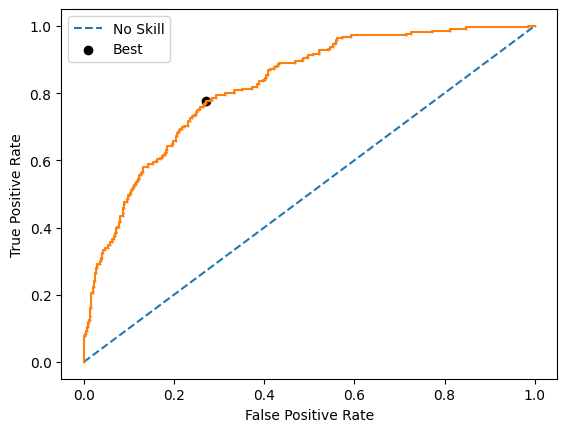

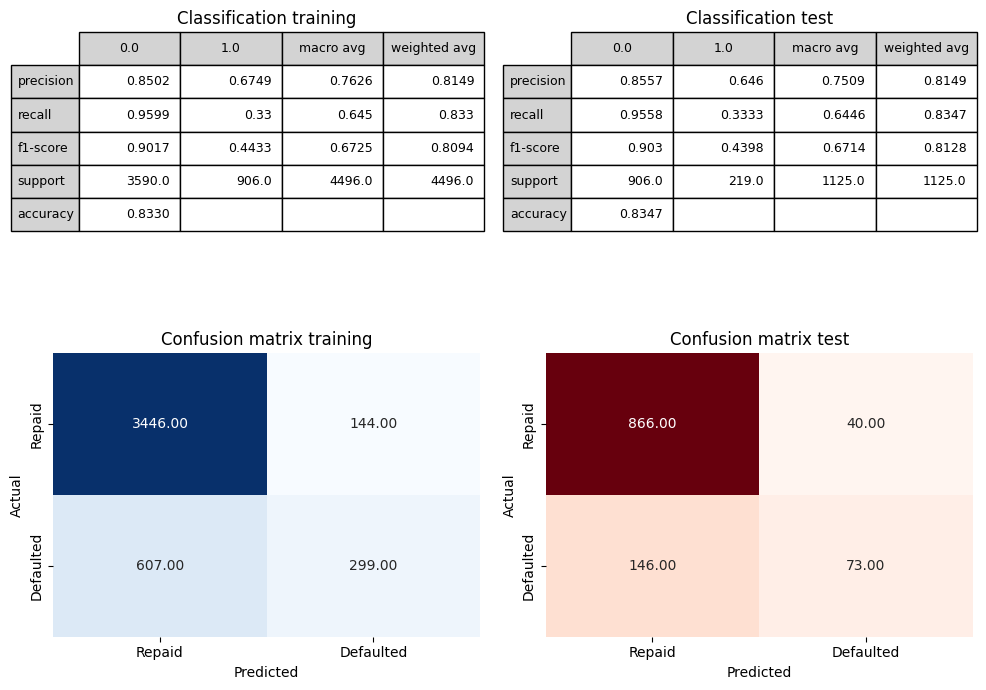

In [71]:
# Obtain the predictions for the training and test sets and determine the best prediction from the optimal threshold
y_train_pred, y_test_pred, roc_auc = get_best_prediction(lg_model_simple, X_train, y_train, X_test, y_test, plot=True)
# And plot the results
dt_simple_cr_train, dt_simple_cr_test = combined_metrics_score(y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['Logistic Regression'] = [dt_simple_cr_train, dt_simple_cr_test, {'roc_auc':roc_auc}]

**Observations:**

The logistic regression does not match the requirements for recall. Given that we made the decision not to remove the multicolinear features LOAN and VALUE, the regression coefficient might not be correct and therefore we do not use them for further analysis. We are not investing more time into optimising this model before we haven't tested the other model.

### Decision Tree

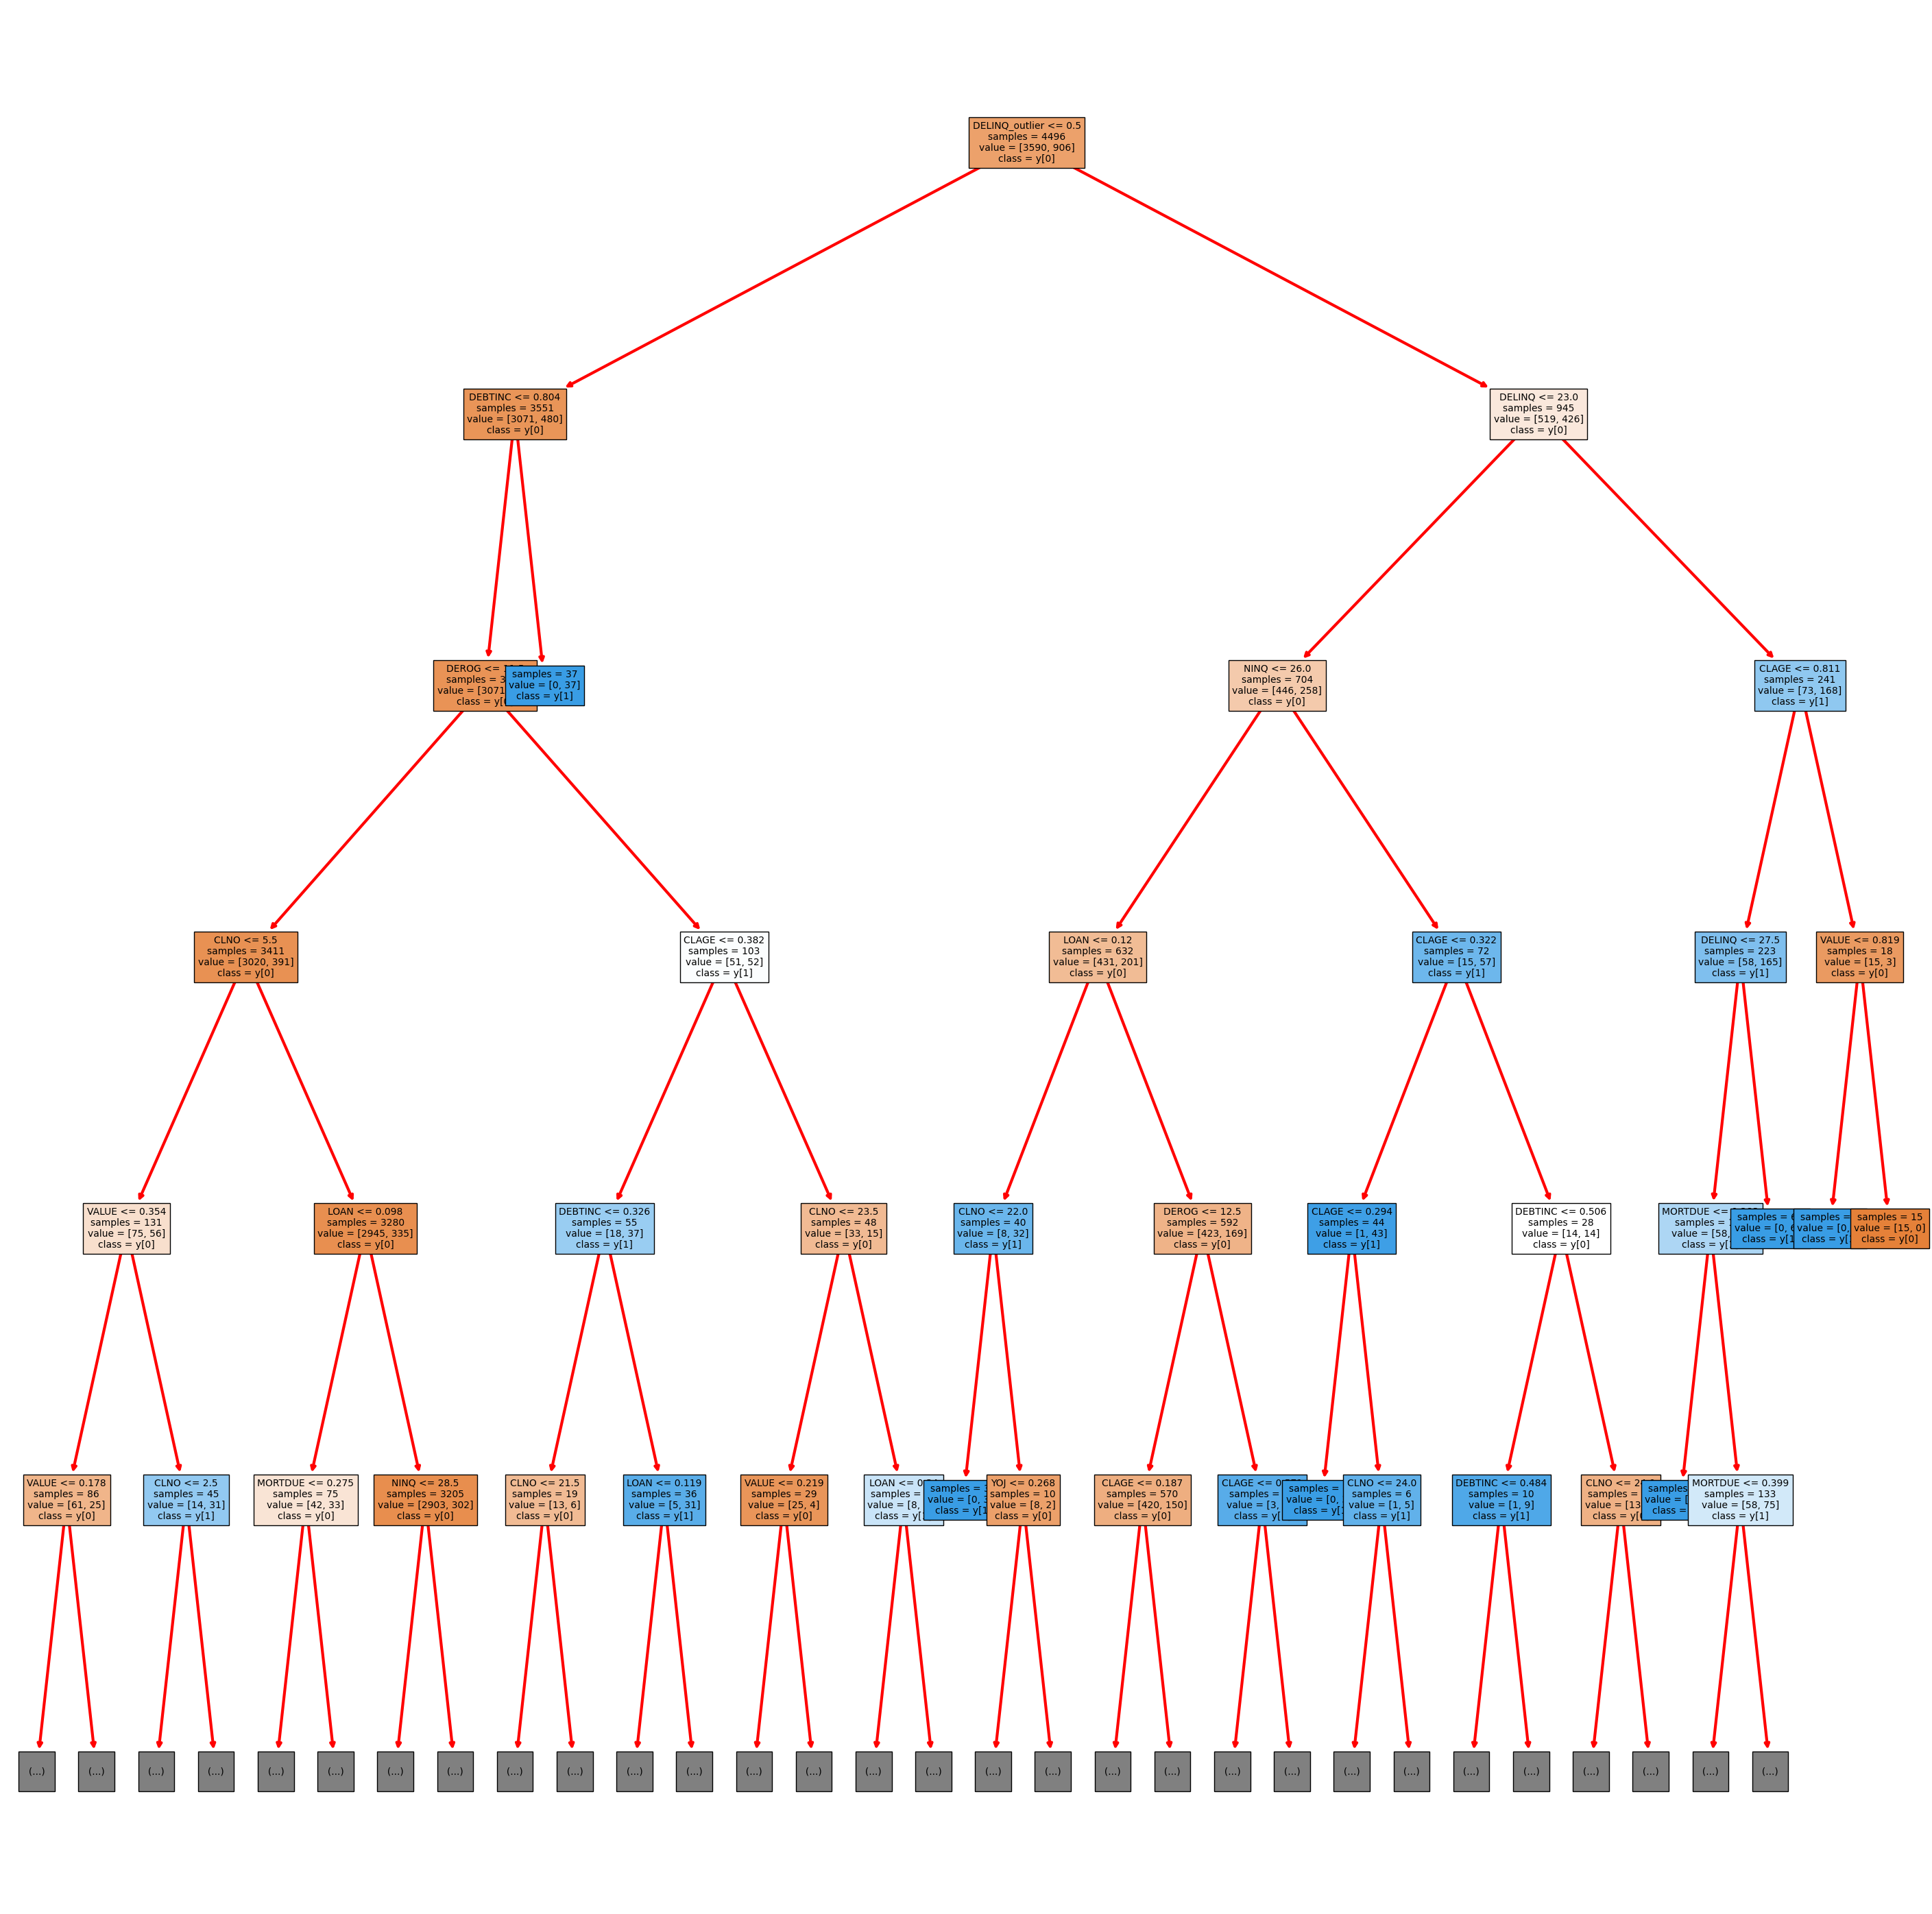

In [72]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = None
# Now fit the optimal model and plot the tree
dt_model_simple = fit_model(tree.DecisionTreeClassifier, X_train, y_train, optimisation_params=optimisation_params, 
                            sample_weight=sample_weight, random_state=random_state, plot=True)

**Observations:**  
For the unoptimised decision tree, a very high value of DELINQ (as represented by DELINQ_OUTLIER) is the most important feature; however the resulting two nodes are quite impure. On the next level for those not with very high delinquent credits, there is a small, highly indebted group that leads to defaulted loans. For those with high delinquency rate, if they also have a very significant number of derogatory reports, their loans are likely to default. However, the tree is quite deep and in its unoptimised form rather complex.

Best threshold=1.00 G-Mean=0.78 ROC AUC=0.79


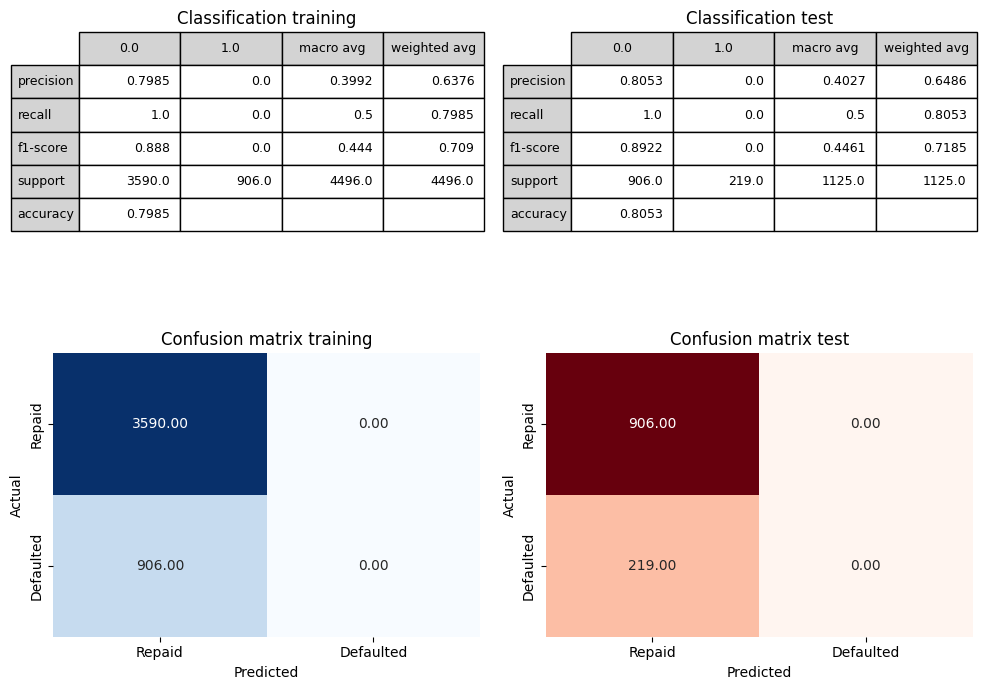

In [73]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(dt_model_simple, X_train, y_train, X_test, y_test, plot=False)
# And plot the results
dt_simple_cr_train, dt_simple_cr_test = combined_metrics_score(y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['Decision Tree (not opt)'] = [dt_simple_cr_train, dt_simple_cr_test, {'roc_auc':roc_auc}]

**Observations:**

The non-optimised decision tree cannot find true or false positives. Clearly not a good model.

### **Decision Tree - Hyperparameter Tuning**

We decided to use the following hyperparameters:
- criterion
- max_depth
- min_samples_leaf
- class_weight (to deal with the imbalance)
- ccp_alpha for pruning

Many combinations were tried of which only the result is shown. In general, we adjusted the values based on the optimal parameters grid search found.

In [74]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7], 'min_samples_leaf': [1,5,10], 
                       'class_weight': [None, 'balanced', class_weight, {0: 0.1, 1: 0.9}],
                       'ccp_alpha': [0.0, 0.001, 0.01]} # This is for pruning
# Now fit the optimal model and plot the tree
dt_model = fit_model(tree.DecisionTreeClassifier, X_train, y_train, optimisation_params=optimisation_params, 
                     sample_weight=sample_weight, random_state=random_state, plot=False, n_jobs=n_jobs)
dt_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Best threshold=0.22 G-Mean=0.74 ROC AUC=0.78


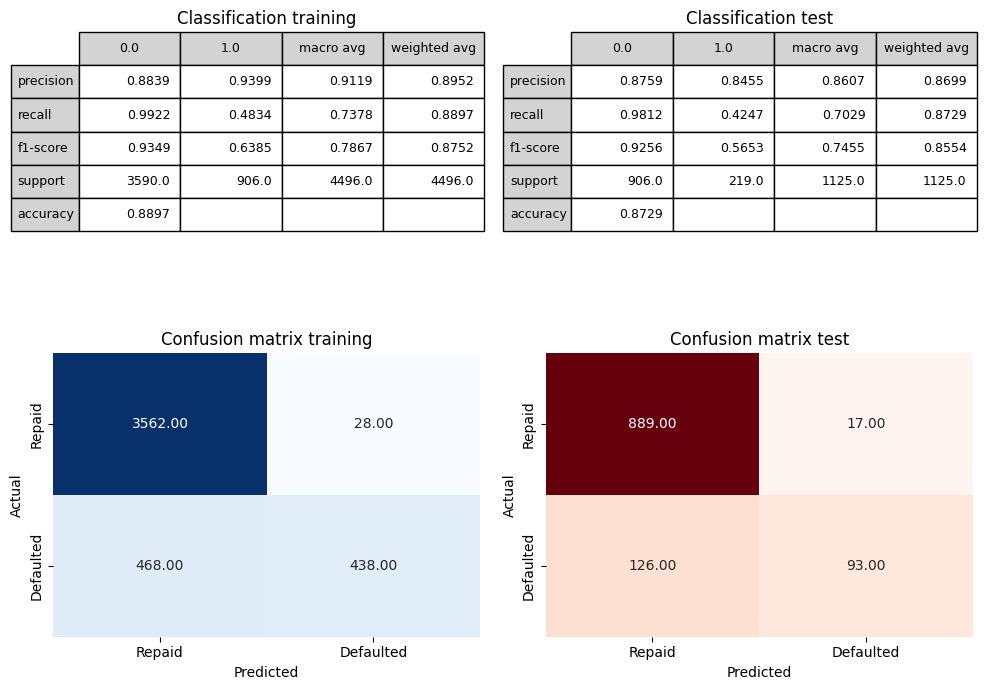

In [75]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(dt_model, X_train, y_train, X_test, y_test, plot=False)
# And plot the results
dt_cr_train, dt_cr_test = combined_metrics_score(y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['Decision Tree'] = [dt_cr_train, dt_cr_test, {'roc_auc':roc_auc}]

**Observations:**

The optimised version of the decision tree is performing well. The recall is almost 0.85 and so matches our requirements.

### Testing to what extent class imbalance impact the results. Oversampling.
Instead of using the class_weight hyperparameter, let us check whether the result can be improved with oversampling the minority class instead of using the class weights. We are going to use SMOTE to do that.

**IMPORTANT NOTE:**
We have observed that on colab when using a GPU SMOTE sometimes fails with an index error. When using a CPU that does not seem to happen. If the error occurs, waiting for 30s and running the cell again worked - not sure why.

In [76]:
# Applying SMOTE on train
smote=SMOTE(sampling_strategy='not majority')
X_sm = X_train.copy()
# add in the missing_values column
X_sm['missing_values'] = missing_values
X_sm , y_sm = smote.fit_resample(X_sm,y_train)
# And now determine the sample weight for SMOTE
sample_weight_sm = len(cat_features+num_features)-X_sm['missing_values']
X_sm.drop(columns=['missing_values'], inplace=True)
# Check the result
y_sm.value_counts(normalize=True)

BAD
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

In [77]:
# Repeat the process with the SMOTE data set
optimisation_params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7], 'min_samples_split':[2,3,4,5], 'min_samples_leaf':[1,2,3,4,5]}
dt_model_sm = fit_model(tree.DecisionTreeClassifier, X_sm, y_sm, class_weight=None, optimisation_params=optimisation_params, n_jobs=n_jobs,
                     sample_weight=sample_weight_sm, random_state=random_state, plot=False)
dt_model_sm.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Best threshold=0.23 G-Mean=0.76 ROC AUC=0.81


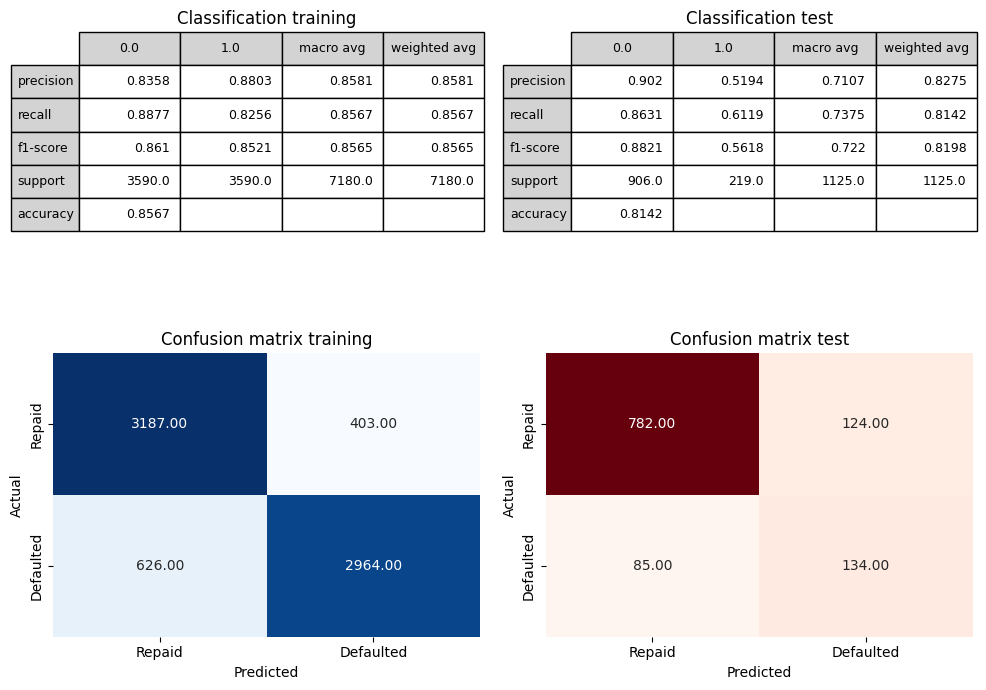

In [78]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(dt_model_sm, X_sm, y_sm, X_test, y_test, plot=False)
# And plot the results
dt_cr_train_sm, dt_cr_test_sm = combined_metrics_score(y_sm, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['Decision Tree SMOTE']=[dt_cr_train_sm, dt_cr_test_sm, {'roc_auc':roc_auc}]

**Observations:**

Oversampling did not improve the general performance of the model. However, there are fewer false negatives. 

### Testing to what extent class imbalance impact the results. Undersampling.

In [79]:
# Using a random under sampler
rus = RandomUnderSampler(random_state=random_state)
X_rus = X_train.copy()
# add in the missing_values column
X_rus['missing_values'] = missing_values
X_rus, y_rus = rus.fit_resample(X_rus, y_train)
# And now determine the sample weight for SMOTE
sample_weight_rus = len(cat_features+num_features)-X_rus['missing_values']
X_rus.drop(columns=['missing_values'], inplace=True)
# Show the resulting distribution
y_rus.value_counts(normalize=True)

BAD
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

In [80]:
# Repeat the process with the RUS data set
optimisation_params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7], 'min_samples_split':[2,3,4,5], 'min_samples_leaf':[1,2,3,4,5]}
dt_model_rus = fit_model(tree.DecisionTreeClassifier, X_rus, y_rus, class_weight=None, optimisation_params=optimisation_params, n_jobs=n_jobs,
                        sample_weight=sample_weight_rus, random_state=random_state, plot=False)
dt_model_rus.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Best threshold=0.48 G-Mean=0.77 ROC AUC=0.80


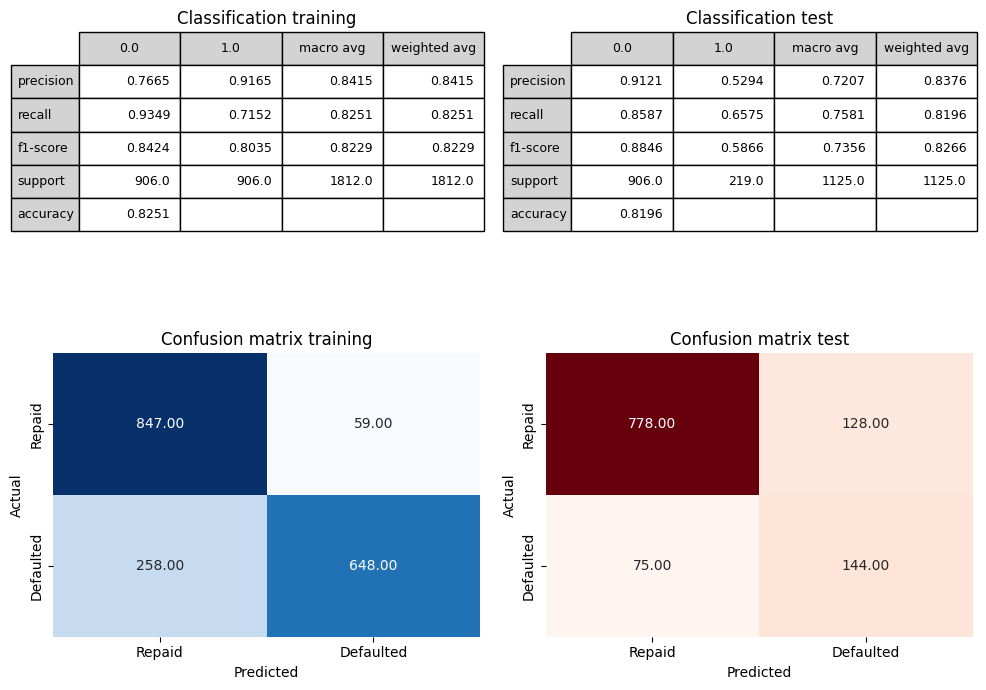

In [81]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(dt_model_rus, X_rus, y_rus, X_test, y_test, plot=False)
# And plot the results
dt_cr_train_rus, dt_cr_test_rus = combined_metrics_score(y_rus, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['Decision Tree RUS'] = [dt_cr_train_rus, dt_cr_test_rus, {'roc_auc':roc_auc}]

**Observations:**

Undersampling improves marginally the recall when compared to oversampling. However, the results on the test set are still worse than the optimised decision tree with the full data set.

### **Random Forest Classifier**

Ensemble methods like Random Forest are based on combining several weak(er) learners -in this case DecisionTrees- to create a strong and robust learner. Random Forest uses parallel trees and a majority voting mechanism for the class. Given that several, simpler trees contribute to one classification result, the interpretability of ensemble methods is not as good as for simple DecisionTrees. We will later use shapely values to interpret the results best model(s). 

We will start with a non-optimised Random Forest.

In [82]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = None
# Now fit the optimal model
rf_model_simple = fit_model(ensemble.RandomForestClassifier, X_train, y_train, class_weight="balanced", optimisation_params=optimisation_params, 
                            sample_weight=sample_weight, n_jobs=n_jobs, random_state=random_state, plot=False)

Best threshold=0.23 G-Mean=0.93 ROC AUC=0.99


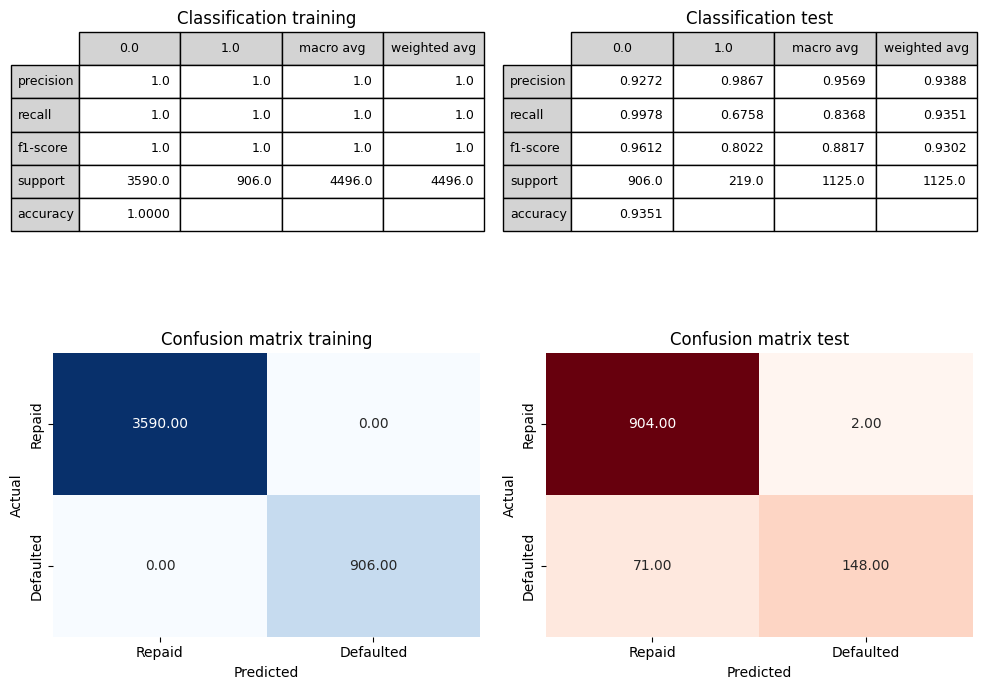

In [83]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(rf_model_simple, X_train, y_train, X_test, y_test, plot=False)
# And plot the results
rf_simple_cr_train, rf_simple_cr_test = combined_metrics_score(y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['Random Forest (not opt)']=[rf_simple_cr_train, rf_simple_cr_test, {'roc_auc':roc_auc}]

**Observations:**

The model clearly overfits; on the other hand it performs well on the test data set. Note the better performance on false positives than false negatives.

### **Random Forest Classifier Hyperparameter Tuning**

In [84]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = {'criterion':['entropy','gini'], 'n_estimators':[100,200,500],'max_depth':[5,6,7], 'min_samples_split':[5,10,20]}
# Now fit the optimal model
rf_model = fit_model(ensemble.RandomForestClassifier, X_train, y_train, class_weight="balanced", optimisation_params=optimisation_params, 
                     sample_weight=sample_weight, n_jobs=n_jobs, random_state=random_state, plot=False)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Best threshold=0.41 G-Mean=0.82 ROC AUC=0.90


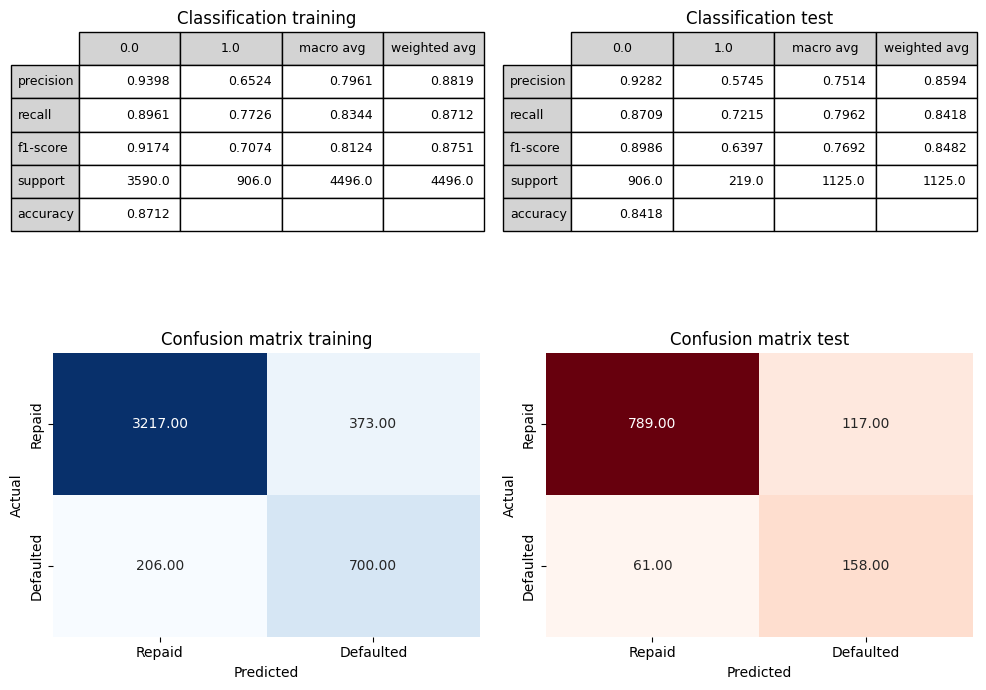

In [85]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(rf_model, X_train, y_train, X_test, y_test, plot=False)
# And plot the results
rf_cr_train, rf_cr_test = combined_metrics_score(y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['Random Forest']=[rf_cr_train, rf_cr_test, {'roc_auc':roc_auc}]

**Observations:**

In spite of worse performance on the test set when compared to the non-optimised Random Forest, this model does not overfit and therefore should generalise well. We did not quite meet the requirements of >0.85 for recall, but are close.


### **Boosting  with XGBoost**

Boosting is a different ensemble method where (relatively small) trees are used sequentially. Each tree uses its precursors to reduce the residuals. For prediction predictions are "added up" and converted into a probability. While the individual trees are weak learners, the resulting sequence of trees is to some extent like a hierarchical decision because the trees are not independent from each other. XGBoost is know for excellent performance.

In [86]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = {'n_estimators':[1500],'max_depth':[4,6,8], 'scale_pos_weight':[1,4.16,10], 'min_child_weight':[3,5],
                       'learning_rate':[0.2]}
# Now fit the optimal model
xgb_model = fit_model(XGBClassifier, X_train, y_train, 
                      optimisation_params=optimisation_params, 
                      model_params={'objective':'binary:logistic', 'eval_metric':'logloss','scoring':'roc_auc'}, 
                      sample_weight=sample_weight, n_jobs=n_jobs, random_state=random_state, plot=False)
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 8,
 'max_leaves': None,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 10,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'scoring': 'roc_auc'}

Best threshold=0.08 G-Mean=0.94 ROC AUC=0.98


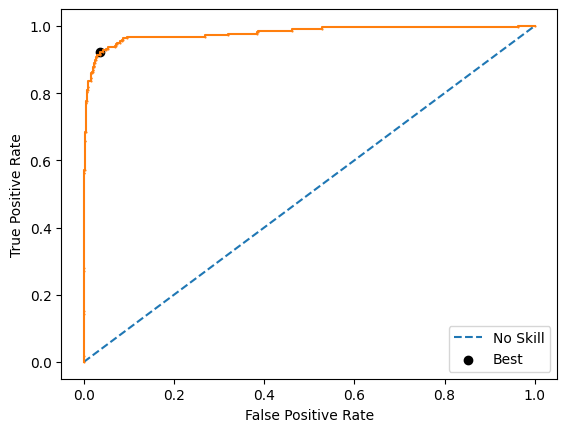

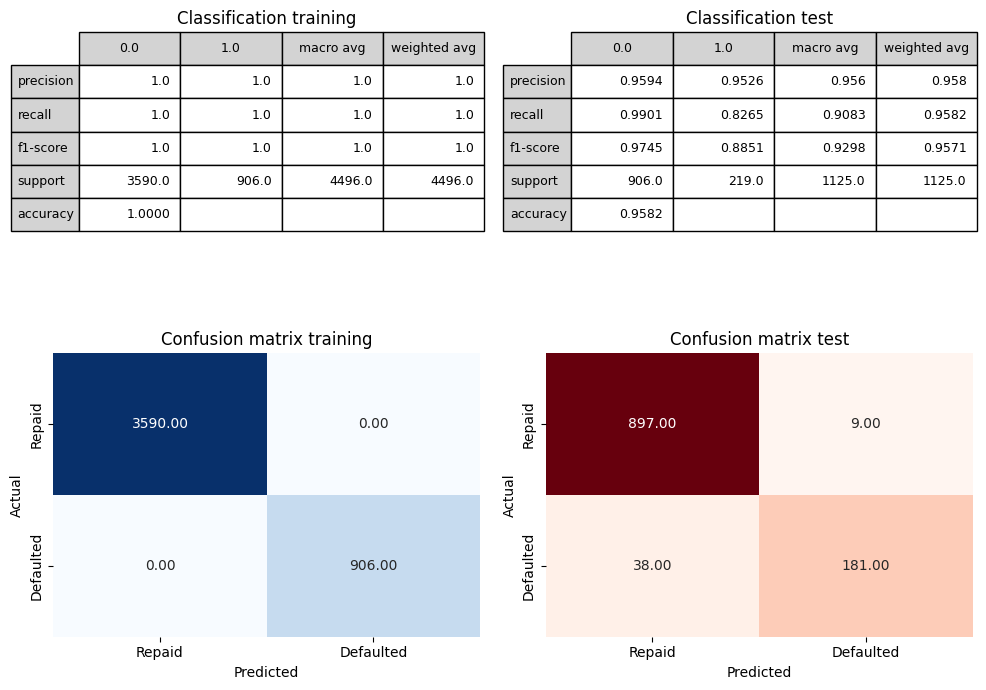

In [87]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(xgb_model, X_train, y_train, X_test, y_test, plot=True)
# And plot the results
xgb_cr_train, xgb_cr_test = combined_metrics_score(y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['XGBoost'] = [xgb_cr_train, xgb_cr_test, {'roc_auc':roc_auc}]

**Observations:**

This model performa very well on the test data, but clearly overfits on the training data set. We have tried a vast range of parameters on the grid search (not all of them shown), we were unable to create a model that does *not* overfit on the training data. We will evaluate unsersampling and then attempt to reduce the features.

### **Try undersampling**

In [88]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = {'n_estimators':[1500],'max_depth':[4,6,8], 'scale_pos_weight':[1,4.16,10], 'min_child_weight':[3,5],
                       'learning_rate':[0.2]}
# Now fit the optimal model
xgb_model_rus = fit_model(XGBClassifier, X_rus, y_rus, 
                      optimisation_params=optimisation_params, 
                      model_params={'objective':'binary:logistic', 'eval_metric':'logloss','scoring':'roc_auc'}, 
                      n_jobs=n_jobs, random_state=random_state, plot=False)
xgb_model_rus.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 8,
 'max_leaves': None,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 4.16,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'scoring': 'roc_auc'}

Best threshold=0.70 G-Mean=0.89 ROC AUC=0.95


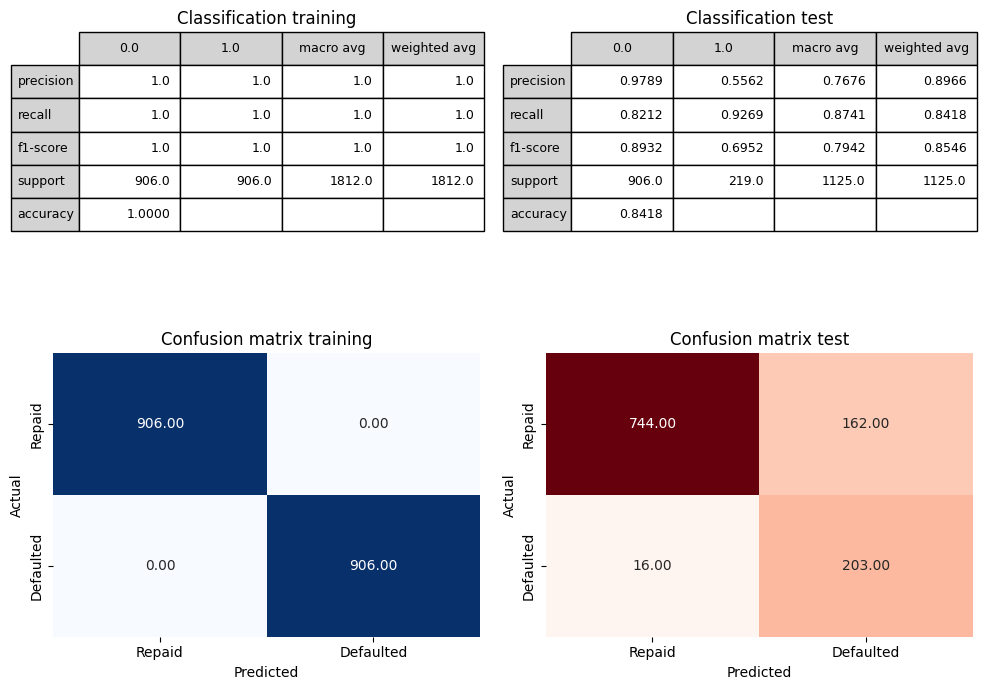

In [89]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(xgb_model_rus, X_rus, y_rus, X_test, y_test, plot=False)
# And plot the results
xgb_rus_train, xgb_rus_test = combined_metrics_score(y_rus, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['XGBoost RUS'] = [xgb_rus_train, xgb_rus_test, {'roc_auc':roc_auc}]

**Observations**

Excellent performance; unfortunately undersampling did not reduce overfitting. The model generates 0 false negatives on the test set.

### **Try reducing the feature set**

One possible strategy to reduce overfitting is to simplify the model. Here we will choose a new feature set based on the importance for the XGBoost model. Importance will be determined via SHAP (mean absolutes of the shap values).

In [90]:
explainer = shap.TreeExplainer(xgb_model, X_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_train)
shap_values = pd.DataFrame(shap_values.values, columns=X_train.columns)
importance = {col:shap_values[col].abs().mean() for col in shap_values.columns}
importance = pd.DataFrame({'mean_sv':importance.values()}, index=importance.keys())
# normalise the importances
importance['mean_sv'] = importance['mean_sv']/importance['mean_sv'].sum()
# and sort them
importance = importance.sort_values(by='mean_sv', ascending=False)

100%|===================| 4490/4496 [03:43<00:00]        

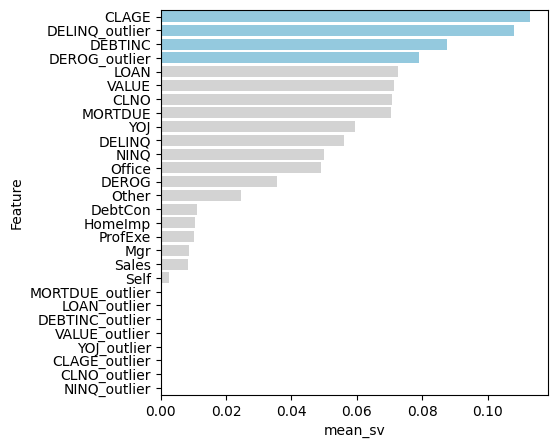

In [91]:
# Percentage of features to retain
feature_percentage = 0.45
# Now calculate the cumulative sum for cutoff
importance['cumulative'] = importance['mean_sv'].cumsum()
important_features = importance[importance.cumulative <= feature_percentage].index
feature_colors = ['skyblue' if feature in important_features else 'lightgrey' for feature in importance.index]

# Plot the importances
plt.figure(figsize = (5, 5))
ax = sns.barplot(x= importance.mean_sv, y=importance.index, palette=feature_colors)
ax.set_ylabel('Feature');

In [92]:
# Create a reduced data set
X_train_red = X_train[important_features]
X_test_red = X_test[important_features]

In [93]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = {'n_estimators':[1500],'max_depth':[4,6,8], 'scale_pos_weight':[1,4.16,10], 'min_child_weight':[3,5],
                       'learning_rate':[0.2]}
# Now fit the optimal model
xgb_model_red = fit_model(XGBClassifier, X_train_red, y_train, 
                      optimisation_params=optimisation_params, 
                      model_params={'objective':'binary:logistic', 'eval_metric':'logloss','scoring':'roc_auc'}, 
                      sample_weight=sample_weight, n_jobs=n_jobs, random_state=random_state, plot=False)
xgb_model_red.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'scoring': 'roc_auc'}

Best threshold=0.13 G-Mean=0.70 ROC AUC=0.76


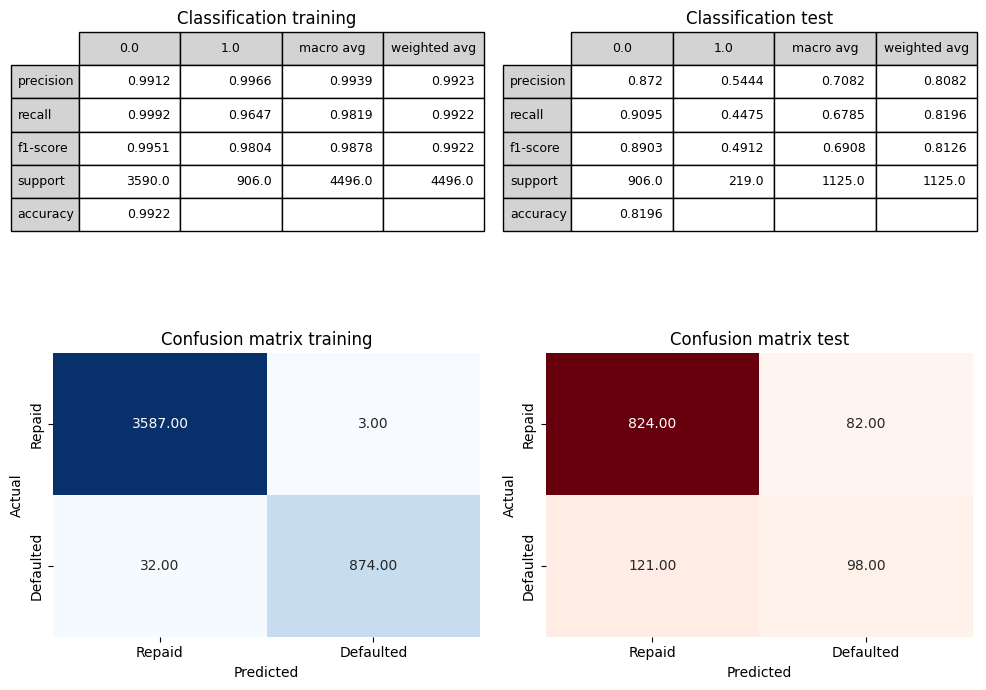

In [94]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(xgb_model_red, X_train_red, y_train, X_test_red, y_test, plot=False)
# And plot the results
xgb_red_train, xgb_red_test = combined_metrics_score(y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['XGBoost (red features)'] = [xgb_red_train, xgb_red_test, {'roc_auc':roc_auc}]

**Observations**

In order to reduce overfitting of the training set and reduce precision and recall below 1, it is necessary to reduce the feature set to only the 4 top features. Including the 5th feature already generates precision and recall of 1. The test set metrics have reduced a lot due to feature reduction.

### **Boosting with LightGBM**

LightGBM is a Microsoft development, mainly known for speed. It is another highly ranked ensemble algorithm, also based on gradient boosting.

In [95]:
# Set the parameters to optimise for GridSearchCV
optimisation_params = {'n_estimators':[1000, 1500], 'num_leaves':[31, 62, 93], 'min_child_samples':[20, 50, 100], 'learning_rate':[0.1,0.2,0.3]}
# Now fit the optimal model
lgbm_model = fit_model(LGBMClassifier, X_train, y_train, class_weight="balanced", optimisation_params=optimisation_params, 
                      model_params={'objective': 'binary', 'class_weight': 'is_unbalance', 'verbose':-1},   
                      sample_weight=sample_weight, n_jobs=n_jobs, random_state=random_state, plot=False)
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_samples': 50,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_leaves': 93,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

Best threshold=0.01 G-Mean=0.95 ROC AUC=0.98


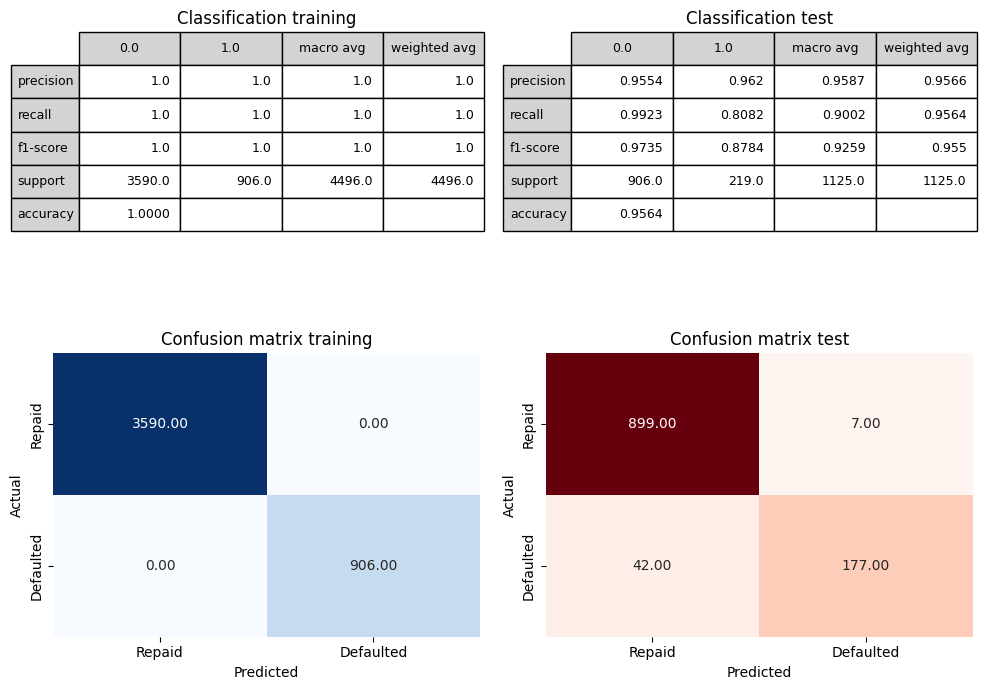

In [96]:
# Obtain the predictions for the training and test sets
y_train_pred, y_test_pred, roc_auc = get_best_prediction(lgbm_model, X_train, y_train, X_test, y_test, plot=False)
# And plot the results
lgbm_cr_train, lgbm_cr_test = combined_metrics_score(y_train, y_train_pred, y_test, y_test_pred, labels=labels, normalize=False)
models['LightGBM'] = [lgbm_cr_train, lgbm_cr_test, {'roc_auc':roc_auc}]

**Observations:**

As all the boosting algorithms on this data set, LightGBM also overfits on the training data. The performance on the test data set is not improved vs XGBoost and the execution (on a local machine without GPU) is not faster.

# **Comparison of various techniques and their relative performance**

In [97]:
def plot_cr(ax, df:pd.DataFrame, title="Model comparison", accuracy:int=4, threshold:float=0.005):
    """Plots a classification report as a table

    Args:
        ax (plt.Axis): a matplotlib axis
        df (pd.DataFrame): Dataframe with the classification report
        title (str, optional): Title. Defaults to "Model comparison".
        accuracy (int, optional): Rounding accuracy. Defaults to 4.
        threshold (float, optional): Threshold for colouring the maximum value per columns. Defaults to 0.005.
    """
    
    df = df.round(accuracy)

    ax.axis('off')
    ax.set_title(title)
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index.to_list(),
                     rowColours=['lightgrey']*df.shape[0],
                     colColours=['lightgrey']*df.shape[1],
                     cellColours=build_colormap(df, threshold=threshold),
                     cellLoc='center',
                     bbox=[0, .1, .8, .8])
    table.auto_set_font_size(False)
    table.set_fontsize(10)

def extract_cr(cr: dict, index: int=0, metrics: list=['precision', 'recall', 'accuracy'], key='weighted avg'):
    """
    Extract the classification report from the dictionary

    cr: classification report
    """
    df = pd.DataFrame(columns=metrics,
                            index = models.keys())
                           
    additional_metrics = list(set(cr[list(cr.keys())[0]][index].keys()).intersection(metrics))
    metrics = [elem for elem in metrics if elem not in additional_metrics]

    for model, cr in models.items():
            df.loc[model] = [f'{cr[index][key][m]:.4f}' for m in metrics] + [f'{cr[index][m]:.4f}' for m in additional_metrics]
    return df

def build_colormap(df:pd.DataFrame, threshold:float=0.005)->np.array:
    """Creates a colormap to highlight the maximum value in each column (with a certain precision)

    Args:
        df (pd.DataFrame): Dataframe for which a colormap is to be created
        threshold (float, optional): Threshold for highlighting. Defaults to 0.005. 

    Returns:
        np.array: colormap
    """
    highlight_color='gold'
    other_color='white'
    # Obtains the highlighted fields with a certain precision
    def get_color(val, max, threshold):
        if abs(float(val)-max)<threshold:
            return highlight_color
        else:
            return other_color
    max_value = {col:pd.to_numeric(df[col]).max() for col in df.columns}
    colormap = df.copy()
    colormap.iloc[:, :] = other_color
    for col in df.columns:
        colormap[col] = [get_color(val, max_value[col], threshold=threshold) for idx, val in df[col].items()]
    return colormap.to_numpy()

def evaluate_models(models: dict, metrics: list=['precision', 'recall','f1-score'], roc_auc:bool=True, threshold:float=0.005):
    """Helper method to evaluate different models by plotting key metrics in a comparsion table between training and test sets

    Args:
        models (dict): Results from the models (confusion matrices and roc_auc scores)
        metrics (list, optional): Metrics to be used. Defaults to ['precision', 'recall','f1-score'].
        roc_auc (bool, optional): Boolean if the roc auc score was provided. Defaults to True.
        threshold (float, optional): Threshold for colouring the maximum values per column. Defaults to 0.005.
    """
    # Extract the metrics from the model dictionary 
    df_train = extract_cr(models, index=0, metrics=metrics)
    df_test  = extract_cr(models, index=1, metrics=metrics)
    # Add the roc_auc if available
    if roc_auc:
            df_test['roc_auc'] = [f'{models[model][2]["roc_auc"]:.4f}' for model in models.keys()]
    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_cr(axes[0], df_train, title="Weighted average metrics (Training)", threshold=threshold)
    plot_cr(axes[1], df_test, title="Weighted average metrics (Test)", threshold=threshold)
    plt.show()
    fig.tight_layout()

#### Comparing all models (in yellow maximum values per column with a precision of 0.005)

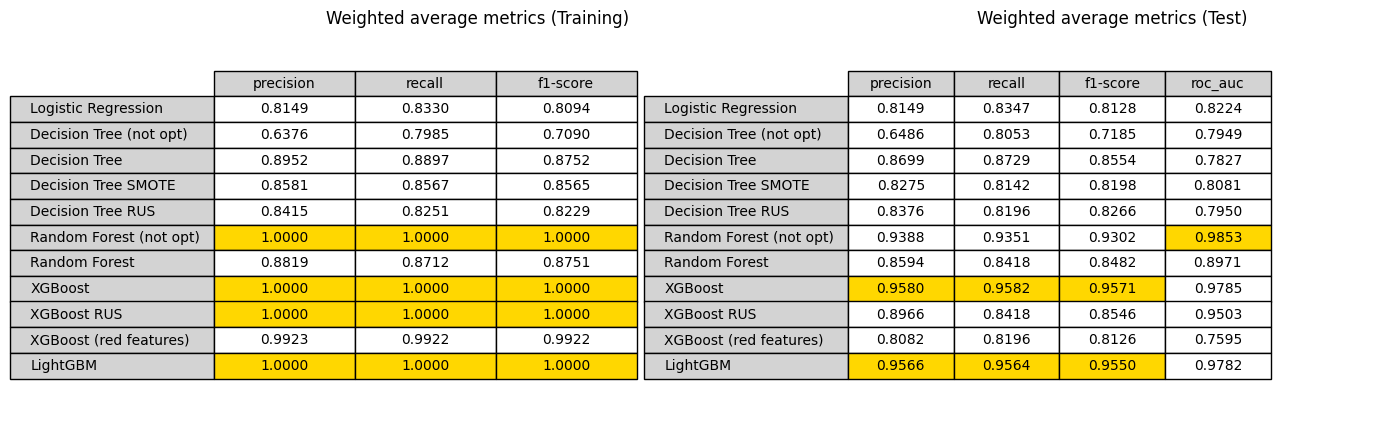

In [98]:
# Execute the evaluation
evaluate_models(models, threshold=0.005)

**Observations**

- We have reached excellent performance on the test data set. Several models reached a roc_auc score of >0.9, with the best values exceeding 0.97.
- Given that our primary target was to reach a recall of at least 85% (and therefore a 15% chance to predict a loan as not defaulting which later defaults), we have exceeded that target with the following models:
    - optimised DecisionTree
    - non-optimised RandomForest 
    - XGBoost
    - LightGBM
- If we are looking more at avoidance of loan defaults, but maximising the number of "safe" loans given, the f1-score relects that better . Also in this case we have exceeded 95% with the two boosting models
- The non-optimised RandomForest overfits on the training data set; optimisation yields results that do not meet the 85% recall target
- The optimised decision tree has a significantly lower roc-auc score than the boosting models and the optimised RandomForest
- All the boosting models overfit on the training data set; we have reduced the feature set to just 4 features to create a XGBoost model with scores<1 on the traing set but this compromised recall (and f1-score) so significantly that an optimised Random Forest model would be preferrable.
- Very likely, the training and test data sets are too small to avoid overfitting by the boosting models. Known for their excellent modeling performance, the optimisation using GridSearchCV simply is too efficient to avoid overfitting.  

**NOTE**  
We are using the weighted average instead of the macro average because we have an imbalanced data set.

**Conclusion**
- The best non-overfitting, i.e. generalisable model with the highest roc-auc score and recall is the **Random Forest** model. However, the model does not meet our requirement of less than 15% defaulting loans that were predicted as repaying.
- The best model on recall - which is extremely stable against underfitting, feature selection etc is the **XGBoost** model.
- Although it is not an easy choice because of the overfitting, we will prefer the latter but would urge the bank to collect more data to further test the performance on unseen data.

In [99]:
# Selecting the best model for analysis
best_model = xgb_model

# **Analysis**
## Most important contributing factors to loan defaulting

In [100]:
explainer = shap.TreeExplainer(best_model, X_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_train)

100%|===================| 4483/4496 [03:34<00:00]        

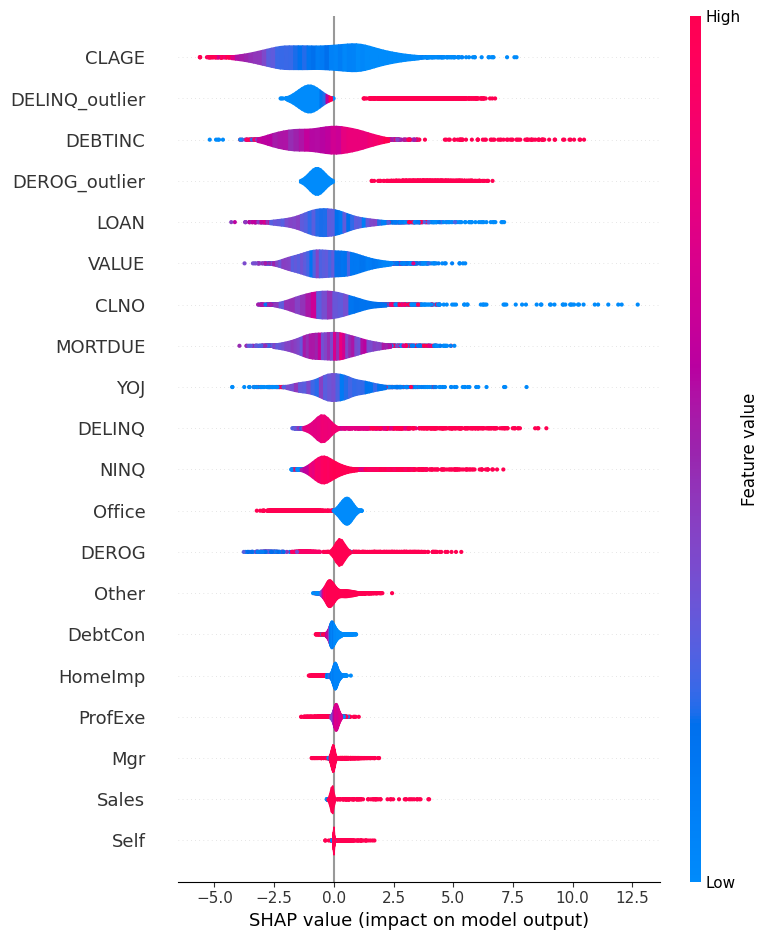

In [101]:
# And plot
shap.summary_plot(shap_values, plot_type='violin')

**Insights**

- New credits are more likely to fail; perhaps this is an expression of the fact that people with newer credits are more volatile, whereas credits once the owners have established a payment "routine" don't fail as much
- For the mortage due, the picture is not very clear. There seems to be a less affluent group possibly related to low loan amounts and property values that have low mortgages but still fail in paying them back. But there is also a group of highly indebted persons that default.
- A low loan value and a low property value also contributes to higher defaulting rate. Very likely this is due to a group of persons that are not well off, buy cheap property with small loans, but still cannot affort them and default.
- High deliquency rate (and and high derogatory reports) clearly indicate a higher risk of defaulting (particularly for those with very high DELINQ and DEROG as shown by the respective outlier features)
- The debt income ratio is important with higher values contributing to a higher chance to defaulting (unsurprisingly). However, the picture is less clear than one would have expected - there sore those with low income/debt ratio that still default. For further interpretation, it would be important to understand the legal consequences of defaulting in the country of the dataset.
- Those with stable jobs default less, also unsurprising. However, there is a subgroup of people a long time in their last job that default. Likely, these correspond to lay-offs, possibly related to age.
- As discovered during EDA, very low and very high numbers of credit lines contribute to more defaulting. Very likely these belong to different groups of people - those with low resources that simply can't pay back and those who are already heavily indebted and simply fail.
- The number of inquiries is a clear indicator for defaulting (we saw that before during EDA). Especially for high(er) number of inquiries a default is almost sure - this is likely an expression of the "ensemble" decision making between different credit institute: if enough others have rejected the credit, it does not seem to be a good idea to grant a loan.
- As we saw earlier, credits for home improvement are more likely to fail than for debt consolidation, so debt conversion lowers the risk of defaulting
- The profession is not a very strong predictor for defaulting. Managers are "riskier", as well as some sales persions and self employeds, perhaps because they face more layoffs. 

These conclusions are compatible with the result from the initial PCA on the loan defaulting class. PCA provides us more with models of personae that will default, whereas the SHAP analysis describes more the feature importance. Here is the list of personae again:

- PC1 is professional with high value property, high outstanding mortgage, a number of credit lines and history of credits  
- PC2 is a sales person with major derogatory reports and a somewhat higher number of credit inquiries  
- PC3 is (probably) a manager with a lot of derogatory reports and a higher number of credit inquiries  
- PC4 is (probably) an office worker, manager or self-employed  
- PC5 is self-employed or a manager for years with old credits, los debt/income ratio using the credit for home improvements. Likely a contractor that suddenly runs out of business  
- PC6 is self-employed or other or a manager new on the job; probably the job didn't work out  
- PC7 is a long employed office worker or a manager with high, old loan. Possibly elder people suddently getting laid off. 

### Identifying factors leading to wrong classification

Let's look into the (small amount of) false predictions for the undersamples XGBoost model. First let's find the SHAP values of those values that were incorrectly predicted.

PermutationExplainer explainer: 48it [00:19,  1.79it/s]                        


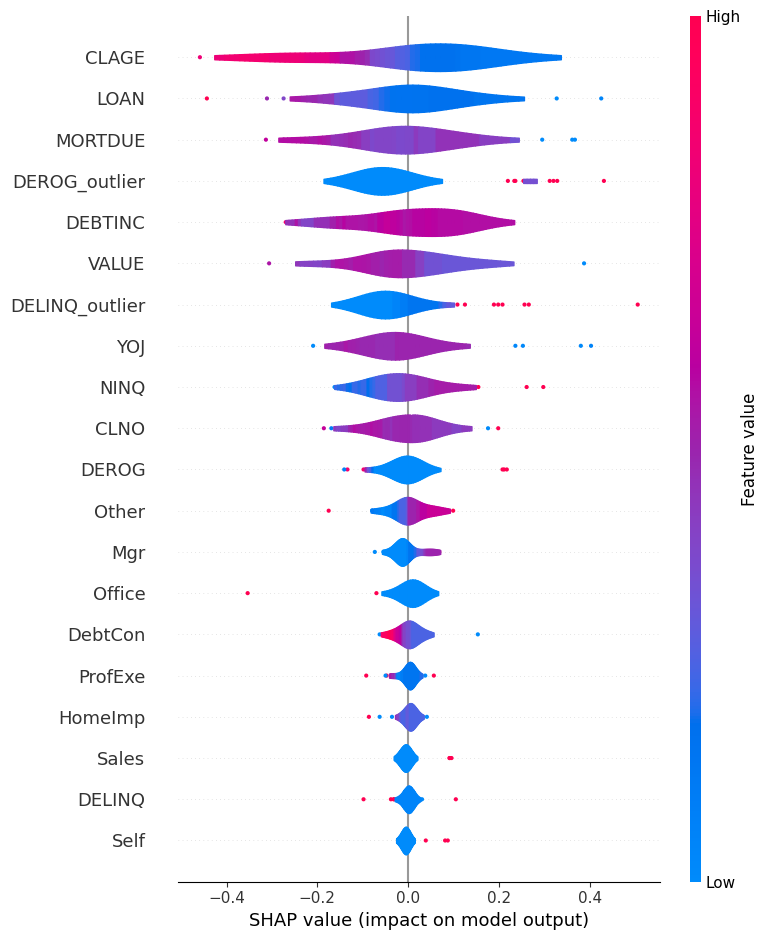

In [102]:
# Obtaining the predictions for the training set (again)
y_test_pred = best_model.predict(X_test)
# Create a dataframe with the predictions and the actual values
Y = pd.DataFrame({target_feature:y_test, 'pred':y_test_pred})
# Get the indices of the wrong predictions
wrong_items = [idx for idx, row in Y.iterrows() if row[target_feature]!=row['pred']]

X_wrong = X_test.loc[wrong_items]
y_wrong = Y.loc[wrong_items]

explainer = shap.Explainer(best_model.predict, X_wrong)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_wrong)
# And plot
shap.summary_plot(shap_values, plot_type='violin')

In [103]:
print(f'There are {len(wrong_items)} wrong predictions out of {len(y_test)} test items or {len(wrong_items)/len(y_test):.0%}.')

There are 47 wrong predictions out of 1125 test items or 4%.


**Observations:**

Incorrectly identified loans in this case are only False positives where we predicted the loan will default but was actually repaid; there are no false negatives. In order to understand what led to wrong decision, we need to look at the postive shap values above.

The misclassified cases have:
- younger age of credit lines
- lower loan amounts
- mid debt/income ratio
- very high delinquency rate and derogatory reports
- mid-stable jobs
- mid property values and mortgage due
- have made many inquiries
- mid credit lines
- work mostly in the office

This possibly describes a group of persons who work in offices in jobs that are not particularly well-paying and are newer on their job. They have had a lot of trouble repaying their debt, but they are trying hard. The bank might consider having a second look at loan applications with such characteristics.

# **Proposal for the final solution design:**

In this study we have studied extensively models for predicting whether a loan would possibly fail. In addition we have tried to identify key factors leading to loan defaulting. None of the models used take many resources to retrain. Even if we assume that a bank receives enough loan applications so that new data on defaulting and non-defaulting loans comes in on a daily basis the model could easily be retrained on a daily basis. A GridSearchCV for the XBoost model took 1min on an Intel i7-8550 CPU without GPU.

For best generalisability the correct model is **Random Forest** for this data set and data preparation. This model **misses** however the target rate of no more than 15% percent of wrongly predicted defaults.

For best performance on the test data set, the best model is **XGBoost**. This model was able to predict results with 0 false negatives. However, it overfits on the training data  and therefore its generalisability needs to be further tested with more data.

Given the robustness of XGBoost with respect to undersamplig, feature reduction and hyperparameter tuning, we would recommend using this model during a test period as secondary information support before automating the decision making process with it.

---

# FINAL SUBMISSION

## **Executive summary**

In the US in 2023, about 1% of mortagages were considered sub-prime (down from 2% in 2022) according to the Office of the Comptroller's OCC Mortgage Metrics Report (https://www.occ.gov/publications-and-resources/publications/mortgage-metrics-reports/index-mortgage-metrics-reports.html). The total residential mortgage debt was about 12 trillion USD. This means that "bad loans" represent about 120 billion USD. According to Global Credit Data, a private organisation that owns the key "Loss Given Default" (LGD) metric of a wide range of banks, in North America the recovery rate in 2023 was 84% (https://globalcreditdata.org/wp-content/uploads/2023/06/GCD-CRE-RR-Report-2023.pdf), i.e. 84% of the value of a loan could be recovered after a default. Therefore, the total cost to the industry of defaulting loans is in the range of 20 billion USD per year. In addition to the direct loss of profit, banks (or non-bank lenders) are also affected by loan defaulting rates because their loss given default rate is a key measure how many reserves a bank must have on their balance sheet. Immobilising capital has a cost. In addition, a bank with a lower defaulting rate will have better profits from home loans and therefore potentially be able to lend money at a lower interest rate, increasing their market share of the home loan market. 

Taking the direct loss of profits, the need for reserves and the opportunit cost together, defaulting loans represent a very significant cost to banks. 

It is therefore of triple interest to reduce the number of defaulting loans - while not diminishing the number of conceded loans. This calls for a precise approval process and elimination of human bias and erroneous judgment. It is important to note that the approval process is conditioned by the Equal Credit Opportunity Act which makes it unlawful to base an approval on factors such as race, color, religion, national origin, sex etc (see e.g. https://www.law.cornell.edu/uscode/text/15/1691).

This study looks at building and evalulating prototype models to predict and explain defaulting loans in an automated fashion. Its concrete aims are to  
(i) Identify reasons for loan defaulting in terms of personae and factors  
(ii) Build a classification model for accurate loan default prediction to be considered for providing unbiased input into the loan concession process   
Given the high cost of defaulting loans, we will pay particular focus on defaulting loans that were predicted to be repaying. (We are therefore interested in *minimising* "false negatives" which can be measured by *maximising* the recall metric.)

It is important to note that this model only uses data in accordance with the Equal Credit Opportunity Act of the United States. It takes into account 
amount of loan approved, amount due on the existing mortgage, current value of the property, reason for the loan request, type of job, years at present job, number of major derogatory reports, number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due), age of the oldest credit line in months, number of recent credit inquiries, number of existing credit lines and debt-to-income ratio. The data set has almost 6000 entries of which 20% are defaulted loans (significantly overrepresented with respect to US loan defaults). It is not known from which period or region these records were extracted.

The quality of the data set is mixed with up to 21% of data missing for the debt-to-income ratio; we removed the 5% of records with more than 3 missing features and proceeded to replace the remaining. After experimenting with a manual strategy, we finally replaced missing values via a clustering method (k-nearest neighbour) which produced probability distributions that were quite similar to the non-treated distributions. Almost all features were strongly skewed with significant outliers. Most features were clipped at the "whisker value" ($\pm 1.5 IQR$), but for some features the borders were manually determined after close analaysis of the data. Features were properly encoded according to their type and scaled if necessary.

The study was able to identify 7 personae of loan defaulters (via PCA). The seven personae are:
- professionals with high value property, high outstanding mortgage, a number of credit lines and history of credits  
- salespersons with major derogatory reports and a somewhat higher number of credit inquiries  
- managers with a lot of derogatory reports and a higher number of credit inquiries  
- office workers, managers or self-employed persons
- self-employeds or managers for years with old credits, low debt/income ratio using the credit for home improvements. Likely a contractor that suddenly runs out of business  
- self-employeds or those with other occupations or a managers new on the job; probably the job didn't work out  
- long employed office workers or managers with high, old loan. Possibly elder people suddently getting laid off.

For prediction, the following models were tried on a 80:20 split between training and test data:
- Logistic regression
- Decision Tree (with default values, optimised hyperparameters and using over- and undersampling)
- Random Forest (with default values and optimised hyperparameters)
- XGBoost (with optimised hyperparameters, undersampling and feature reduction)
- LightGBM (with optimised hyperparameters)
Optimisation of hyperparameters was done using GridSearchCV which includes cross validation.

Both optimised boosting models overfitted on the training data in spite of our best efforts to choose appropriate hyperparameters. Even a reduction to only 5 of the 12 original features produced an overfitting XGBoost model (with 4 features we managed to avoid complete overfitting, but at the expense of a significantly worse performance on the test set). The modeling performance of these algorithms seems so strong that on our small data set it is almost unavoidable to overfit.

The XGBoost model, on the other hand, has shown to be very robust against optimisation, feature reduction and undersampling. For the same model, a "quality score" of the model (roc auc score) was over 97%. The model produced 0 false "will repay" predictions of defaulting loans on the test data set. In spite of it overfitting, we propose that this is still best model for prediction. We suggest trialling this model as secondary decision support in loan concessions and test it on more data before attempting to fully automate the loan concession process.

For feature importance analysis we used a standard analysis method based on the so-called shapley values. The top 5 features were:
- New credits
- High delinquency rate (and high derogatory reports)
- High debt income ratio
- A low loan value and a low property value
- Either a very low or a very high number of credit lines

Finally, we analyse the set of loans that did not default in spite of our contrary prediction. These loans represent 4% of loans that could have been issued, so is a significant business opportunity - although they were not the primary focus of the study. These wrong predictions seem to be correspond to a small group of persons newer on their office jobs with limited financial resources and a lot of difficulties repaying loans in the past who however make ends meet and repaid the loan. It will not be easy to find them amongst similar persons where the loan does default. Perhaps an additional interview for persons of those characteristics can convert some of these leads into successful loan holders.

## **Problem and solution summary**

The objective of this project is to use the Home Equity Dataset (HMEQ) to build a model that is able to **predict** a defaulting loan application **with precision**. More weight is given to incorrect predictions that a loan will be repaid than to incorrect prediction that a loan will indeed default, i.e. **we will value loss reduction over revenue increase** . Predictions furthermore will need to be **interpretable** to (i) prove compliance to the Equal Credit Opportunity Act and (ii) be able to justify a rejection. 
 
In order to meet the objective we need to build a classification model that is able to predict with a  false negative rate < 0.15 (or recall exceeding 0.85) whether a particular loan application will default. For the dataset in question this represents a modest improvement over the naïve error rate of 20% and therefore should be considered a minimum performance requirement for the model. The characteristics of loan defaulting should be analysed and "personae" for loan defaulting built. This information is useful for compliance and justification if a loan application is rejected, but also to avoid marketing efforts to higher risk groups of persons. False predictions of the model need to be analysed carefully, so that factors leading to an incorrect decision can be identified.
As a first step after exploratory data analysis, data was cleaned. Records with more than 3 missing features were discarded (5% of data). The remaining missing values were addressed using two different methodologies of which imputation with k-nearest neighbors was clearly the better alternative when observing the resulting distribution of values. A feature was created with a measure how many columns didn't have null values per row; this feature was later used as sample weight for training, i.e. as "reliability" criterion.  
Outliers were "clipped" at the whisker values, but for each feature a binary "outlier" column was added (true/false).  
Features were encoded according to their type:
- Nominal features using OneHotEncoder
- Ordinal features using OrdinalEncoder
- Numerical features using MinMaxEncoder, as all numerical features had 0 as minimal allowable value

For PCA, the resulting dataframe was then encoded using StandardEncoder. All encoders were kept to be able to map back to the original values.

Given that this is a classification problem where interpretability is key, we opted for trying the following models on a 80:20 split between training and test data:
- Logistic regression
- Decision Tree (with default values, optimised hyperparameters and using over- and undersampling)
- Random Forest (with default values and optimised hyperparameters)
- XGBoost (with optimised hyperparameters, undersampling and feature reduction)
- LightGBM (with optimised hyperparameters)
Optimisation of hyperparameters was done using GridSearchCV; given that the data set is not balanced, we used stratified cross validation.

For all models, the confusion matrix was determined on the training and the test data set. In addition we determined the ROC-AUC score (area under the curve of the receiver operating characteristic) as a general metric for the performance of the model. Our main target was (i) produce a non-overfitting model with (ii) recall > 0.85 and (iii) a good ROC-AUC score (0.80 and above).

Both of the boosting models overfitted on the training data, but produced excellent test results and ROC-AUC score. For XGBoost, we tried a lot of different methods to reduce overfitting, including extreme simplification of the model features. With more then 4 feature the model overfits, quite independently of many of the optimisation parameters. We conclude that the model is very stable and believe it is an excellent candidate in spite of overfitting. Very likely the modeling power of the boosting method where each tree sequentially reduces the residuals of the previous prediction is too great for the limited data set at hand. 

It reaches a recall of 0.96 and produced 0 false negatives on the test set (even its precision was excellent: it produced 42 false positives on 1,100 cases). Its ROC-AUC score exceeded 0.98. 
However, if overfitting and therefore generalisability is a major concern, an optimised Random Forest can *almost* achieve a 0.85 recall with a 0.90 ROC-AUC score. (The recall is slightly better for an optimised DecisionTree, but at a reduced ROC-AUC score of 0.78.)
Regarding the factors that lead the model to predict defaulting, we analysed the shapley values of the training set. The top factors were:
- New credits
- High delinquency rate (and high derogatory reports)
- High debt income ratio
- A low loan value and a low property value
- Either a very low or a very high number of credit lines

We also generated a PCA analysis on the total defaulting class and were able to find 7 different personae that are compatible with these findings. Of course, not all personae are equally represented, so the shapley values give us a slightly less nuanced picture. Three main trends that might be linked to defaulting:
- Persons who are likely older and get suddenly laid off
- Persons with limited resources and credit troubles 
- Younger persons, new to indebting themselves, whose job doesn't work out

We also analysed the false positives, i.e. those who were predicted to default but didn't. While there were very few cases, it seems that these correspond to persons with limited resources and credit troubles but who really make a very honest effort and succeed in repaying the loan. Although this group corresponded to 4% of our test dataset and therefore presents a significant revenue opportunity, we are not convinced that it is differentiated enough from those that do default. Possibly, a personal in-depth interview could help, but the risk is high.

The chosen XGBoost model certainly is very fast. Even training it on a normal laptop (i7-8550) using GridSearchCV took less than 1 min. Therefore this model can be updated almost continuously, and at least much faster than loan default data is likely to come in. It can be an effective decision support system for the risk evaluation department and after further testing, is certainly capable of full automation of the loan concession risk analysis.

## **Recommendations for implementation**
The model has worked excellently on the provided (small and "enriched") dataset. The first recommendation must be to ascertain its performance on a more realistic data set with many less defaults. If the model (or the approach) prove to provide excellent performance, the model needs to be operationalised, i.e. taken from a prototype to a stand-alone solution that can be integrated into the bank's backend. For a first pilot with the risk department, a docker container placed in the bank's cloud infrastructure together with some webservices might be sufficient. The output of the tool should be used for decision support in the risk analysis stage of a loan concession.

Having an operational solution to reduce loan defaults would affect a bank in the following way:  
- It has the potential to decrease very significantly the loan default rate and therefore the loss of profits
- It will allow the marketing department to better target the non-defaulting consumer groups, thereby further reducing the loan default rate
- It will reduce the Loss-Given-Default (LGD) rate and therefore - after approval of the corresponding authority - allow the bank to reduce its reserves
- Finally, with higher profits, the bank may be able to offer lower interest rates, thereby increasing its market share

For a bank (or a non-bank lender) with a market share of 3-4% (like loanDepot; see https://investors.loandepot.com/news/corporate-and-financial-news/corporate-and-financial-news-details/2022/loanDepot-announces-first-quarter-2022-financial-results/default.aspx), the current loss of profit due to defaulting loans is about 700 million USD per annum. A 5% reduction in the loan default rate due to better risk analysis would therefore generate about 35 million USD per year in extra profits, in addition to the other benefits mentioned above. With the best model we found, it seems that we can realistically reduce the risk by more than 15%. 

The main risk and challenges are of a technical nature. Given that the model overfits, it is not clear whether it will perform as strongly on additional new data, especially if that data is much more imbalanced as stands to be expected with a 1% default rate in 2023. It is therefore important to use the model as a decision support, not decision making solution. The recommendation from the model should be made available to the risk analysis department and difference with the current methodology recorded. For most loans it will take years to prove or disprove the prediction, but surely the bank will have a much larger (and possibly more detailed) data set than the one provided to test the model. 

We also suggest considering adding time-related features. Given that macro trends are very likely to influence the loan default rate, it would be good to include a timing component and surely some macroeconomic data.